# Análisis y gestión de datos de mantenimiento mecánico en máquinas grúa

Este estudio propone un enfoque integral para analizar y gestionar los datos de mantenimiento mecánico en máquinas grúa de terminal portuaria, con el objetivo primordial de elevar la eficiencia operativa y reducir los costos asociados al mantenimiento. Se ha llevado a cabo una exhaustiva recopilación y análisis de datos históricos, así como de datos cercanos a tiempo real, obtenidos de las máquinas grúa durante un periodo de un mes en una terminal portuaria de gran escala.

En una primera fase, se detallan los procedimientos implementados para la recopilación y almacenamiento de datos. Todas las incidencias han sido meticulosamente documentadas, incluyendo información sobre las áreas y componentes afectados, horas de trabajo y personal involucrado. Esto ha permitido registrar de manera sistemática todas las actividades de mantenimiento, así como los repuestos utilizados en cada caso.

A continuación, se presenta un análisis minucioso de los datos recopilados. El objetivo es identificar patrones y tendencias en el rendimiento de las máquinas grúa, facilitando la detección temprana de posibles problemas mecánicos y la planificación proactiva de actividades de mantenimiento. Asimismo, se lleva a cabo un análisis de fallas con el propósito de identificar las causas raíz de los problemas mecánicos recurrentes y diseñar medidas correctivas efectivas.

El propósito fundamental de este estudio es demostrar, mediante los resultados obtenidos del análisis, una reducción significativa en el tiempo de inactividad no planificado de las máquinas grúa y una mejora palpable en la utilización de los recursos de mantenimiento. Se espera que esto se traduzca en un incremento notable de la productividad y una disminución efectiva de los costos operativos para la terminal portuaria.

En este contexto, el análisis y gestión de datos de mantenimiento mecánico en máquinas grúa se posiciona como una herramienta sumamente poderosa para optimizar las operaciones portuarias, haciendo uso de técnicas avanzadas como el Machine Learning.

# ***Análisis Exploratorio de los Datos***

1.   Se crea las conexiones e importaciones de librerias necesarias




In [ ]:
from google.colab import drive
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os

In [ ]:
pip install tensorflow


In [ ]:
!pip install category_encoders

In [ ]:
pip install scikit-learn graphviz


In [ ]:
!pip install scikit-optimize

In [ ]:
!pip install xgboost

In [ ]:
from sklearn import linear_model, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, StratifiedKFold, LeaveOneOut, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,r2_score,mean_squared_error,confusion_matrix,ConfusionMatrixDisplay,accuracy_score, recall_score,precision_score, classification_report, silhouette_samples, silhouette_score, davies_bouldin_score, roc_curve, auc, roc_auc_score, f1_score, make_scorer
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SequentialFeatureSelector2
from category_encoders import TargetEncoder
from graphviz import Source
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import random
import xgboost as xgb
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
#drive.mount('/content/gdrive')
#%cd '/content/gdrive/MyDrive/Data Science/'


Mounted at /content/gdrive
/content/gdrive/MyDrive/Data Science


1.1 Se crea codigo de selección de características mediante forward, backward y stepwise selection

In [ ]:
def forward_selection(data, target, significance_level=0.05):
    remaining_features = data.columns.tolist()
    best_features = []
    pvals = []

    while remaining_features:
        p_values = []
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features + [new_column]])).fit()
            p_values.append((new_column, model.pvalues[new_column]))

        best_pval = min(p_values, key=lambda x: x[1])
        if best_pval[1] < significance_level:
            best_features.append(best_pval[0])
            pvals.append(best_pval[1])
            print(best_features, best_pval[1])
            remaining_features.remove(best_pval[0])
        else:
            break

    return best_features, pvals

def backward_elimination(data, target, significance_level=0.05):
    features = data.columns.tolist()
    worst_features = []
    pvals = []

    while features:
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        worst_pval = max(enumerate(p_values), key=lambda x: x[1])

        if worst_pval[1] >= significance_level:
            excluded_feature = features[worst_pval[0]]
            features.remove(excluded_feature)
            worst_features.append(excluded_feature)
            pvals.append(worst_pval[1])
            print(features, worst_pval[1])
        else:
            break

    return features, worst_features, pvals

def stepwise_selection(data, target, SL_in=0.05, SL_out=0.05):
    remaining_features = data.columns.tolist()
    best_features = []

    while remaining_features:
        p_values = []
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features + [new_column]])).fit()
            p_values.append((new_column, model.pvalues[new_column]))

        best_pval = min(p_values, key=lambda x: x[1])
        if best_pval[1] < SL_in:
            best_features.append(best_pval[0])
            print(best_features, best_pval[1])

            while best_features:
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                worst_pval = max(enumerate(p_values), key=lambda x: x[1])

                if worst_pval[1] >= SL_out:
                    excluded_feature = best_features[worst_pval[0]]
                    best_features.remove(excluded_feature)
                    print(best_features, worst_pval[1])
                else:
                    break
        else:
            break

        remaining_features.remove(best_pval[0])

    return best_features

1.2 Se utiliza la libreria pandas para leer los archivos

In [ ]:
df_Mantenimiento_de_Gruas = pd.read_csv('https://raw.githubusercontent.com/quasar1414/Coder/main/Copia%20de%20Mantenimiento%20de%20gruas.csv', delimiter=';')


---

# **Short Story**

Para plantear preguntas fundamentales sobre este conjunto de datos, es esencial comprender la historia subyacente que lo respalda.

El propósito a largo plazo de este estudio es establecer, a través de un análisis detallado de los datos, las bases para la toma de decisiones de alto calibre. Se busca comprender cómo se toman decisiones estratégicas, como la gestión óptima de la flota según la operativa o la cantidad de recursos financieros necesarios para realizar eficientemente el mantenimiento del equipo.

En un contexto más específico, algunas de las interrogantes que pretendemos abordar son: ¿Cuál es la composición más efectiva de la flota que se debe gestionar de acuerdo con las operaciones actuales? ¿Cuántos recursos económicos serían necesarios para gestionar de manera eficiente el mantenimiento del equipo? Estas preguntas cruciales se abordarán a través del análisis exhaustivo de los datos recopilados durante el estudio.

Este enfoque nos permitirá no solo entender el estado actual de las operaciones, sino también proyectar escenarios futuros y tomar decisiones informadas. La utilización de técnicas avanzadas, como el Machine Learning, contribuirá a extraer patrones complejos de los datos, brindando una visión más profunda y precisa que respaldará la toma de decisiones estratégicas de alto nivel en el ámbito de mantenimiento mecánico en máquinas grúa de terminal portuaria.

## *Preguntas e Hipótesis*

El objetivo central de este proyecto es potenciar la eficacia en el mantenimiento mecánico de las grúas, y para alcanzar este propósito, surge la necesidad de realizar preguntas cruciales sobre el conjunto de datos recolectado:

*   **Fallas más Frecuentes**:

¿Cuáles son las fallas que se repiten con mayor frecuencia en el historial de mantenimiento?

Identificar estos problemas recurrentes proporcionará información esencial para la planificación y ejecución de estrategias preventivas.


*   **Eficiencia en el Uso de Recursos Humanos**:

¿Cómo se distribuyen las horas hombre en función de la naturaleza de la falla y el equipo afectado?

Comprender esta relación arrojará luz sobre la complejidad y el esfuerzo requerido para abordar distintos tipos de fallas en los equipos.

*   **Predicción de Fallas Futuras**:

¿Existen patrones o tendencias en los datos que sugieran la posibilidad de fallas futuras?

Aprovechar técnicas predictivas, como el Machine Learning, permitirá anticipar problemas potenciales y adoptar un enfoque preventivo en el mantenimiento.

*   **Temporalidad de las Fallas**:

¿Hay momentos específicos, como ciertas horas del día, días de la semana o períodos estacionales, en los que las fallas son más recurrentes?

 Explorar la temporalidad de las fallas proporcionará información valiosa para programar actividades de mantenimiento de manera más eficiente.
Estas cuestiones estratégicas forman la base de nuestra investigación y nos guiarán hacia soluciones concretas para mejorar la gestión del mantenimiento mecánico de las grúas en la terminal portuaria.



2.  Empezamos haciendo una exploración de los datos, revisamos algunas filas y columnas del conjunto para obtener una idea de su estructura



In [ ]:
df_Mantenimiento_de_Gruas.head()

Tipo de paro       STATUS                          Equipo   \
0           BD   No operat.               Reach Stacker - 39   
1           MC   No operat.               Reach Stacker - 39   
2           MC   No operat.                    Spreader - 22   
3           BD  Seguimiento  Rubber Tyred Gantry Crane - K11   
4           MC    Operativa               Reach Stacker - 41   

  Area que presenta la falla  \
0  Telescopic Boom [RS04.46]   
1  Telescopic Boom [RS04.46]   
2      Twin System [SP07.95]   
3  Control System [RTG02.02]   
4       Powertrain [RS06.24]   

  Componente del area del equipo que presenta falla  \
0  Telescopic Boom-Hydraulic Cylinder [RS04.46.199]   
1  Telescopic Boom-Hydraulic Cylinder [RS04.46.199]   
2          Twin System-Locking System [SP07.95.226]   
3                 Control System-PLC [RTG02.02.259]   
4             Powertrain-Transmission [RS06.24.337]   

                      Descripción breve   \
0  DERRAME DE FLUIDO HIDRAULICO EN PLUMA   
1  DERRAME DE FLUIDO HIDRAULICO EN PLUMA   
2                               NO TRABA   
3                        APAGADO DRIVERS   
4                           NO TRACCIONA   

                                   Descripcion larga  \
0                    ROTURA DE CILINDRO DE EXTENSION   
1                    ROTURA DE CILINDRO DE EXTENSION   
2       NO FUNCIONA TRABA DE TWIN-PENDIENTE MP 500HS   
3  FALLA F33-F31-ACM2- EN CELDA DE CARGA 2, SE AC...   
4  SE RETOCO FICHA DE SENSOR DE TRANSMISION-P/N B...   

  Descubrimiento de la Falla       Síntoma de la falla  \
0            102 OPERACIONES                  607 Fuga   
1                        NaN                       NaN   
2            102 OPERACIONES  602 Pérdida de desempeño   
3          103 MANTENIMIENTO  602 Pérdida de desempeño   
4            102 OPERACIONES  602 Pérdida de desempeño   

       IMPacto de la falla  ... Código del componente  \
0  203 Impacto Operacional  ...           RS04.46.199   
1                      NaN  ...           RS04.46.199   
2  203 Impacto Operacional  ...           SP07.95.226   
3  203 Impacto Operacional  ...          RTG02.02.259   
4  203 Impacto Operacional  ...           RS06.24.337   

                  HORA INICIO                    HORA FIN  WEEK  DAY  \
0  jueves, 1 de junio de 2023  jueves, 1 de junio de 2023  22.0  1.0   
1  jueves, 1 de junio de 2023  jueves, 1 de junio de 2023  22.0  1.0   
2  jueves, 1 de junio de 2023  jueves, 1 de junio de 2023  22.0  1.0   
3  jueves, 1 de junio de 2023  jueves, 1 de junio de 2023  22.0  1.0   
4  jueves, 1 de junio de 2023  jueves, 1 de junio de 2023  22.0  1.0   

  Cantidad de tecnicos Horas hombre Unnamed: 23 Unnamed: 24  Unnamed: 25  
0                  3.0          0,9         NaN         NaN          NaN  
1                  0.0            0         NaN         NaN          NaN  
2                  0.0            0         NaN         NaN          NaN  
3                  3.0          0,5         NaN         NaN          NaN  
4                  3.0          1,5         NaN         NaN          NaN  

[5 rows x 26 columns]

In [ ]:
header=df_Mantenimiento_de_Gruas.columns
header

Index(['Tipo de paro', 'STATUS', 'Equipo ', 'Area que presenta la falla',
       'Componente del area del equipo que presenta falla',
       'Descripción breve ', 'Descripcion larga', 'Descubrimiento de la Falla',
       'Síntoma de la falla', 'IMPacto de la falla', 'Tipo de falla',
       'Causa de la falla', 'Hora del INICIO del trabajo\n',
       'Hora de FINALIZACIÓN del trabajo\n', 'Duracion de trabajo',
       'Nombre del equipo nuevo', 'Código del componente', 'HORA INICIO',
       'HORA FIN', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'Horas hombre',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')

# *Columnas y su descripción*



*   **Tipo de paro** = Tipo de parada de equipo (Mantenmiento Correctivo, preventivo, asistencia operativa, breakdown, Reporte de fallo, Preoperativo)

*   **Status** = Estado del equipo (Operativo, No operativo, Seguimiento)

*   **Equipo** = Nombre, clase y numero de equipo

*   **Area que presenta la falla** = Area del equipo que presenta la falla

*   **Componente del area del equipo que presenta falla** = Componente afectado

*   **Descripcion Breve** = Descripcion simple de la falla

*   **Descripcion larga** = Descripcion detallada de la falla

*   **Descubrimiento de la falla** = Sector que encuentra la falla (Operaciones, mantenimiento, seguridad)

*   **Sintoma de la falla** = (Perdida, humo, paro, fuga, rotura)

*   **Impacto de la falla** = Sector donde impacta la falla (Operaciones, medio ambiente, seguridad)

*   **Tipo de falla** = (Mecanica, estructural, electrica, civil)

*   **Causa de la falla** = (Relacionado a mantenimiento, daño, buque, externo, Contenedor)

*   **Hora del inicio del trabajo** = Hora de comienzo del trabajo

*   **Hora de la finalizacion del trabajo** = Hora de finalizacion del trabajo

*   **Duracion del trabajo** = Duracion total del trabajo

*   **Nombre del equipo nuevo** = Codigo ID del equipo

*   **Codigo del componente** = Codigo ID del componente

*   **Hora de inicio** = Hora de comienzo en la cual transcurre el evento

*   **Hora de fin** = Hora de finalizacion en la cual transcurre el evento

*   **Semana** = Semana en la cual transcurre el evento

*   **Dia** = Dia en el cual transcurre el evento

*   **Cantidad de tecnicos** = Cantidad de tecnicos realizando la tarea

*   **Horas Hombre** = Horas total por todos los tecnicos en la tarea

























In [ ]:
df_Mantenimiento_de_Gruas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   Tipo de paro                                       846 non-null    object        
 1   STATUS                                             847 non-null    object        
 2   Equipo                                             851 non-null    object        
 3   Area que presenta la falla                         843 non-null    object        
 4   Componente del area del equipo que presenta falla  850 non-null    object        
 5   Descripción breve                                  823 non-null    object        
 6   Descripcion larga                                  849 non-null    object        
 7   Descubrimiento de la Falla                         835 non-null    object        
 8   Síntoma de la falla 

In [ ]:
df_Mantenimiento_de_Gruas.describe()

Duracion de trabajo       WEEK         DAY  Cantidad de tecnicos  \
count           810.000000  851.00000  851.000000            851.000000   
mean              2.346039   24.06228   15.289072              2.507638   
std               2.824145    1.31851    8.879513              0.868196   
min               0.016667   22.00000    1.000000              0.000000   
25%               0.316667   23.00000    8.000000              2.000000   
50%               0.750000   24.00000   15.000000              2.000000   
75%               4.000000   25.00000   23.000000              3.000000   
max              21.833333   26.00000   30.000000              4.000000   

       Horas hombre  
count    852.000000  
mean       5.228757  
std        6.627027  
min        0.000000  
25%        0.700000  
50%        1.666667  
75%        9.000000  
max       50.000000

In [ ]:
df_Mantenimiento_de_Gruas.nunique()

Tipo de paro                                           6
STATUS                                                 3
Equipo                                                46
Area que presenta la falla                           239
Componente del area del equipo que presenta falla    480
Descripción breve                                    531
Descripcion larga                                    802
Descubrimiento de la Falla                             2
Síntoma de la falla                                   12
IMPacto de la falla                                    4
Tipo de falla                                          6
Causa de la falla                                      5
Hora del INICIO del trabajo\n                        319
Hora de FINALIZACIÓN del trabajo\n                   317
Duracion de trabajo                                  245
Nombre del equipo nuevo                               44
Código del componente                                423
HORA INICIO                    

In [ ]:
df_Mantenimiento_de_Gruas.isnull().sum()

Tipo de paro                                           6
STATUS                                                 5
Equipo                                                 1
Area que presenta la falla                             9
Componente del area del equipo que presenta falla      2
Descripción breve                                     29
Descripcion larga                                      3
Descubrimiento de la Falla                            17
Síntoma de la falla                                   72
IMPacto de la falla                                   95
Tipo de falla                                        114
Causa de la falla                                    186
Hora del INICIO del trabajo\n                         42
Hora de FINALIZACIÓN del trabajo\n                    42
Duracion de trabajo                                   42
Nombre del equipo nuevo                                4
Código del componente                                159
HORA INICIO                    

2.1  Se crean distintas visualizaciones para obtener una mejor comprensión de los datos





*   Se realiza un conteo del estado del equipo al momento de realizar algún mantenimiento




In [ ]:
conteo = df_Mantenimiento_de_Gruas['STATUS'].value_counts()
conteo

Operativa      557
No operat.     213
Seguimiento     77
Name: STATUS, dtype: int64

*   Se grafica según el status por semana

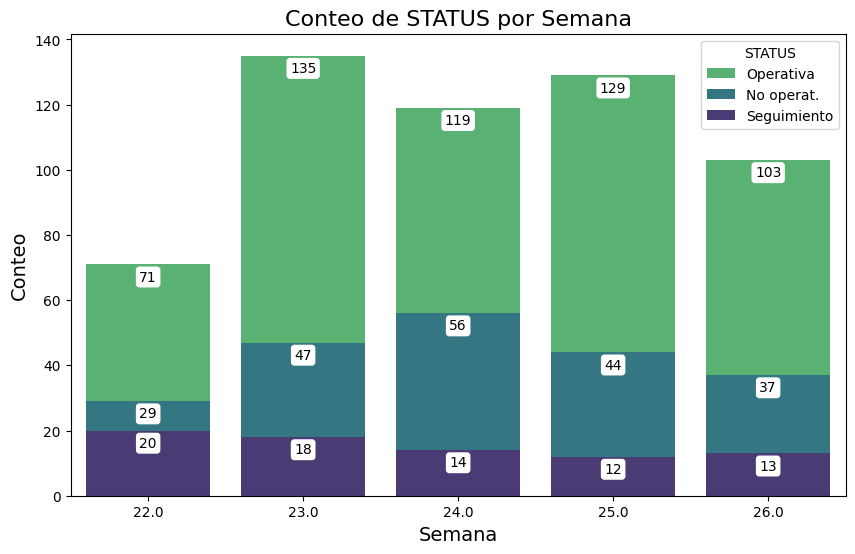

In [ ]:
count_data = df_Mantenimiento_de_Gruas.groupby(['WEEK', 'STATUS']).size().unstack(fill_value=0)

sns.set_palette("viridis")

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=count_data.reset_index(), x='WEEK', y='Operativa', color=sns.color_palette()[4], label='Operativa')
sns.barplot(data=count_data.reset_index(), x='WEEK', y='No operat.', color=sns.color_palette()[2], label='No operat.')
sns.barplot(data=count_data.reset_index(), x='WEEK', y='Seguimiento', color=sns.color_palette()[0], label='Seguimiento')

plt.title('Conteo de STATUS por Semana',fontsize=16, color='black')
plt.xlabel('Semana',fontsize=14, color='black')
plt.ylabel('Conteo',fontsize=14, color='black')
plt.legend(title='STATUS')

for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(
        f'{int(height)}',
        xy=(patch.get_x() + patch.get_width() / 2, height),
        xytext=(0, -12),
        textcoords='offset points',
        ha='center',
        fontsize=10,
        color='black',
        bbox=dict(boxstyle='round,pad=0.2', edgecolor='white', facecolor='white')
    )

plt.show()

*   Se hace un conteo de mantenimientos por equipo

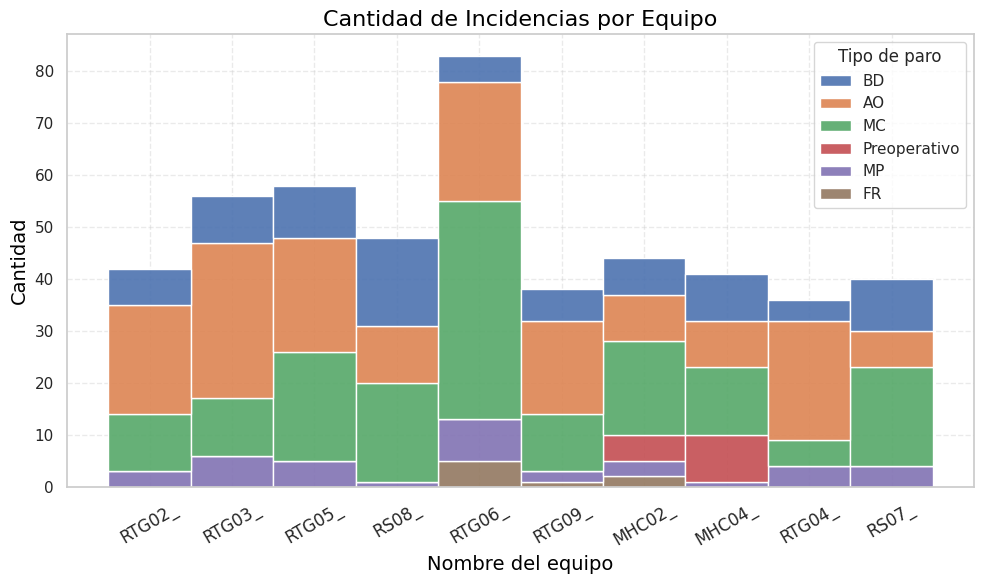

In [ ]:
conteo_elementos = df_Mantenimiento_de_Gruas["Nombre del equipo nuevo"].value_counts()
top_10_conteo = conteo_elementos[:10]
df_top_10 = df_Mantenimiento_de_Gruas[df_Mantenimiento_de_Gruas["Nombre del equipo nuevo"].isin(top_10_conteo.index)]

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df_top_10, x="Nombre del equipo nuevo", hue="Tipo de paro", multiple="stack", alpha=0.9)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=12)

plt.xlabel('Nombre del equipo', fontsize=14, color='black')
plt.ylabel('Cantidad', fontsize=14, color='black')
plt.title('Cantidad de Incidencias por Equipo', fontsize=16, color='black')

ax.yaxis.grid(True, linestyle='dashed', alpha=0.4)
ax.xaxis.grid(True, linestyle='dashed', alpha=0.4)

plt.tight_layout()
plt.show()

Mediante este grafico podemos tener una visualización tentativa  de los tipos de falla según equipo, y estaríamos empezando a responder la primer pregunta propuesta. Cuales son las fallas mas recurrentes en general. Las RTG´s son la familia de equipos con más mantenimientos asociados.

*   Se grafica cantidad de horas hombre implementadas por día

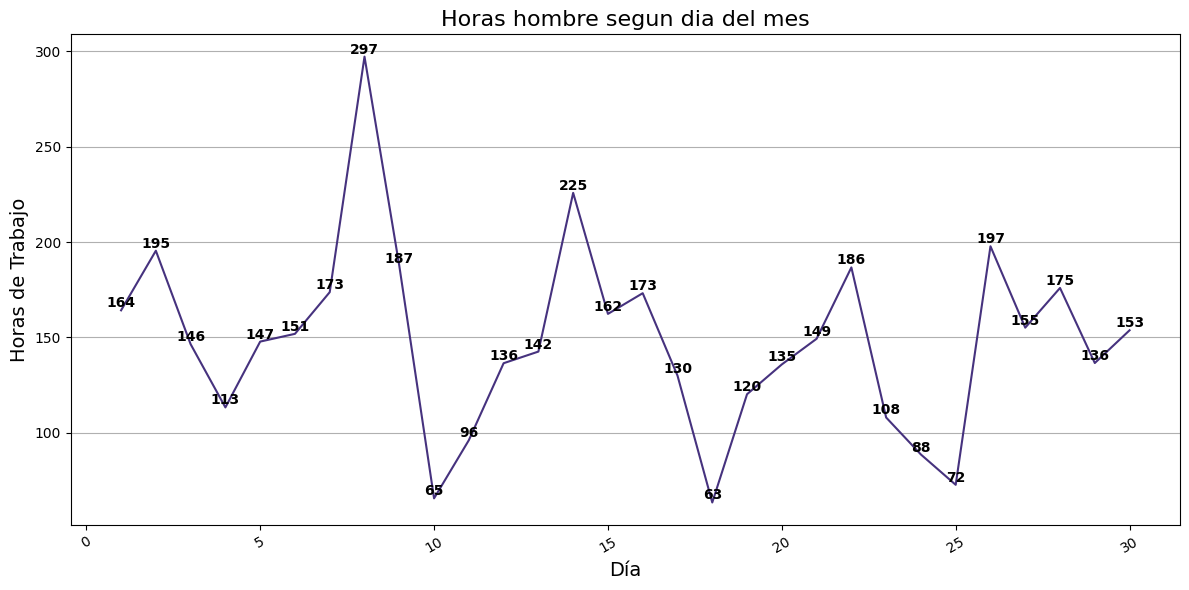

In [ ]:
suma_horas_por_dia = df_Mantenimiento_de_Gruas.groupby('DAY')['Horas hombre'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='DAY', y='Horas hombre', data=suma_horas_por_dia)
plt.xlabel('Día', fontsize=14, color='black')
plt.ylabel('Horas de Trabajo', fontsize=14, color='black')
plt.title('Horas hombre segun dia del mes', fontsize=16, color='black')
plt.xticks(rotation=30)
plt.grid(axis='y')

for x, y in zip(suma_horas_por_dia['DAY'], suma_horas_por_dia['Horas hombre']):
    plt.text(x, y, str(int(y)), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

*   Se grafica cantidad de Técnicos promedio implementadas por día

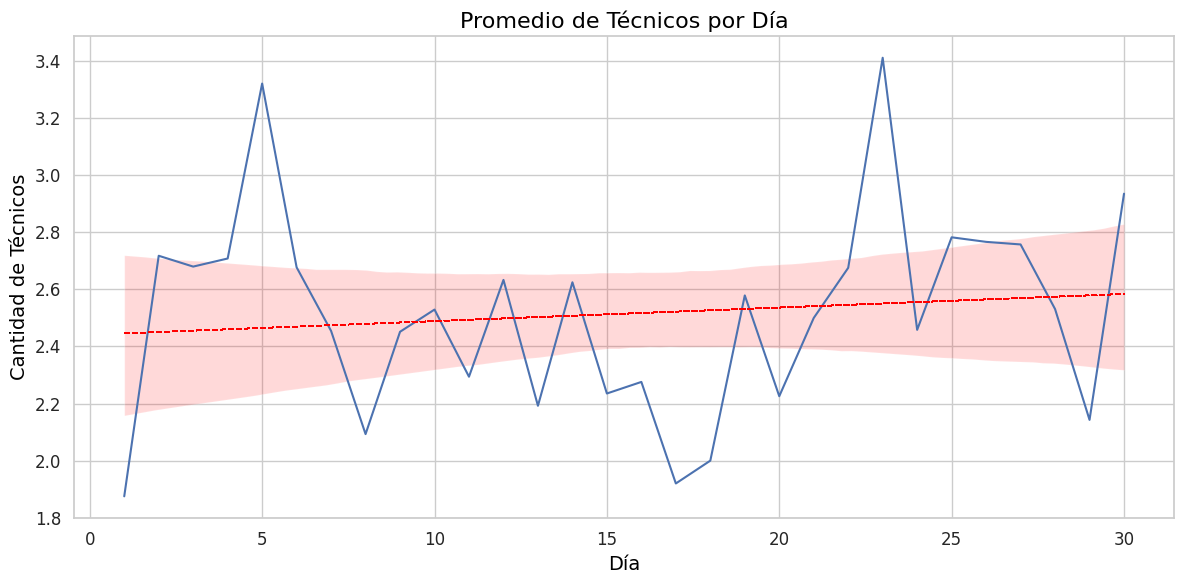

In [ ]:
promedio_tecnicos_por_dia = df_Mantenimiento_de_Gruas.groupby('DAY')['Cantidad de tecnicos'].mean().reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=promedio_tecnicos_por_dia, x="DAY", y='Cantidad de tecnicos')

sns.regplot(data=promedio_tecnicos_por_dia, x="DAY", y='Cantidad de tecnicos', scatter=False, color='red',line_kws={'linestyle': '--', 'linewidth': 1,'antialiased': False})

plt.xlabel('Día', fontsize=14, color='black')
plt.ylabel('Cantidad de Técnicos', fontsize=14, color='black')
plt.title('Promedio de Técnicos por Día', fontsize=16, color='black')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

*   Se procede hacer un conteo del área mas afectada en el mantenmiento, para luego graficar esos áreas recurrentes en función de las horas de trabajo realizadas.

In [ ]:
conteo = df_Mantenimiento_de_Gruas['Area que presenta la falla'].value_counts()
conteo = conteo[conteo >=10]
print(conteo)

Powertrain [RTG06.24]                     25
Powertrain [RTG05.24]                     19
Gantry [RTG06.07]                         17
Hydraulic System [RS08.15]                17
Control System [RTG03.02]                 13
Powertrain [RTG02.24]                     13
Mobile Harbour Crane - 03 [MHC03]         12
Gantry [RTG04.07]                         12
Rubber Tyred Gantry Crane - 06 [RTG06]    11
Powertrain [RS08.24]                      11
Gantry [RTG09.07]                         10
Rotating Unit [MHC02.61]                  10
Spreader [MHC03.30]                       10
Spreader Comp. [RS07.14]                  10
Spreader Comp. [RS06.14]                  10
Spreader Control [MHC04.29]               10
Control System [RTG02.02]                 10
Name: Area que presenta la falla, dtype: int64


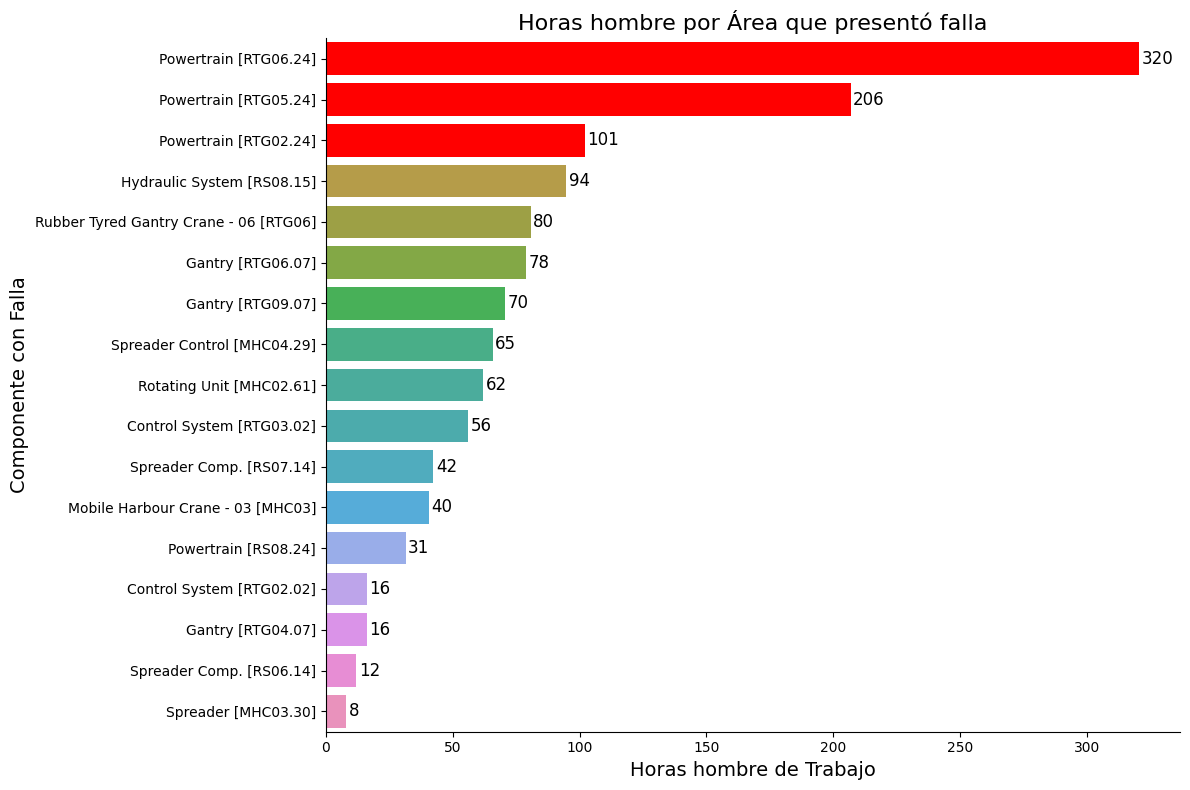

In [ ]:
df_conteo = df_Mantenimiento_de_Gruas[df_Mantenimiento_de_Gruas['Area que presenta la falla'].isin(conteo.index)]
suma_horas_por_area = df_conteo.groupby('Area que presenta la falla')['Horas hombre'].sum().reset_index()
suma_horas_por_area = suma_horas_por_area.sort_values(by='Horas hombre',ascending=False)

top3_componentes = suma_horas_por_area.nlargest(3, 'Horas hombre')

sns.set_palette("viridis")

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Horas hombre', y='Area que presenta la falla', data=suma_horas_por_area, ci=None, orient='h')

for i, val in enumerate(suma_horas_por_area['Horas hombre']):
    if suma_horas_por_area.iloc[i]['Area que presenta la falla'] in top3_componentes['Area que presenta la falla'].values:
        ax.patches[i].set_facecolor('red')

plt.xlabel('Horas hombre de Trabajo', fontsize=14, color='black')
plt.ylabel('Area con Falla', fontsize=14, color='black')
plt.title('Horas hombre por Área que presentó falla', fontsize=16, color='black')

for i, val in enumerate(suma_horas_por_area['Horas hombre']):
    plt.text(val + 1, i, f'{int(val)}', va='center', fontsize=12)

sns.despine()

plt.tight_layout()
plt.show()


De este gráfico podemos sacar la conclusión de que el área Powertrain de la familia de equipos RTG (RTG06, RTG05, RTG02) es el que más horas hombre fue implementado. Podríamos crear planes preventivos haciendo más foco en esta área en específico.

*   Se realiza el mismo análisis a nivel componente.



In [ ]:
conteo2 = df_Mantenimiento_de_Gruas[df_Mantenimiento_de_Gruas["Componente del area del equipo que presenta falla"] != "NO ID"]["Componente del area del equipo que presenta falla"].value_counts()
conteo2 = conteo2[conteo2 >= 5]
print(conteo2)

Powertrain-Main Engine (1) [RTG06.24.600]                 15
Powertrain-Main Engine (1) [RTG05.24.600]                 11
Rubber Tyred Gantry Crane - 06 [RTG06]                    11
Control System-PLC [RTG03.02.259]                          9
Powertrain-Main Engine (1) [RTG02.24.600]                  9
Control System-PLC [RTG02.02.259]                          8
Rubber Tyred Gantry Crane - 04 [RTG04]                     7
Powertrain-Engine-Cooling System [MHC02.24.141.204]        7
Spreader Control-Cable Reel [MHC04.29.069]                 7
Control System-PLC [RTG10.02.259]                          7
Hydraulic System-Block-Brake [RS08.15.037.177]             7
Rubber Tyred Gantry Crane - 03 [RTG03]                     6
Reach Stacker - 07 [RS07]                                  5
Powertrain-Engine-Oil System [RS03.24.141.201]             5
Spreader Comp.-Encod./Limit Sw./Sens. [EH02.14.139]        5
Main Hoist-Inverter 1/Master [RTG09.05.614]                5
Rotating Unit-Structure-

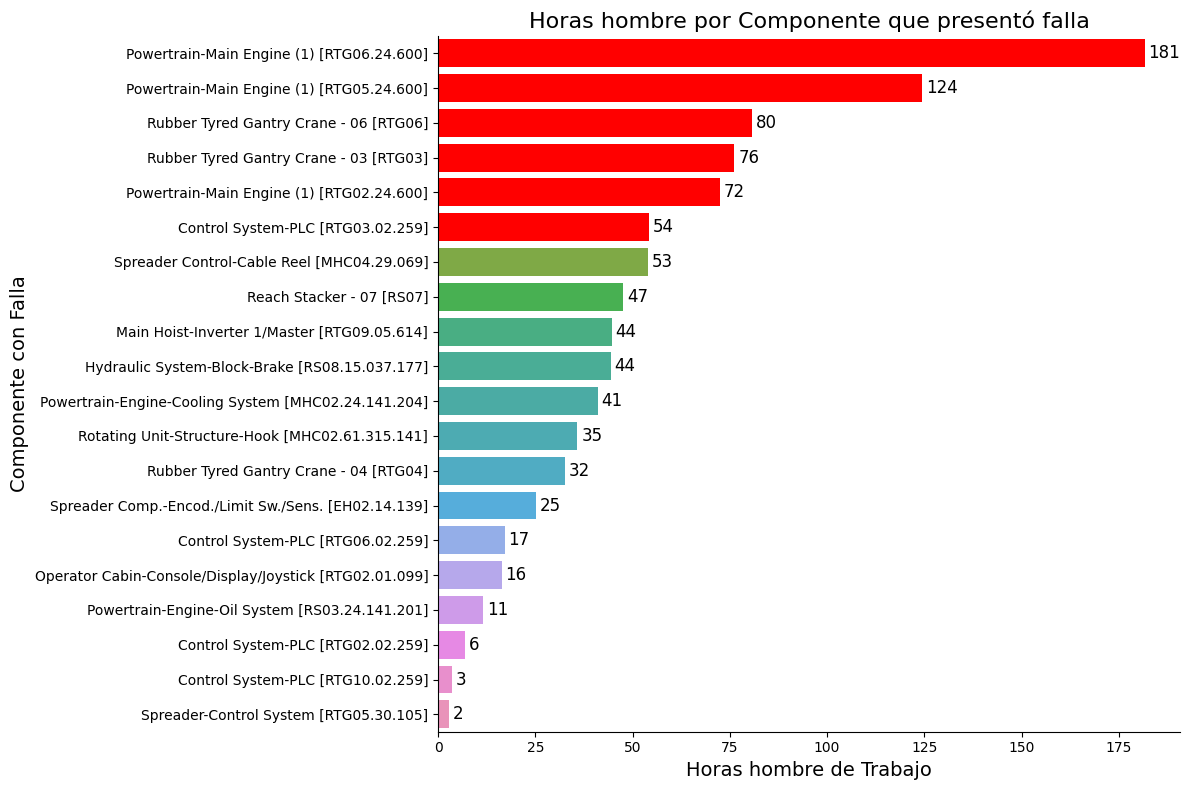

In [ ]:
df_conteo2 = df_Mantenimiento_de_Gruas[df_Mantenimiento_de_Gruas['Componente del area del equipo que presenta falla'].isin(conteo2.index)]
suma_horas_por_componente = df_conteo2.groupby('Componente del area del equipo que presenta falla')['Horas hombre'].sum().reset_index()
suma_horas_por_componente = suma_horas_por_componente.sort_values(by='Horas hombre',ascending=False)

top3_componentes = suma_horas_por_componente.nlargest(6, 'Horas hombre')

sns.set_palette("viridis")

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Horas hombre', y='Componente del area del equipo que presenta falla', data=suma_horas_por_componente, ci=None, orient='h')

for i, val in enumerate(suma_horas_por_componente['Horas hombre']):
    if suma_horas_por_componente.iloc[i]['Componente del area del equipo que presenta falla'] in top3_componentes['Componente del area del equipo que presenta falla'].values:
        ax.patches[i].set_facecolor('red')

plt.xlabel('Horas hombre de Trabajo', fontsize=14, color='black')
plt.ylabel('Componente con Falla', fontsize=14, color='black')
plt.title('Horas hombre por Componente que presentó falla', fontsize=16, color='black')

for i, val in enumerate(suma_horas_por_componente['Horas hombre']):
    plt.text(val + 1, i, f'{int(val)}', va='center', fontsize=12)

sns.despine()

plt.tight_layout()
plt.show()


Acá podemos ver como los 6 primeros componentes son de la familia de RTG, siendo una re-comprobación de que esta familia de equipos es la que deberíamos poner foco.

*   Se hace un nuevo filtro según familia de equipo para corroborar donde se colocan más horas hombre.

In [ ]:
data_nueva=df_Mantenimiento_de_Gruas
data_nueva["Familia equipo"]=data_nueva["Nombre del equipo nuevo"].str[:2]

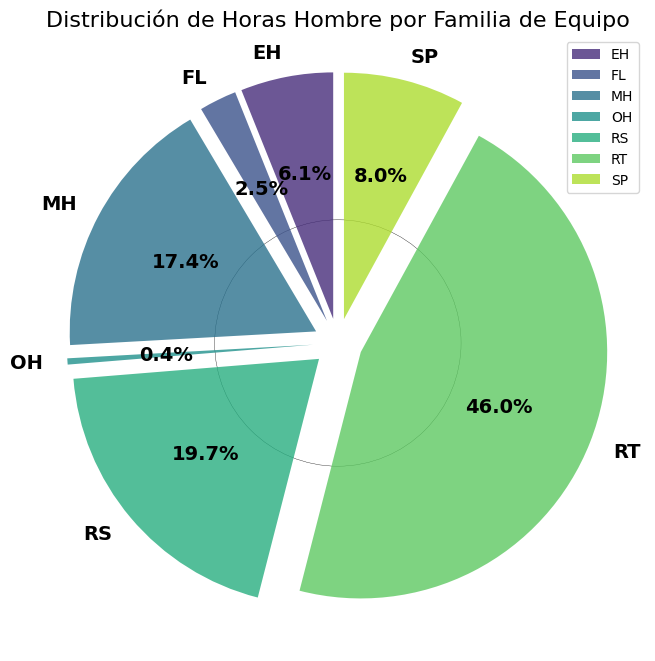

In [ ]:
agrupado = data_nueva.groupby("Familia equipo")["Horas hombre"].sum()

sns.set_palette("viridis")

plt.figure(figsize=(8, 8))

colors = sns.color_palette("viridis", n_colors=len(agrupado))

colors_with_alpha = [(r, g, b, 0.8) for r, g, b in colors]

explode = [0.1] * len(agrupado)

plt.gca().add_patch(plt.Circle((0, 0), 0.5, fc='white', color='black', linewidth=0.25))

agrupado.plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=True, colors=colors_with_alpha,explode=explode, fontsize=14, textprops={'fontweight': 'bold'})

plt.title('Distribución de Horas Hombre por Familia de Equipo', fontsize=16, color='black')
plt.ylabel('')

plt.show()

Una vez más, podemos corroborar que el 46% de las horas hombre implementadas están en la familia de equipo RTG.

*  Se procede hacer un conteo de las fallas más recurrentes en el mantenimiento, para luego graficar esas fallas recurrentes en función de las horas de trabajo realizadas.

In [ ]:
Razon_de_falla = df_Mantenimiento_de_Gruas['Descripción breve '].value_counts()
Razon_de_falla = Razon_de_falla[Razon_de_falla >= 8]
print(Razon_de_falla)

Equipo no traslada    62
MP                    53
Gancho                22
APAGADO DRIVERS       20
Preoperativo          16
Control de niveles    14
se apaga spreader     11
Ajuste de parking     10
no arranca            10
Name: Descripción breve , dtype: int64


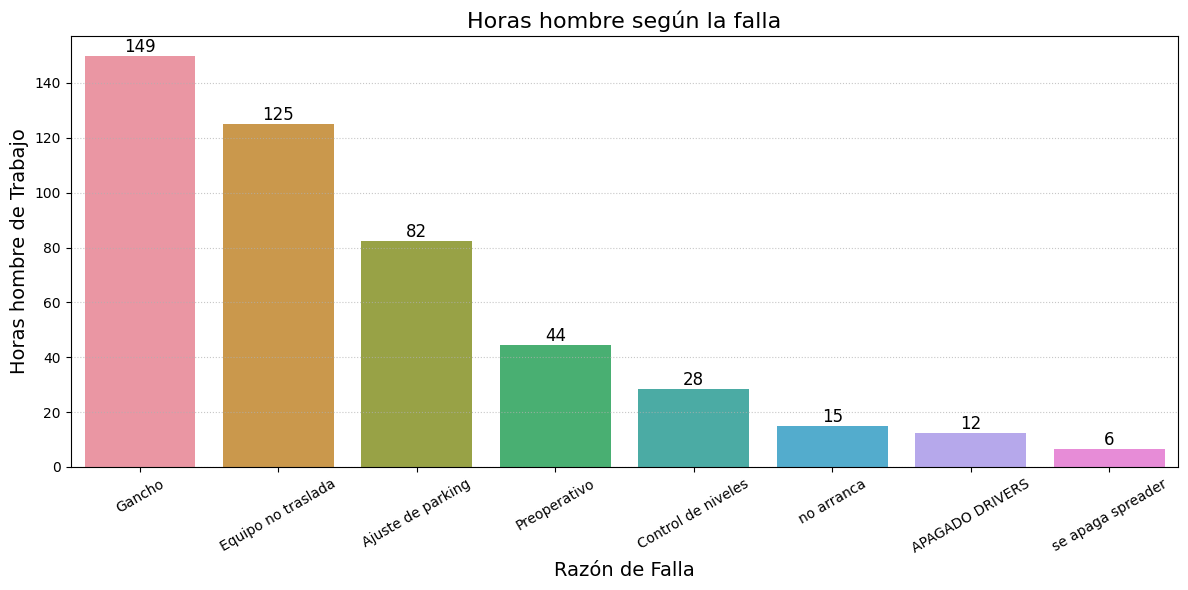

In [ ]:
df_filtrado = df_Mantenimiento_de_Gruas[df_Mantenimiento_de_Gruas['Descripción breve '].isin(Razon_de_falla.index) & (df_Mantenimiento_de_Gruas['Descripción breve '] != 'MP')]
suma_horas_por_falla = df_filtrado.groupby('Descripción breve ')['Horas hombre'].sum().reset_index()
suma_horas_por_falla = suma_horas_por_falla.sort_values(by='Horas hombre', ascending=False)

sns.set_palette("viridis")

plt.figure(figsize=(12, 6))
sns.barplot(x='Descripción breve ', y='Horas hombre', data=suma_horas_por_falla)

plt.xlabel('Razón de Falla', fontsize=14, color='black')
plt.ylabel('Horas hombre de Trabajo', fontsize=14, color='black')
plt.title('Horas hombre según la falla', fontsize=16, color='black')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='dotted', alpha=0.7)

for index, value in enumerate(suma_horas_por_falla['Horas hombre']):
    plt.text(index, value, str(int(value)), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

En este gráfico podemos deducir que los ganchos de las gruas MHC son las que más horas hombre se implementa por razón de falla, por lo tanto, seria una buena opción tener más ganchos de back up para que la grúa siempre pueda estar operativa, a su vez intentar optimizar las reparaciones por falla de gancho, como creando algun procedimiento específico según la falla.

Esta gráfica nos responde nuestra segunda pregunta,en que falla en específico se coloca más horas hombre.

------



# Encoding

3. Se crea un nuevo dataframe data_encoded y se mapea algunas columnas del dataset extraido con one-hot

In [ ]:
# Codificación One-Hot para 'STATUS','Descubrimiento de la Falla','IMPacto de la falla'
columns_to_one_hot = ['STATUS', 'Descubrimiento de la Falla', 'IMPacto de la falla']
data_encoded = pd.get_dummies(df_Mantenimiento_de_Gruas, columns=columns_to_one_hot)

# Codificación de Etiquetas para 'Status', 'Descubrimiento de la Falla', 'IMPacto de la falla'
label_mappings = {'STATUS': {'Operativa': 100, 'No operat.': 200, 'Seguimiento': 300},
    'Descubrimiento de la Falla': {'102 OPERACIONES': 40, '103 MANTENIMIENTO': 50},
    'IMPacto de la falla': {'201 Impacto en seguridad': 60, '202 Impacto en medio ambiente': 70, '203 Impacto Operacional': 80}}

for column, mapping in label_mappings.items():
    new_column_name = f'{column.lower()}_encoded'
    data_encoded[new_column_name] = df_Mantenimiento_de_Gruas[column].map(mapping)

# Resultado
data_encoded

Tipo de paro                          Equipo   \
0             BD               Reach Stacker - 39   
1             MC               Reach Stacker - 39   
2             MC                    Spreader - 22   
3             BD  Rubber Tyred Gantry Crane - K11   
4             MC               Reach Stacker - 41   
..           ...                              ...   
847           MP  Rubber Tyred Gantry Crane - K20   
848           BD        Mobile Harbour Crane - 10   
849           AO        Mobile Harbour Crane - 08   
850           MC        Mobile Harbour Crane - 10   
851          NaN                              NaN   

      Area que presenta la falla  \
0      Telescopic Boom [RS04.46]   
1      Telescopic Boom [RS04.46]   
2          Twin System [SP07.95]   
3      Control System [RTG02.02]   
4           Powertrain [RS06.24]   
..                           ...   
847           Trolley [RTG05.06]   
848     Rotating Unit [MHC04.61]   
849          Spreader [MHC02.30]   
850  Spreader Control [MHC04.29]   
851                          NaN   

    Componente del area del equipo que presenta falla  \
0    Telescopic Boom-Hydraulic Cylinder [RS04.46.199]   
1    Telescopic Boom-Hydraulic Cylinder [RS04.46.199]   
2            Twin System-Locking System [SP07.95.226]   
3                   Control System-PLC [RTG02.02.259]   
4               Powertrain-Transmission [RS06.24.337]   
..                                                ...   
847                    Trolley-Gearbox [RTG05.06.173]   
848                          Rotating Unit [MHC04.61]   
849                               Spreader [MHC02.30]   
850  Spreader Control-Electrical Drive [MHC04.29.125]   
851                                               NaN   

                        Descripción breve   \
0    DERRAME DE FLUIDO HIDRAULICO EN PLUMA   
1    DERRAME DE FLUIDO HIDRAULICO EN PLUMA   
2                                 NO TRABA   
3                          APAGADO DRIVERS   
4                             NO TRACCIONA   
..                                     ...   
847                                     MP   
848                                 Gancho   
849                instalacion de spreader   
850                                 Gancho   
851                                    NaN   

                                     Descripcion larga  \
0                      ROTURA DE CILINDRO DE EXTENSION   
1                      ROTURA DE CILINDRO DE EXTENSION   
2         NO FUNCIONA TRABA DE TWIN-PENDIENTE MP 500HS   
3    FALLA F33-F31-ACM2- EN CELDA DE CARGA 2, SE AC...   
4    SE RETOCO FICHA DE SENSOR DE TRANSMISION-P/N B...   
..                                                 ...   
847  Se continua con el preventivo W0 559035, queda...   
848  El operador indica que no gira el gancho, se r...   
849  Se trae la grua hasta el muelle principal, se ...   
850  se revisa el gancho y el cable reel y se encue...   
851                                                NaN   

          Síntoma de la falla        Tipo de falla  \
0                    607 Fuga                  NaN   
1                         NaN                  NaN   
2    602 Pérdida de desempeño                  NaN   
3    602 Pérdida de desempeño                  NaN   
4    602 Pérdida de desempeño                  NaN   
..                        ...                  ...   
847  602 Pérdida de deseMPeño    399  No hay falla   
848  602 Pérdida de desempeño  304 Falla Eléctrica   
849             699 No aplica    399  No hay falla   
850          609 Roto/doblado  304 Falla Eléctrica   
851                       NaN                  NaN   

                   Causa de la falla Hora del INICIO del trabajo\n  ...  \
0                                NaN                      01:32:00  ...   
1                                NaN                           NaN  ...   
2                                NaN                           NaN  ...   
3                                NaN              

Se prueba una codificacion one hot para equipo pero se decide utilizar otra

In [ ]:
from sklearn.decomposition import PCA

# Codificación One-Hot para 'Equipo'
equipo_encoded = pd.get_dummies(df_Mantenimiento_de_Gruas['Equipo '], prefix='equipo')

# Se aplica PCA para reducción de dimensionalidad
pca = PCA(n_components=5)  # Escoge el número de componentes deseados
equipo_pca = pca.fit_transform(equipo_encoded)

# Se crea un DataFrame con los componentes principales
equipo_pca_df = pd.DataFrame(equipo_pca, columns=['equipo_pc1', 'equipo_pc2', 'equipo_pc3', 'equipo_pc4', 'equipo_pc5'])

# Se concatena los componentes principales con el DataFrame original
data_encoded = pd.concat([data_encoded, equipo_pca_df], axis=1)

# Resultado
print(equipo_pca_df)

     equipo_pc1  equipo_pc2  equipo_pc3  equipo_pc4  equipo_pc5
0     -0.049954   -0.016898   -0.033774   -0.019786   -0.012779
1     -0.049954   -0.016898   -0.033774   -0.019786   -0.012779
2     -0.053711   -0.018297   -0.035815   -0.023969   -0.012318
3     -0.102344   -0.057920   -0.150010   -0.180636   -0.362010
4     -0.070944   -0.029193   -0.054254   -0.009477   -0.070722
..          ...         ...         ...         ...         ...
883   -0.189966    0.863491    0.338871    0.074217    0.031922
884   -0.099868   -0.052515   -0.137060   -0.160310   -0.182490
885   -0.108109   -0.065169   -0.179609   -0.284441    0.867355
886   -0.099868   -0.052515   -0.137060   -0.160310   -0.182490
887   -0.048040   -0.016024   -0.031966   -0.018564   -0.011909

[888 rows x 5 columns]


3.1  Este código se encarga de transformar otras columnas categóricas:

*  column_mappings: Se crea un diccionario que mapea los nombres de las columnas. Originales a los nombres de las nuevas columnas que vamos a crear.

*  El bucle for: Se iteran a través de cada elemento (columna original y su correspondiente columna de destino) en el diccionario column_mappings.

*  unique_values: Para cada columna original, estamos obteniendo todos los valores únicos que aparecen en esa columna.

*  value_mapping: Se crea un nuevo diccionario (value_mapping) que asigna cada valor único a un número. Estamos enumerando los valores únicos y asignándoles un número, comenzando desde 1.

*  data_encoded[target_column] = df_Mantenimiento_de_Gruas[column].map(value_mapping): Aca estamos creando una nueva columna en el DataFrame data_encoded, utilizando el nombre de columna de destino. Luego, se asignan a esta columna los valores de la columna original (df_Mantenimiento_de_Gruas[column]), pero reemplazando cada valor con su equivalente numérico según el mapeo definido en value_mapping.

Al final, el bucle se repetirá para todas las columnas especificadas en column_mappings, y el DataFrame data_encoded contendrá las nuevas columnas numéricas.

In [ ]:
column_mappings = {
    'Equipo ': 'target_Equipo',
    'Area que presenta la falla': 'target_area',
    'Componente del area del equipo que presenta falla': 'target_componente',
    'Síntoma de la falla': 'target_sintoma',
    'Tipo de falla': 'target_tipo_falla',
    'Causa de la falla': 'target_causa_falla',
    'Tipo de paro' : 'target_tipo_paro'
}

for column, target_column in column_mappings.items():
    unique_values = df_Mantenimiento_de_Gruas[column].unique()
    value_mapping = {value: number for number, value in enumerate(unique_values, start=1)}
    data_encoded[target_column] = df_Mantenimiento_de_Gruas[column].map(value_mapping)

data_encoded

Tipo de paro                          Equipo   \
0             BD               Reach Stacker - 39   
1             MC               Reach Stacker - 39   
2             MC                    Spreader - 22   
3             BD  Rubber Tyred Gantry Crane - K11   
4             MC               Reach Stacker - 41   
..           ...                              ...   
847           MP  Rubber Tyred Gantry Crane - K20   
848           BD        Mobile Harbour Crane - 10   
849           AO        Mobile Harbour Crane - 08   
850           MC        Mobile Harbour Crane - 10   
851          NaN                              NaN   

      Area que presenta la falla  \
0      Telescopic Boom [RS04.46]   
1      Telescopic Boom [RS04.46]   
2          Twin System [SP07.95]   
3      Control System [RTG02.02]   
4           Powertrain [RS06.24]   
..                           ...   
847           Trolley [RTG05.06]   
848     Rotating Unit [MHC04.61]   
849          Spreader [MHC02.30]   
850  Spreader Control [MHC04.29]   
851                          NaN   

    Componente del area del equipo que presenta falla  \
0    Telescopic Boom-Hydraulic Cylinder [RS04.46.199]   
1    Telescopic Boom-Hydraulic Cylinder [RS04.46.199]   
2            Twin System-Locking System [SP07.95.226]   
3                   Control System-PLC [RTG02.02.259]   
4               Powertrain-Transmission [RS06.24.337]   
..                                                ...   
847                    Trolley-Gearbox [RTG05.06.173]   
848                          Rotating Unit [MHC04.61]   
849                               Spreader [MHC02.30]   
850  Spreader Control-Electrical Drive [MHC04.29.125]   
851                                               NaN   

                        Descripción breve   \
0    DERRAME DE FLUIDO HIDRAULICO EN PLUMA   
1    DERRAME DE FLUIDO HIDRAULICO EN PLUMA   
2                                 NO TRABA   
3                          APAGADO DRIVERS   
4                             NO TRACCIONA   
..                                     ...   
847                                     MP   
848                                 Gancho   
849                instalacion de spreader   
850                                 Gancho   
851                                    NaN   

                                     Descripcion larga  \
0                      ROTURA DE CILINDRO DE EXTENSION   
1                      ROTURA DE CILINDRO DE EXTENSION   
2         NO FUNCIONA TRABA DE TWIN-PENDIENTE MP 500HS   
3    FALLA F33-F31-ACM2- EN CELDA DE CARGA 2, SE AC...   
4    SE RETOCO FICHA DE SENSOR DE TRANSMISION-P/N B...   
..                                                 ...   
847  Se continua con el preventivo W0 559035, queda...   
848  El operador indica que no gira el gancho, se r...   
849  Se trae la grua hasta el muelle principal, se ...   
850  se revisa el gancho y el cable reel y se encue...   
851                                                NaN   

          Síntoma de la falla        Tipo de falla  \
0                    607 Fuga                  NaN   
1                         NaN                  NaN   
2    602 Pérdida de desempeño                  NaN   
3    602 Pérdida de desempeño                  NaN   
4    602 Pérdida de desempeño                  NaN   
..                        ...                  ...   
847  602 Pérdida de deseMPeño    399  No hay falla   
848  602 Pérdida de desempeño  304 Falla Eléctrica   
849             699 No aplica    399  No hay falla   
850          609 Roto/doblado  304 Falla Eléctrica   
851                       NaN                  NaN   

                   Causa de la falla Hora del INICIO del trabajo\n  ...  \
0                                NaN                      01:32:00  ...   
1                                NaN                           NaN  ...   
2                                NaN                           NaN  ...   
3                                NaN              

4. Se eliminan columnas que no se van a utilizar

In [ ]:
columns_to_drop = [
    'Tipo de paro',
    'Equipo ',
    'Area que presenta la falla',
    'Componente del area del equipo que presenta falla',
    'Descripción breve ',
    'Descripcion larga',
    'Síntoma de la falla',
    'Tipo de falla',
    'Causa de la falla',
    'Hora del INICIO del trabajo\n',
    'Hora de FINALIZACIÓN del trabajo\n',
    'Nombre del equipo nuevo',
    'Código del componente',
    'HORA INICIO',
    'HORA FIN',
    'STATUS_No operat.',
    'STATUS_Operativa',
    'STATUS_Seguimiento',
    'Descubrimiento de la Falla_102 OPERACIONES',
    'Descubrimiento de la Falla_103 MANTENIMIENTO',
    'IMPacto de la falla_201 Impacto en seguridad',
    'IMPacto de la falla_202 Impacto en medio ambiente',
    'IMPacto de la falla_203 IMPacto Operacional',
    'IMPacto de la falla_203 Impacto Operacional'
]

for column in columns_to_drop:
    data_encoded = data_encoded.drop(column, axis=1)

In [ ]:
data_encoded.columns

Index(['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos',
       'Horas hombre', 'status_encoded', 'descubrimiento de la falla_encoded',
       'impacto de la falla_encoded', 'target_Equipo', 'target_area',
       'target_componente', 'target_sintoma', 'target_tipo_falla',
       'target_causa_falla', 'target_tipo_paro'],
      dtype='object')

4.1 Se visualiza valores nulos en las distintas columnas restantes

In [ ]:
columnas_con_ausentes = data_encoded.columns[data_encoded.isnull().any()]
cantidad_ausentes_por_columna = data_encoded[columnas_con_ausentes].isnull().sum()
cantidad_ausentes_por_columna

Duracion de trabajo                    42
WEEK                                    1
DAY                                     1
Cantidad de tecnicos                    1
status_encoded                          5
descubrimiento de la falla_encoded     17
impacto de la falla_encoded           162
dtype: int64

4.2 Se coloca la media en vez de los valores nulos y se actualiza el dataframe data_encoded

In [ ]:
data_encoded.fillna(data_encoded.mean(), inplace=True)

In [ ]:
data_encoded.replace(np.nan, None, inplace=True)

5. Se crea mapa de calor segun correlacion entre columnas del nuevo dataframe data_encoded

<Axes: >

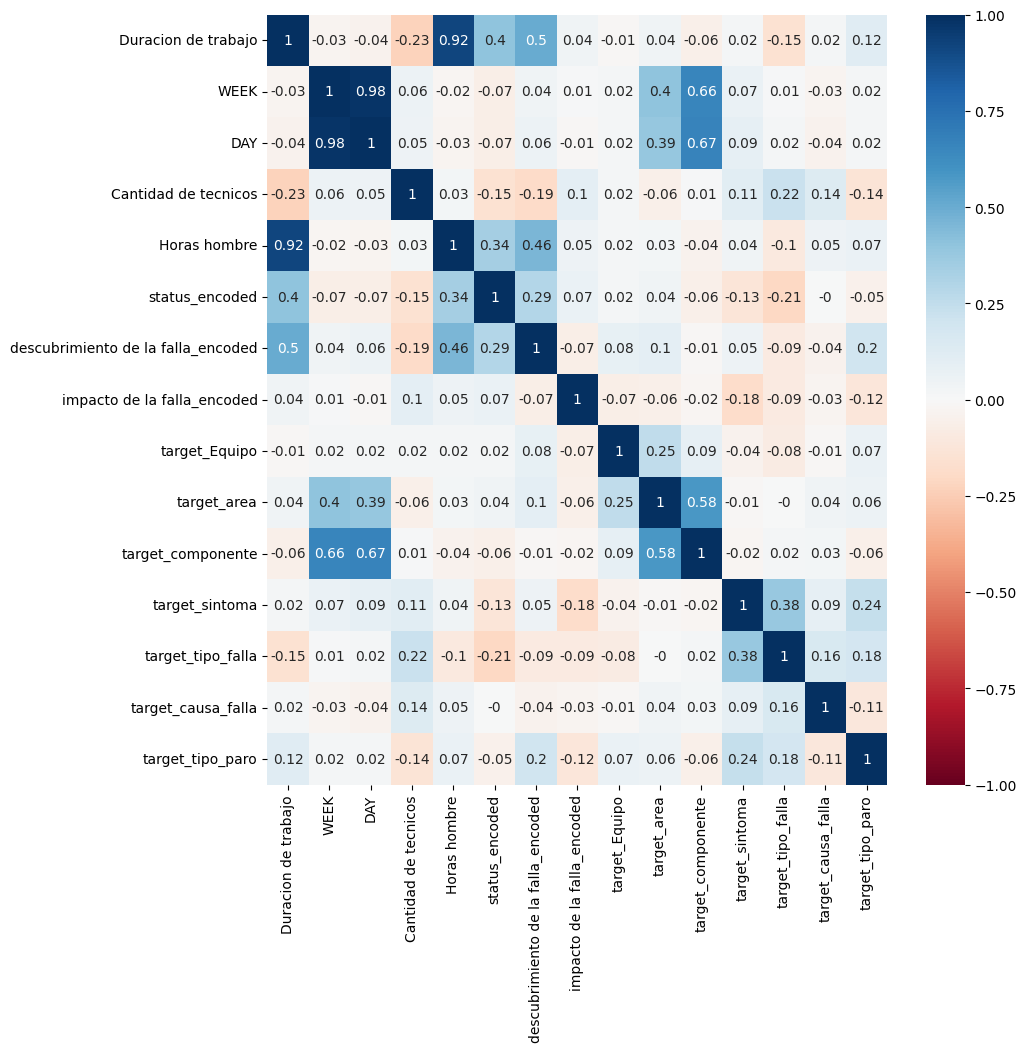

In [ ]:
correlacion = data_encoded.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlacion.round(2), vmin=-1, vmax=1,cmap='RdBu',annot=True)

Mediante este gráfico, nosotros queremos ver que variables (Columnas) tienen correlación con nuestro objetivo target_componente. Podemos inferir que tanto la variable target_area, week y day, tiene una alta incidencia.

5.1 Se copia del dataframe data_encoded para realizar una prueba utilizando el metodo K-means y visualizar la información segun componentes.

* Se quitan algunos outliers para ver una mejor distribución de nuestros datos y se grafica en un pairplot algunas variables de interés.

In [ ]:
data_prueba = data_prueba[(data_prueba['Duracion de trabajo'] > np.percentile(data_prueba['Duracion de trabajo'], 15)) & (data_prueba['Duracion de trabajo'] < np.percentile(data_prueba['Duracion de trabajo'], 85))]
data_prueba = data_prueba[(data_prueba['target_area'] > np.percentile(data_prueba['target_area'], 4)) & (data_prueba['target_area'] < np.percentile(data_prueba['target_area'], 96))]
#data_prueba = data_prueba[(data_prueba['target_Equipo'] > np.percentile(data_prueba['target_Equipo'], 5)) & (data_prueba['target_Equipo'] < np.percentile(data_prueba['target_Equipo'], 95))]
data_prueba = data_prueba[(data_prueba['Horas hombre'] > np.percentile(data_prueba['Horas hombre'], 15)) & (data_prueba['Horas hombre'] < np.percentile(data_prueba['Horas hombre'], 85))]
data_prueba = data_prueba[(data_prueba['DAY'] > np.percentile(data_prueba['DAY'], 15)) & (data_prueba['DAY'] < np.percentile(data_prueba['DAY'], 85))]


In [ ]:
data_prueba[['Duracion de trabajo', 'DAY',
       'Horas hombre', 'target_componente', 'target_area','target_sintoma']]

Duracion de trabajo   DAY  Horas hombre  target_componente  target_area  \
150             0.333333   6.0      1.333333                116           90   
151             0.316667   6.0      1.266667                 67           39   
152             0.533333   6.0      2.133333                117           91   
153             0.433333   6.0      1.733333                118           92   
154             0.666667   6.0      2.666667                100           81   
..                   ...   ...           ...                ...          ...   
688             1.000000  25.0      3.000000                 19           18   
689             1.000000  25.0      3.000000                 19           21   
691             1.500000  25.0      3.000000                 89           72   
694             0.833333  25.0      2.500000                289          103   
695             1.833333  25.0      7.333333                 48           44   

     target_sintoma  
150               5  
151               5  
152               5  
153               5  
154               5  
..              ...  
688               2  
689               2  
691               3  
694               1  
695               5  

[234 rows x 6 columns]

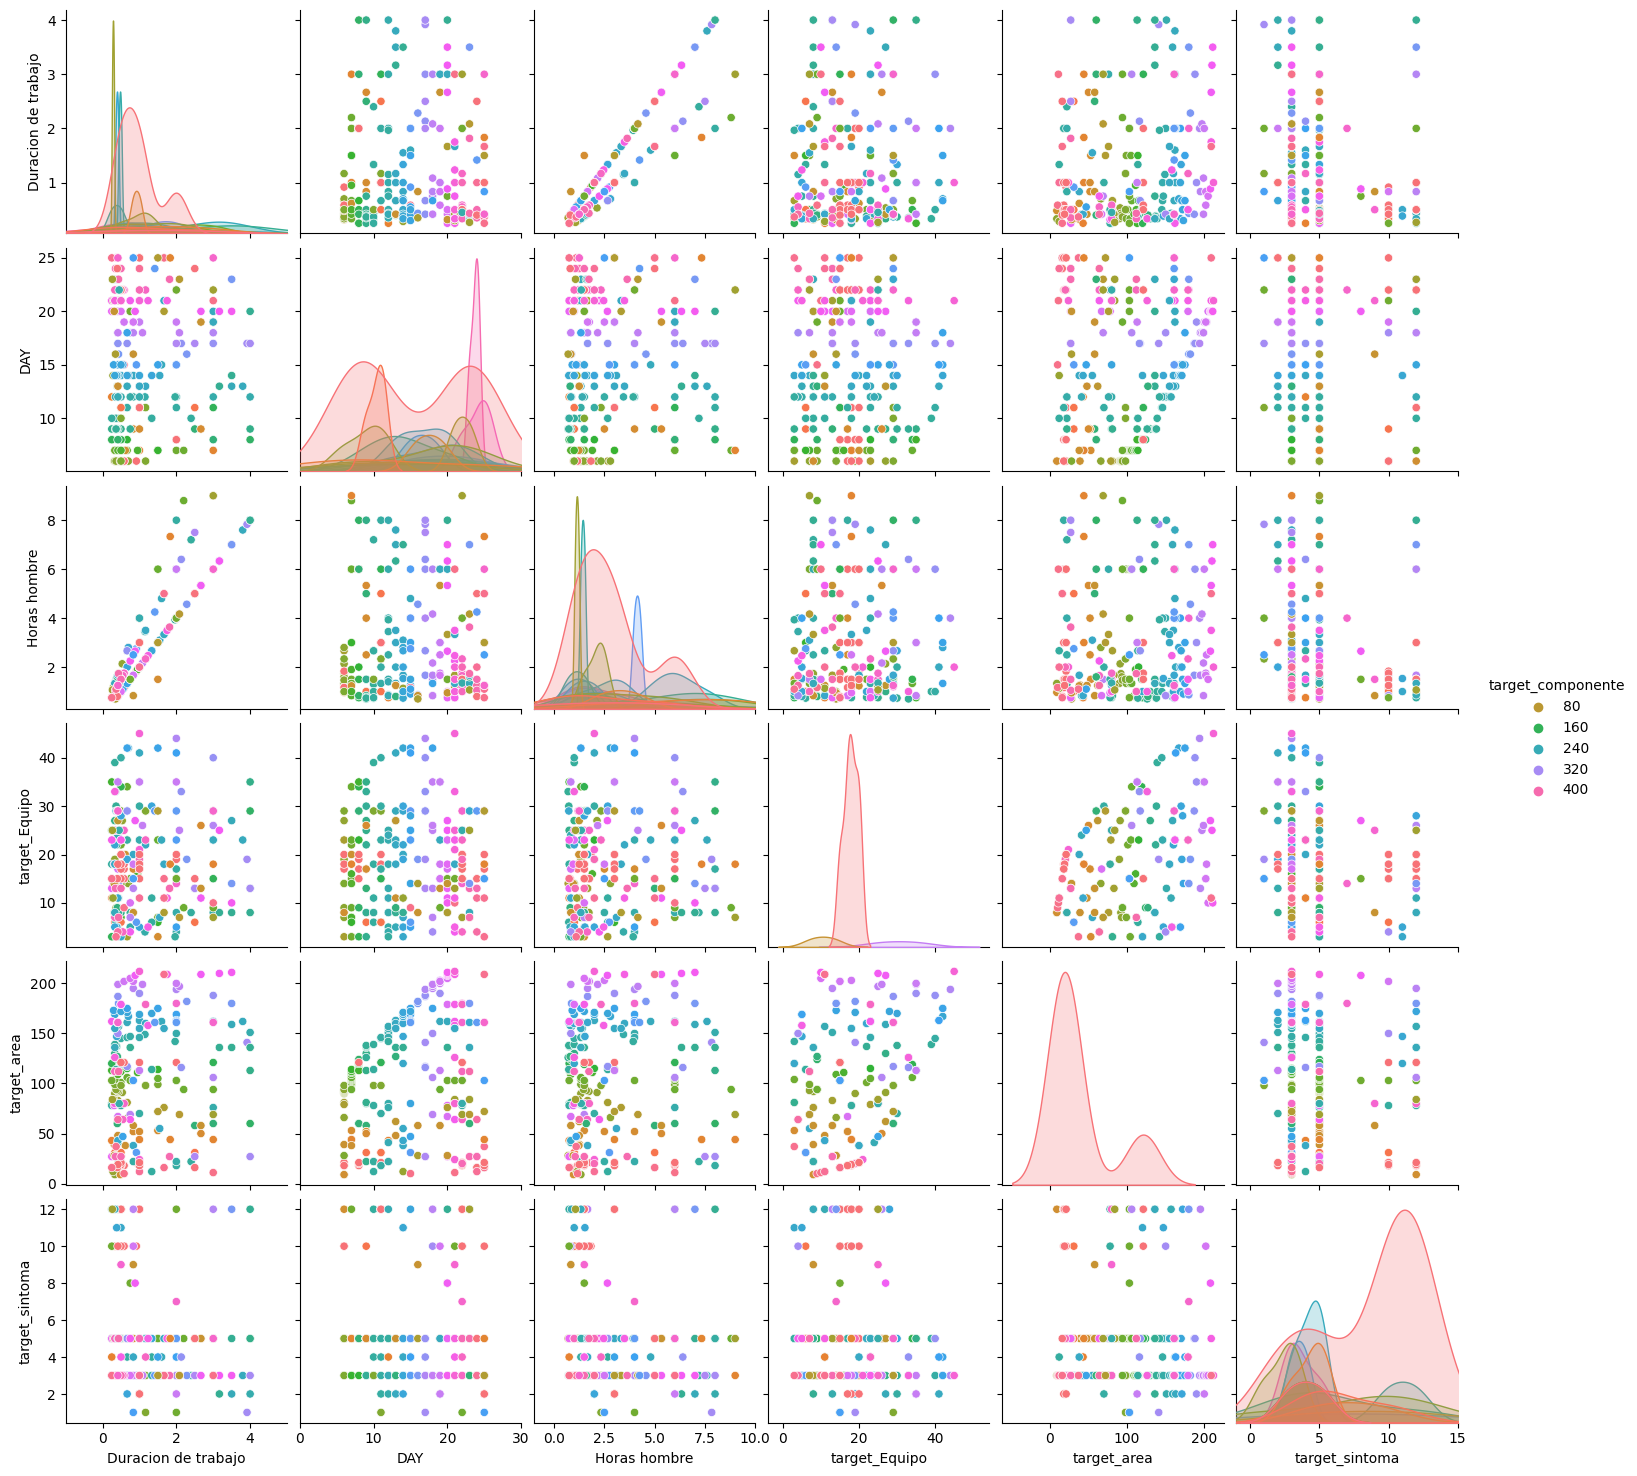

In [ ]:
pair_plot=sns.pairplot(data_prueba , vars=['Duracion de trabajo', 'DAY',
       'Horas hombre', 'target_Equipo', 'target_area','target_sintoma'], hue='target_componente', palette='husl')

# Se ajustan los límites en el eje x para cada columna
pair_plot.axes[0, 0].set_xlim(-1, 5)  # Duracion de trabajo
pair_plot.axes[1, 1].set_xlim(0, 30)  # DAY
pair_plot.axes[2, 2].set_xlim(-1, 10)  # Horas hombre
#pair_plot.axes[3, 3].set_xlim(-100, 550)  # target_componente
#pair_plot.axes[4, 4].set_xlim(-50, 250)  # target_area
pair_plot.axes[5, 5].set_xlim(-1, 15)  # target_sintoma

plt.show()

* Estandarizamos las variables

In [ ]:
scaler = StandardScaler()
data_prueba = pd.DataFrame(scaler.fit_transform(data_prueba), columns = data_prueba.columns)

## Reducción de dimensionalidad

* Entrenamos un modelo de PCA y retenemos todas las componentes principales

In [ ]:
pca = PCA().fit(data_prueba)

* Una vez entrenado el objeto PCA, puede accederse a toda la información de las componentes creadas.

* **components_** contiene el valor de los loadings  ϕ que definen cada componente. Las filas se corresponden con las componentes principales (ordenadas de mayor a menor varianza explicada) y las columnas se corresponden con las variables de entrada.

In [ ]:
pca.components_.shape

(15, 15)

In [ ]:
componentes = pd.DataFrame(data= pca.components_, columns = data_prueba.columns, index = range(1,pca.components_.shape[0]+1))
componentes.head()

Duracion de trabajo      WEEK       DAY  Cantidad de tecnicos  \
1             0.363463  0.326977  0.332843             -0.249327   
2             0.440359 -0.378275 -0.359378             -0.162441   
3             0.041669  0.314048  0.335076              0.112102   
4             0.128376  0.245937  0.251228             -0.040781   
5             0.179277 -0.084296 -0.148445              0.036627   

   Horas hombre  status_encoded  descubrimiento de la falla_encoded  \
1      0.305677        0.302952                            0.263437   
2      0.441933        0.142836                            0.291143   
3      0.073456       -0.099738                            0.305434   
4      0.125976       -0.074867                           -0.040514   
5      0.192295        0.031646                           -0.251816   

   impacto de la falla_encoded  target_Equipo  target_area  target_componente  \
1                    -0.055047       0.147224     0.282447           0.335805   
2                     0.146226      -0.034393    -0.134910          -0.341554   
3                    -0.138467      -0.001645    -0.031589          -0.026386   
4                    -0.117601      -0.616386    -0.535293          -0.199009   
5                    -0.328649      -0.237112     0.198451           0.127683   

   target_sintoma  target_tipo_falla  target_causa_falla  target_tipo_paro  
1       -0.211271          -0.230104            0.038573         -0.130755  
2        0.067495           0.016829           -0.098541          0.187102  
3        0.496694           0.403359           -0.096001          0.476102  
4        0.003080          -0.167679           -0.006181         -0.295078  
5        0.094517           0.325569            0.707108         -0.033736

* La influencia de las variables en cada componente puede analizarse visualmente con un gráfico de tipo heatmap.

<Axes: >

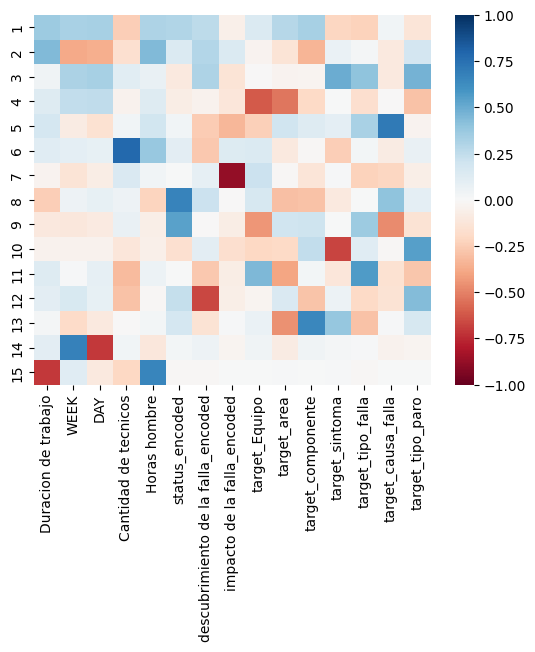

In [ ]:
sns.heatmap(componentes, vmin=-1, vmax=1, cmap='RdBu')

* Una vez calculadas las componentes principales, se puede conocer la varianza explicada por cada una de ellas, la proporción respecto al total y la proporción de varianza acumulada. Esta información está almacenada en los atributos explained_variance_ y explained_variance_ratio_ del modelo.

In [ ]:
var_explicada=pca.explained_variance_ratio_

Text(0.5, 0, 'Componente Principal')

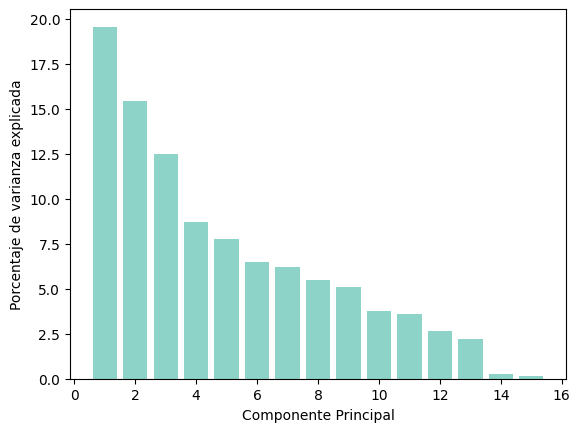

In [ ]:
plt.bar(x=componentes.index, height = var_explicada*100)
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componente Principal')

(0.0, 105.0)

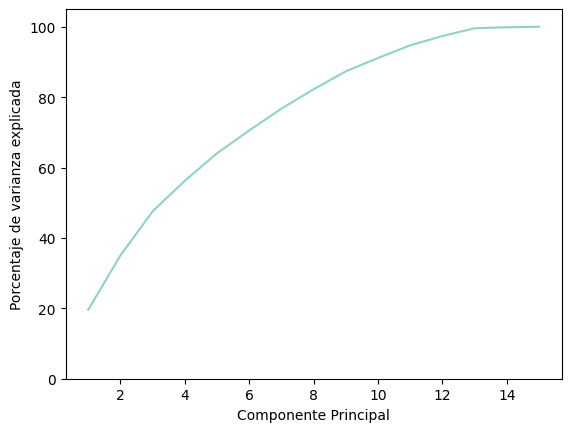

In [ ]:
plt.plot(componentes.index,var_explicada.cumsum()*100)
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componente Principal')
plt.ylim(0,105)

* Si decidimos guardarnos las primeras 4 CPs, sólo estaríamos salvando el 60% de la varianza observada en los clientes. Guardando las primeras 6 CPs, nos quedamos con alrededor del 75% de la varianza.

* ¿Cuáles son las variables más importantes? Serán aquellas con los mayores loadings en las CP que mayor cantidad de varianza expliquen.

In [ ]:
componentes.iloc[:6].abs().sum().sort_values()[::-1]

Horas hombre                          1.515325
DAY                                   1.508890
WEEK                                  1.444516
descubrimiento de la falla_encoded    1.420247
Cantidad de tecnicos                  1.390053
target_area                           1.277322
Duracion de trabajo                   1.277211
target_tipo_paro                      1.193354
target_Equipo                         1.180353
target_tipo_falla                     1.172147
target_sintoma                        1.121470
target_componente                     1.039021
target_causa_falla                    1.029084
impacto de la falla_encoded           0.923149
status_encoded                        0.755780
dtype: float64

* Para obtener las nuevas variables se utiliza **.transform** y podemos seleccionar las componentes principales que deseamos.

In [ ]:
data_prueba=pca.transform(data_prueba)
data_prueba=pd.DataFrame(data_prueba[:,:6], columns=range(1,7))
data_prueba.head()

1         2         3         4         5         6
0 -2.647376  0.082552 -0.834670 -0.842018  0.183655  1.137115
1 -3.207796  0.356336 -0.797900  0.380825  0.217311  1.047316
2 -2.161774  0.290512 -1.100738 -1.156338 -0.138800  1.395696
3 -2.703139  0.237500 -0.816469 -0.137847  0.511436  1.055657
4 -2.491430  0.615021 -1.063826  0.513865  0.459829  1.172406

* Entonces ahora las variables independientes son nuestras componentes principales y cada registro (tarea de mantenimiento), tiene un valor para cada componente.

## Clustering

* Se grafica para ver si se pueden reconocer grupos fácilmente:

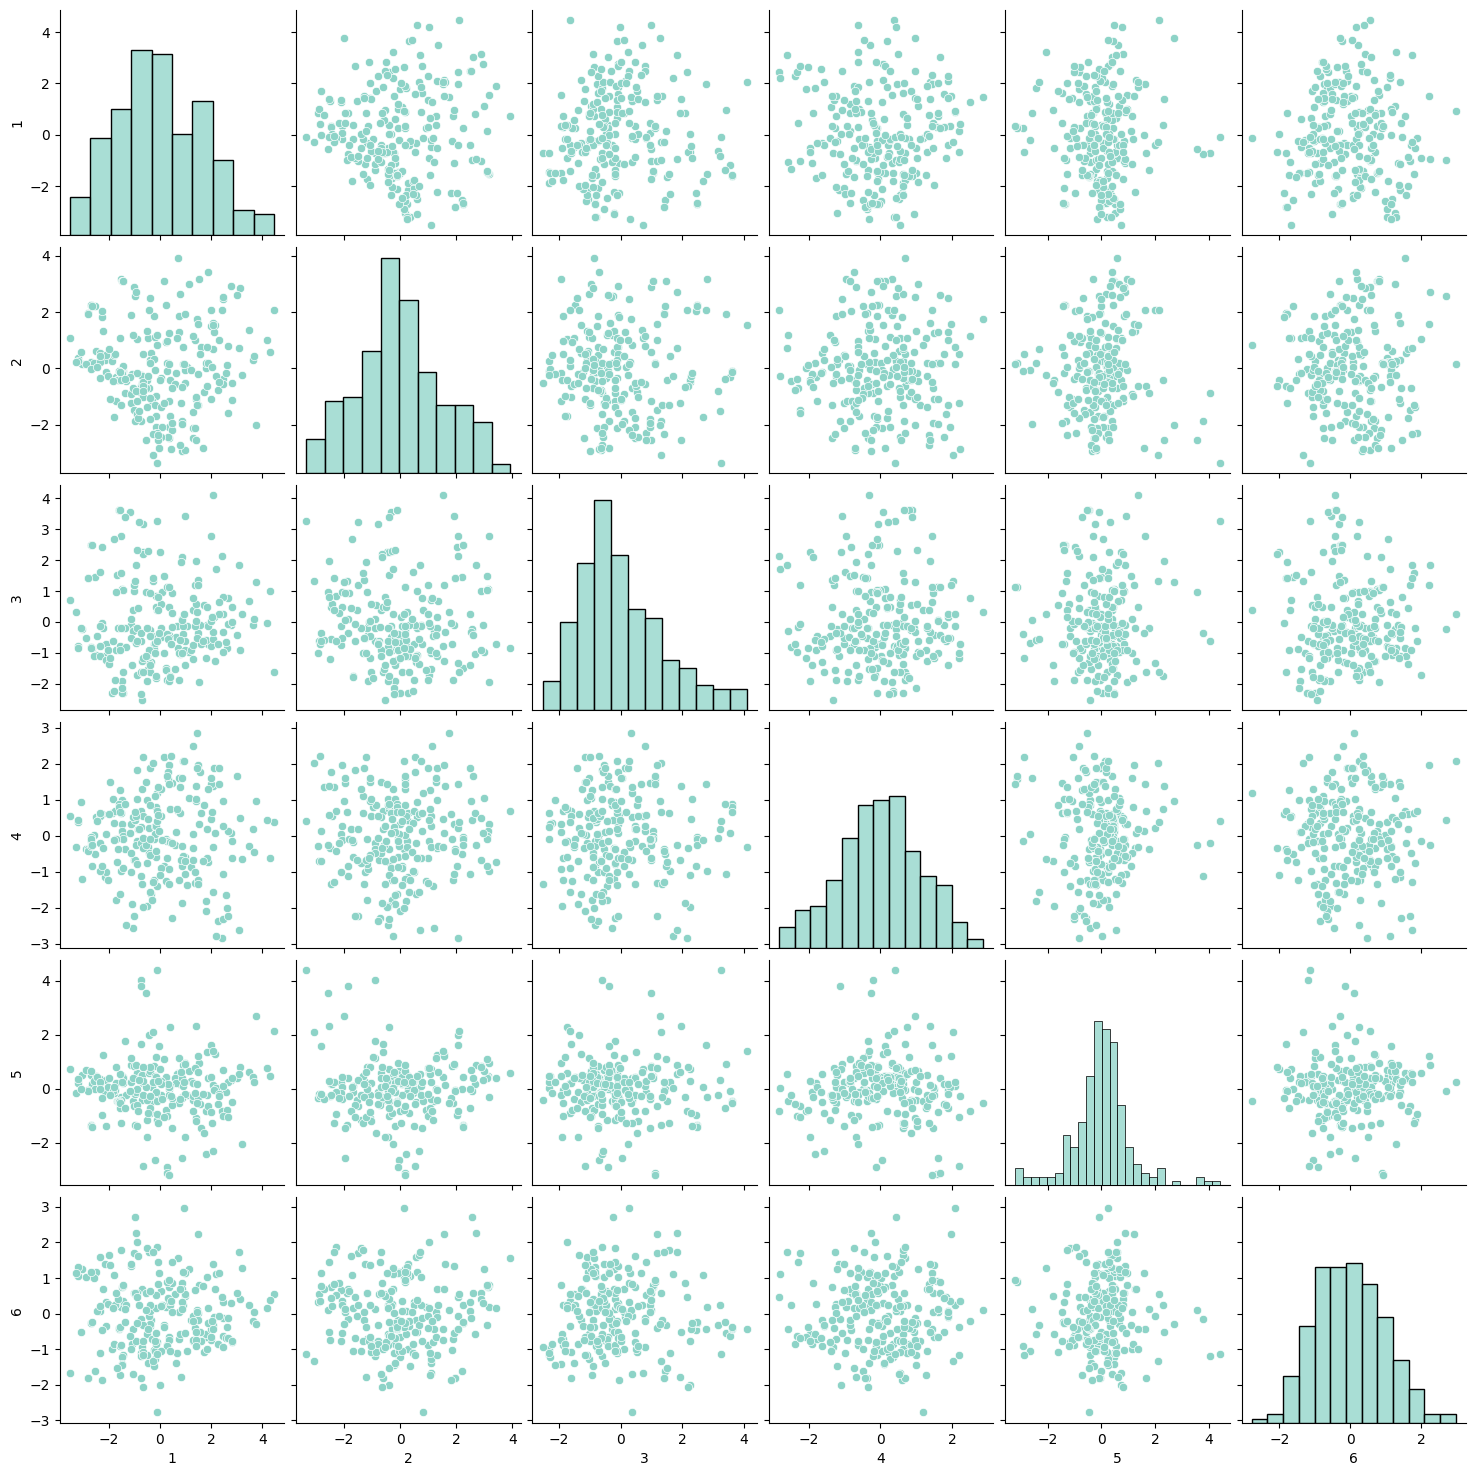

In [ ]:
sns.pairplot(data_prueba)

# Kmeans

A.
*  Se utiliza la funcion **Kmeans** de **"sklearn.cluster"**, se entrena diferentes modelos con distintos números de K.

*  Se contabiliza la distancia promedio en cada cluster a partir del atributo **interia_** del modelo.

*  Se arma un gráfico de lineas donde se aprecia cómo varía esa cantidad en función de la cantidad de clústers.


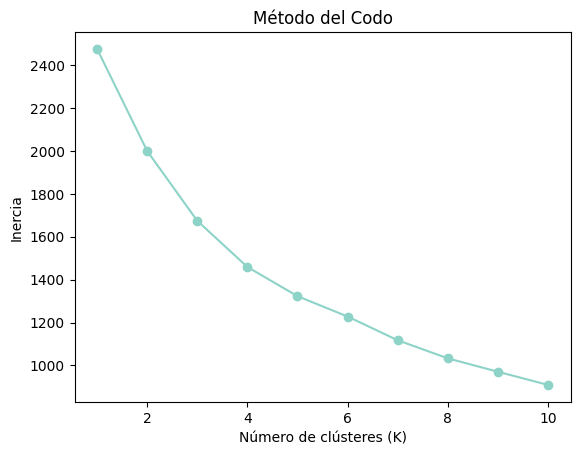

In [ ]:
X=data_prueba

inertia = []

max_clusters = 10

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Inercia')
plt.show()

B.
*  Se repite el análisis considerando el Silhouette Score:
*  Se utiliza la función **"Silhouette_score"** de **"sklearn.metrics"**
*  Se calcula dicha cantidad para cada K y se grafica.



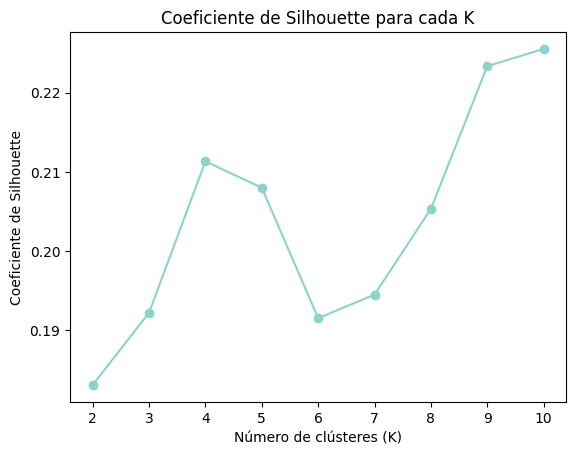

In [ ]:
silhouette_scores = []

max_clusters = 10

for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    silhouette = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Coeficiente de Silhouette para cada K')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Coeficiente de Silhouette')
plt.show()

C.
*  Se repite el análisis considerando el Davies-Bouldin Index:
*  Se utiliza la función **"davies_bouldin_score"** de **"sklearn.metrics"**
*  Se calcula dicha cantidad para cada K y se grafica.

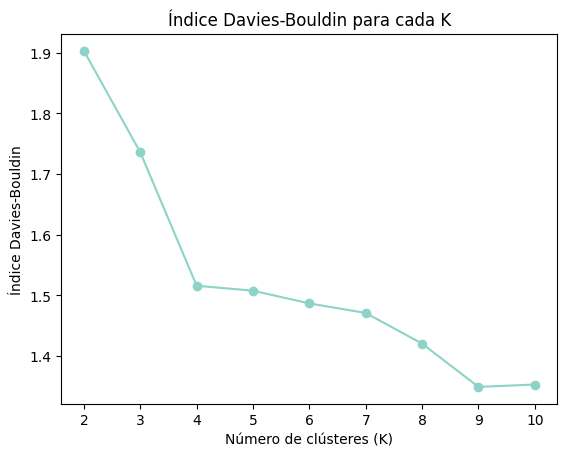

In [ ]:
davies_bouldin_scores = []

max_clusters = 10

for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    davies_bouldin = davies_bouldin_score(X, kmeans.labels_)
    davies_bouldin_scores.append(davies_bouldin)

plt.plot(range(2, max_clusters + 1), davies_bouldin_scores, marker='o')
plt.title('Índice Davies-Bouldin para cada K')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice Davies-Bouldin')
plt.show()

D.
*  Hacemos el gráfico de Silhouette scores para diferentes números de clúster, determinando utilizar 4 clústers.

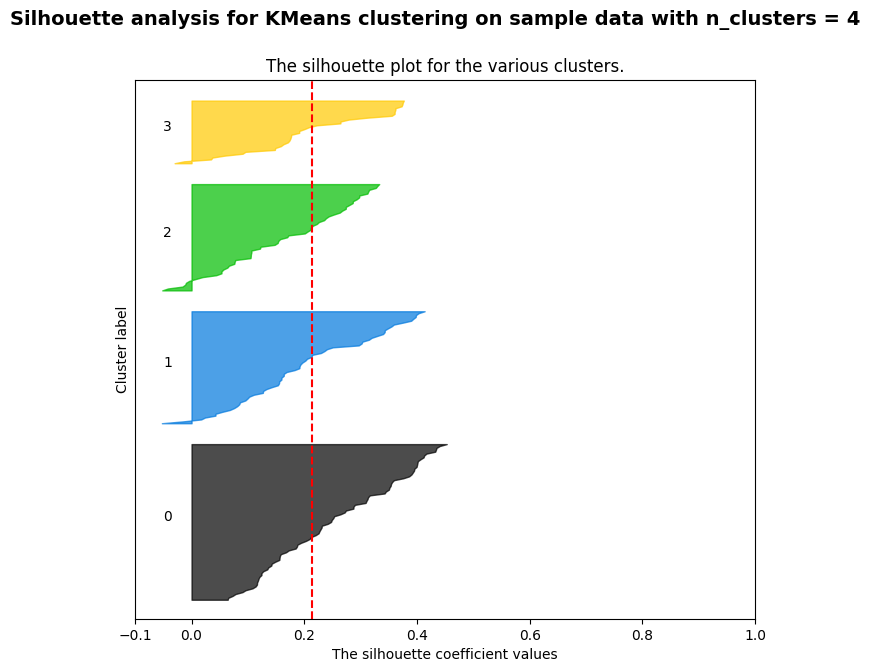

In [ ]:
n_clusters=4

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 7)

ax1.set_xlim([-0.1, 1])

ax1.set_ylim([0, len(data_prueba) + (n_clusters + 1) * 10])

clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
cluster_labels = clusterer.fit_predict(data_prueba)
silhouette_avg = silhouette_score(data_prueba, cluster_labels)

sample_silhouette_values = silhouette_samples(data_prueba, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7,)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold",)

plt.show()

Para n_clusters = 2 El promedio del score de silhouette es:  0.19075363535539747
Para n_clusters = 3 El promedio del score de silhouette es:  0.19179487549954052
Para n_clusters = 4 El promedio del score de silhouette es:  0.21161760413479444
Para n_clusters = 5 El promedio del score de silhouette es:  0.21376287918820353
Para n_clusters = 6 El promedio del score de silhouette es:  0.2128694892403807
Para n_clusters = 7 El promedio del score de silhouette es:  0.21312262523507952
Para n_clusters = 8 El promedio del score de silhouette es:  0.21484854051700775
Para n_clusters = 9 El promedio del score de silhouette es:  0.21321648166555207


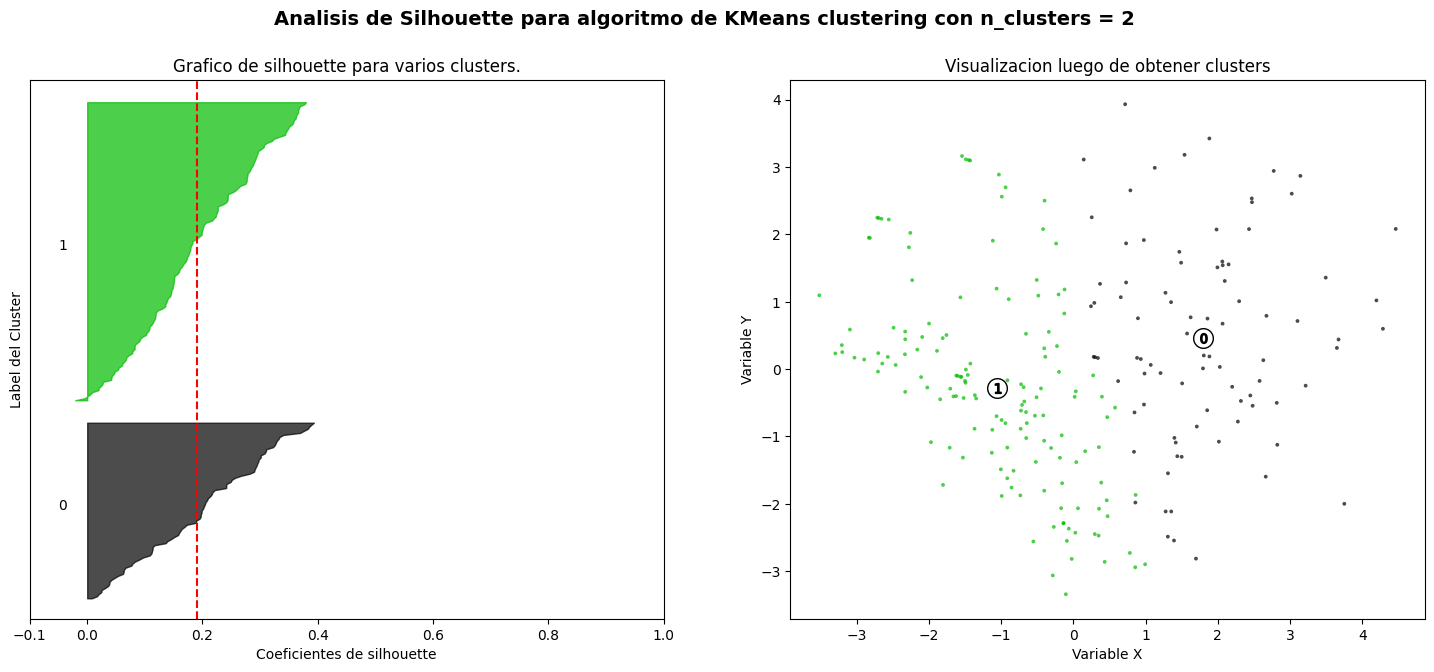

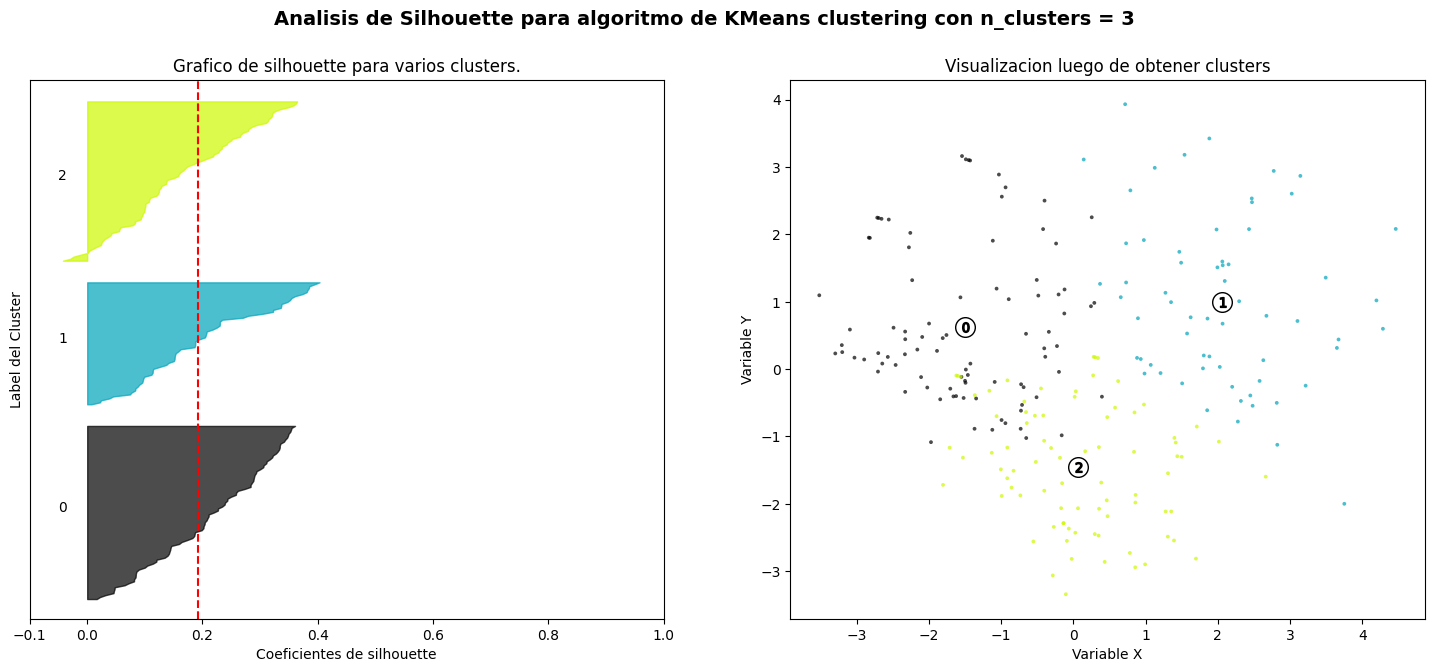

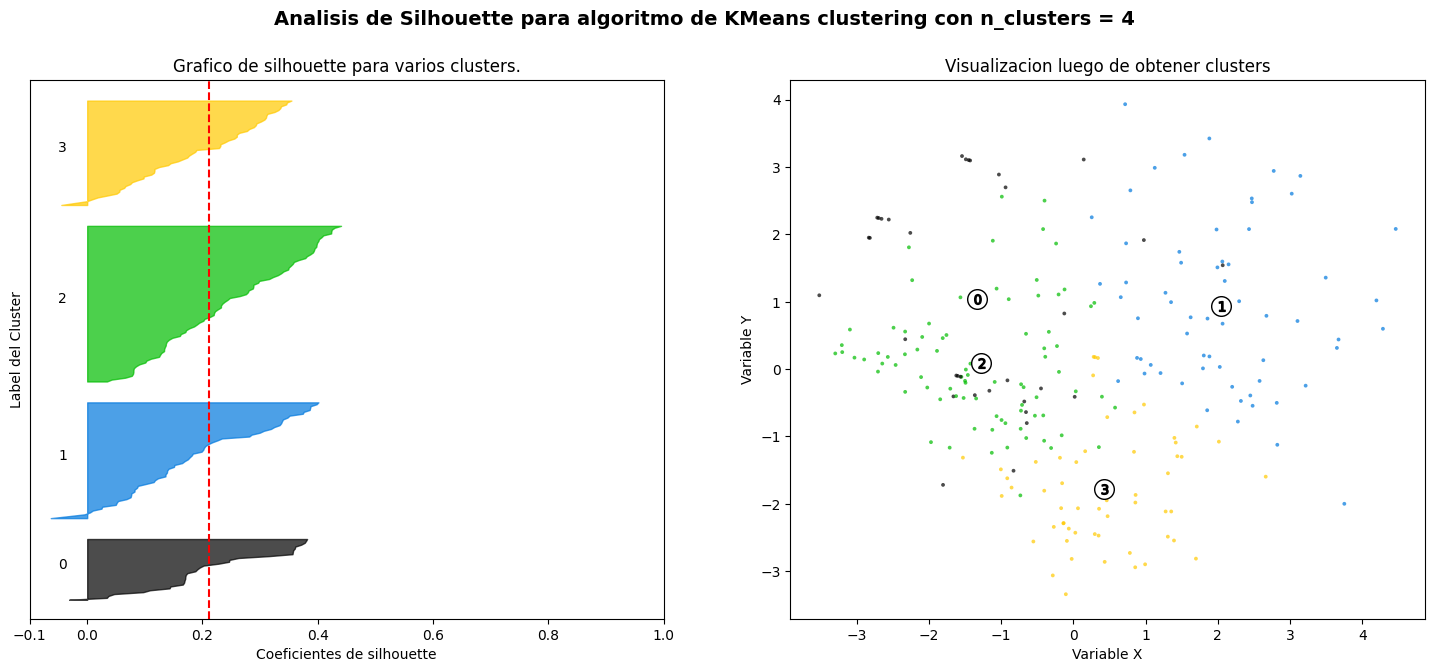

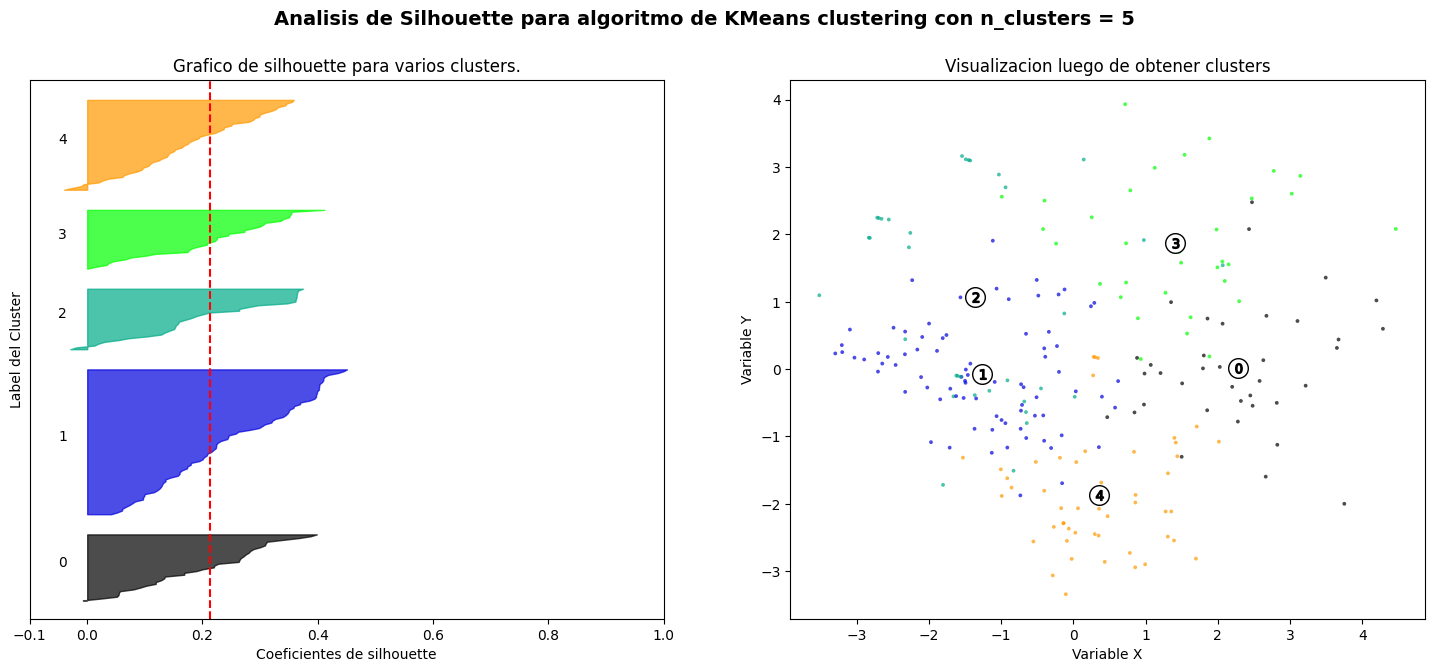

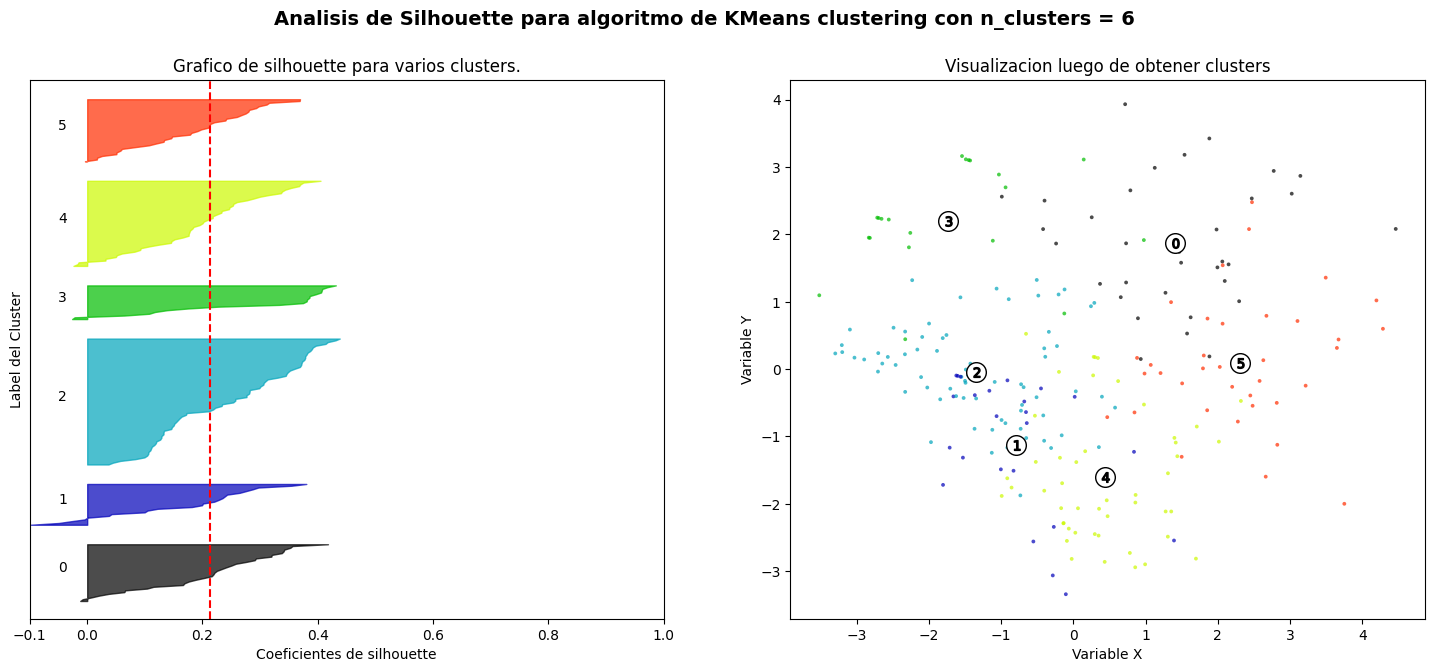

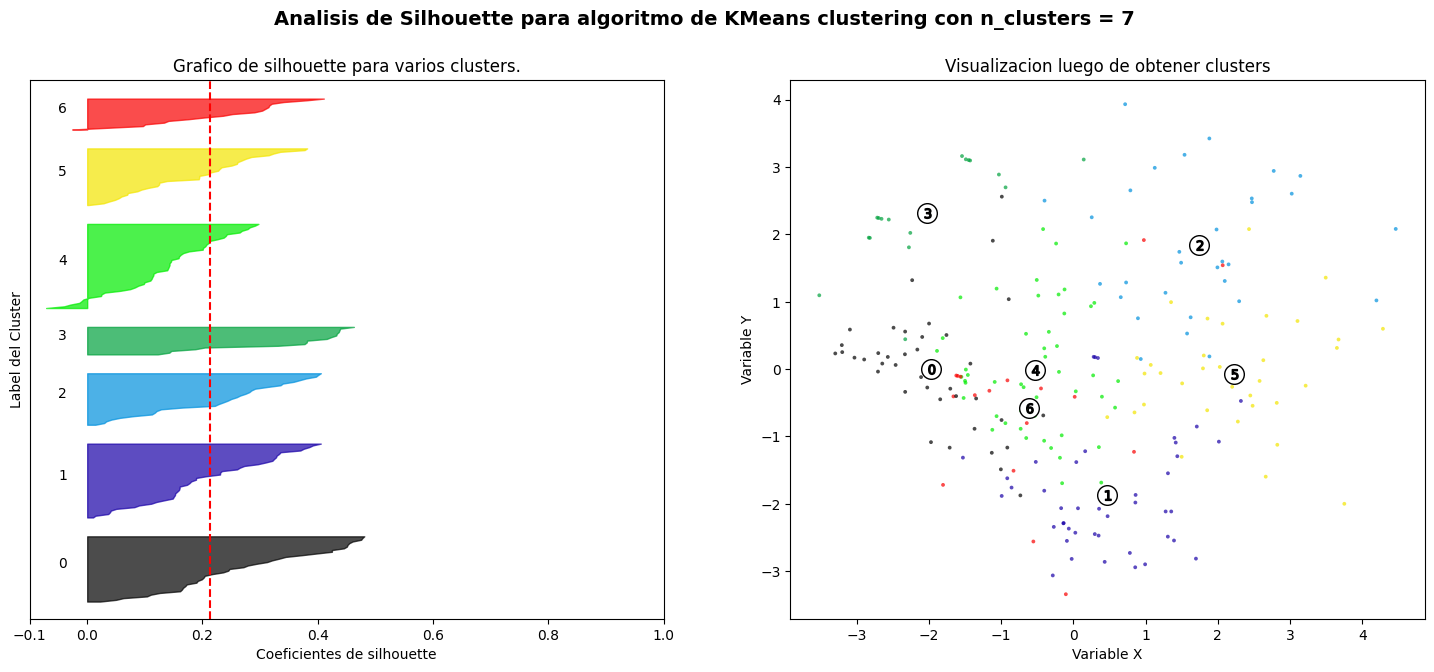

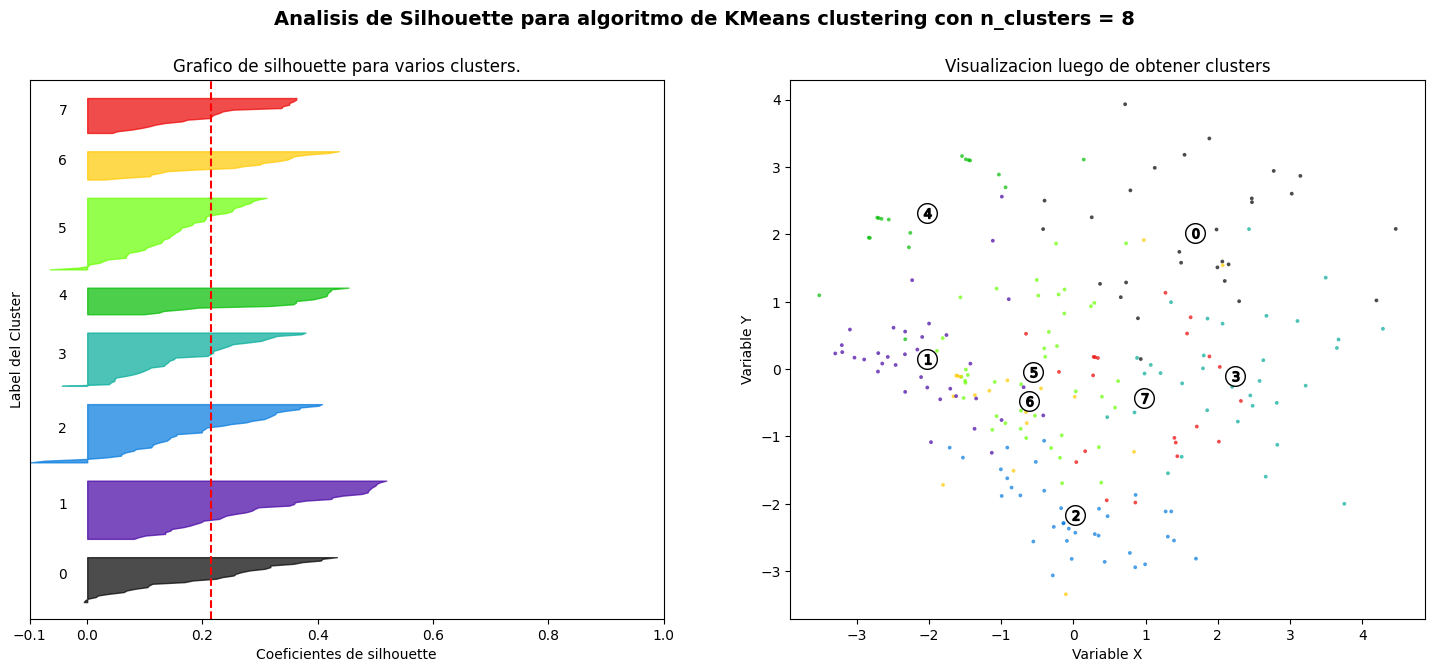

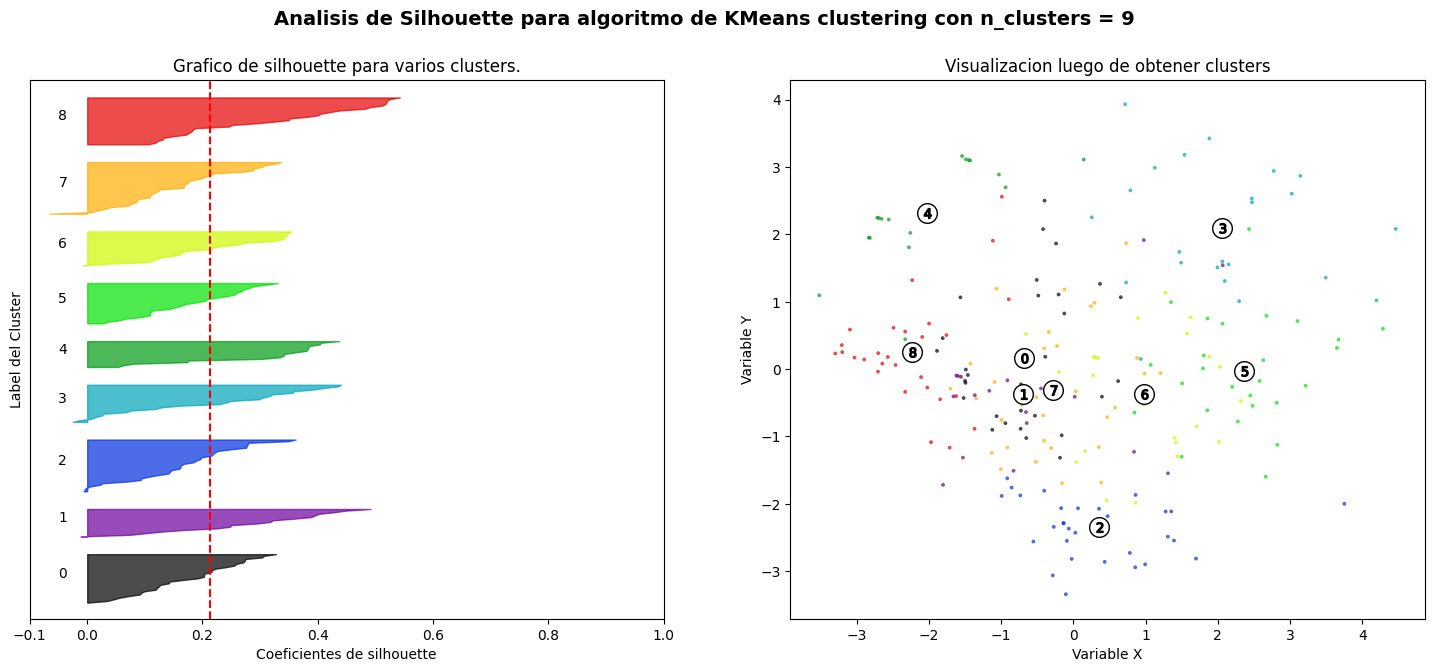

In [ ]:
X = data_prueba.values

for n_clusters in range(2, 10):
    # Se crea un subplot de 1 fila y 2 columnas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # El 1 subplot es para el score de silhouette
    # El rango del Ind. silhouette es [-1, 1]
    ax1.set_xlim([-0.1, 1]) # para nuestro caso lo voy a dejar en este rango
    # El (n_clusters+1)*10 es para insertar un espacio en blanco entre la silueta
     # y el grafico de la nube de puntos
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Iniciamos el proceso de ajuste a los datos
    clusterer = KMeans(n_clusters=n_clusters,max_iter=1000, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    # El score de silhouette_score da el promedio de todos los valores
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El promedio del score de silhouette es: ", silhouette_avg)
    # Se calcula el score de silhouette para cada muestra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Se agregan los scores de silhouette para las muestras pertenecientes al cluster i y ordenarlos
        ith_cluster_silhouette_values =sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort() # Ordenar
        size_cluster_i = ith_cluster_silhouette_values.shape[0] # Tamaño de clusters
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters) # Se Define paleta de colores
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Se etiqueta las graficas de silhouette con sus miembros de cluster en el medio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Se Calcula el nuevo y_lower para la proxima grafica
        y_lower = y_upper + 10
    ax1.set_title("Grafico de silhouette para varios clusters.")
    ax1.set_xlabel("Coeficientes de silhouette")
    ax1.set_ylabel("Label del Cluster")
    # La linea vertical para el promedio del score de silhouette de todos los valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Se quita labels en y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]) # Se define ticks para comparacion

    # 2 se grafica mostrando los clusters formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters) # Se define colores
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k') # scatterplot
    # Se etiqueta a los clusters
    centers = clusterer.cluster_centers_
    # Se Dibuja en color blanco los centroides de los clusters
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')
    # Se enumeran los centroides
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

    ax2.set_title("Visualizacion luego de obtener clusters")
    ax2.set_xlabel("Variable X")
    ax2.set_ylabel("Variable Y")

    plt.suptitle(("Analisis de Silhouette para algoritmo de KMeans clustering "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

E.
* Se elije el K óptimo, se entrena el modelo de clustering y se repite el pairplot diferenciando por clusters (utiliza el atributo "hue") y los labels del modelo (modelo.labels_)


<Figure size 640x480 with 0 Axes>

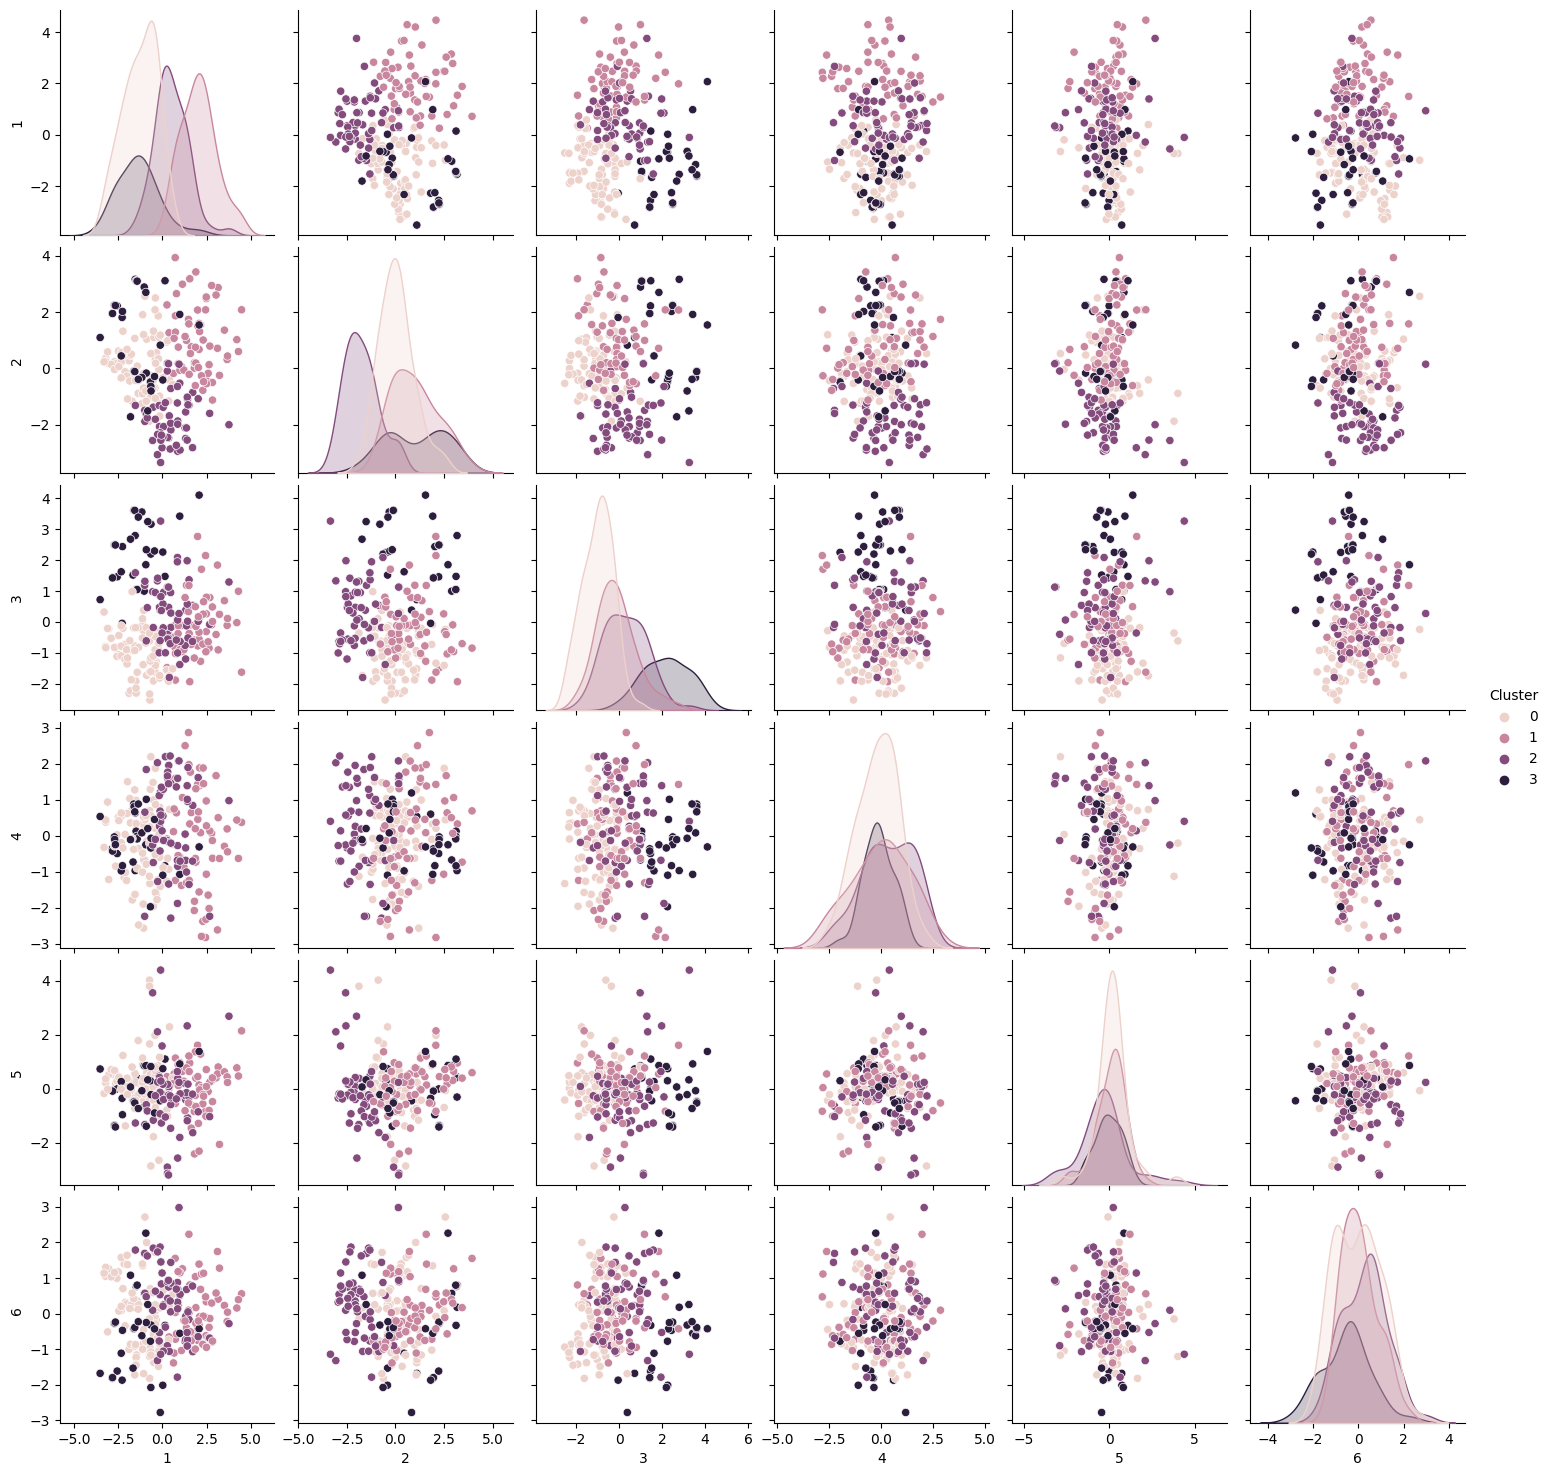

In [ ]:
n_clusters = 4

clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
cluster_labels = clusterer.fit_predict(data_prueba)

data_with_clusters = data_prueba.copy()
data_with_clusters['Cluster'] = cluster_labels

plt.figure()
sns.pairplot(data_with_clusters, hue='Cluster')
plt.show()

### DBSCAN

*  Se realiza una doble búsqueda de los mejores "eps" y "min_samples" para que el modelo DBSCAN tenga el mayor Silhouette Score posible.

In [ ]:
best_score = -1
best_eps = 0
best_min_samples = 0

eps_range = np.linspace(0.1, 2.0, num=10)
min_samples_range = range(2, 10)

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X)
        if len(set(cluster_labels)) > 1:
            silhouette = silhouette_score(X, cluster_labels)
            if silhouette > best_score:
                best_score = silhouette
                best_eps = eps
                best_min_samples = min_samples

print(f"Mejor Silhouette Score: {best_score}")
print(f"Mejor valor de eps: {best_eps}")
print(f"Mejor valor de min_samples: {best_min_samples}")


Mejor Silhouette Score: 0.11533667896739218
Mejor valor de eps: 2.0
Mejor valor de min_samples: 8


*  Se repite el pairplot con esta nueva clusterización.

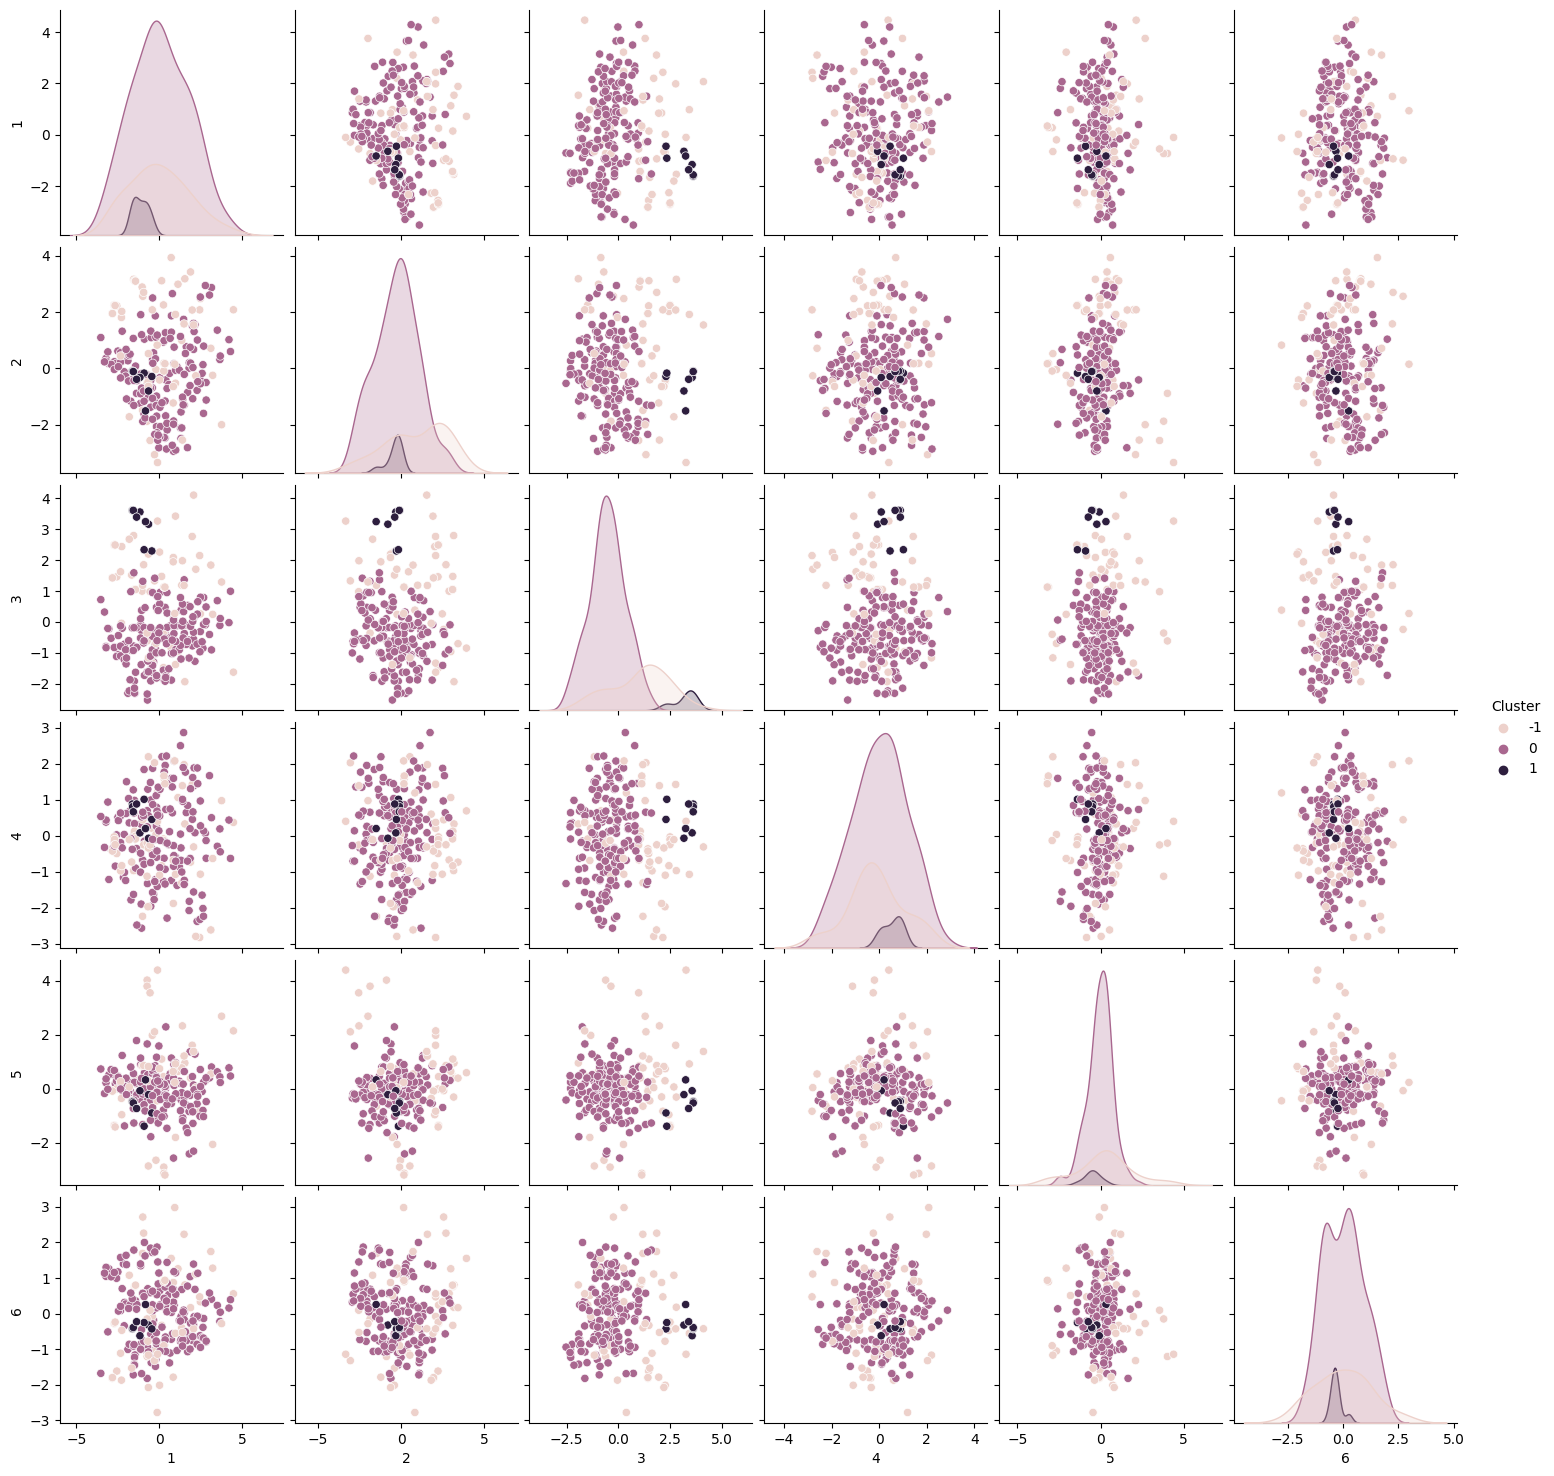

In [ ]:
selected_variables= [1,2,3,4,5,6]

data_selected = data_prueba[selected_variables].copy()
data_selected['Cluster'] = cluster_labels

sns.pairplot(data_selected, hue='Cluster')
plt.show()



El uso de DBSCAN con los parámetros encontrados (eps=2.0, min_samples=8) ha producido un silhouette score de aproximadamente 0.115. A pesar de realizar un proceso de búsqueda de hiperparámetros, este resultado sugiere que DBSCAN puede no ser la elección más adecuada para el conjunto de datos en cuestión.

El silhouette score proporciona una medida de cuán bien definidos están los clusters identificados por el algoritmo de clustering. En este caso, el valor de 0.115 indica que los clusters encontrados por DBSCAN no están claramente separados, lo que puede limitar la utilidad práctica del método. La baja cohesión y la posible superposición entre clusters podrían dificultar la interpretación y aplicación de los resultados obtenidos.

---

# Feature Selection para Regresión Lineal

6. Se prueban distintas opciones para encontrar las mejores features del dataframe data_encoded desde un forward selection

In [ ]:
x = data_encoded.drop('target_componente', axis=1)
y = data_encoded['target_componente']

In [ ]:
best_features, pvals = forward_selection(x,y,significance_level=0.05)

['DAY'] 1.7772513089508744e-112
['DAY', 'target_area'] 1.4931216364062288e-46
['DAY', 'target_area', 'target_tipo_paro'] 1.7177500906733374e-05
['DAY', 'target_area', 'target_tipo_paro', 'descubrimiento de la falla_encoded'] 0.011066942656554866


In [ ]:
x = data_encoded.drop('target_area', axis=1)
y = data_encoded['target_area']
best_features, pvals = forward_selection(x,y,significance_level=0.05)

['target_componente'] 1.1131753012026673e-77
['target_componente', 'target_Equipo'] 1.3105854744259556e-12
['target_componente', 'target_Equipo', 'descubrimiento de la falla_encoded'] 0.0009555373603532114
['target_componente', 'target_Equipo', 'descubrimiento de la falla_encoded', 'target_tipo_paro'] 0.014507046747771693
['target_componente', 'target_Equipo', 'descubrimiento de la falla_encoded', 'target_tipo_paro', 'status_encoded'] 0.04582697985761963


In [ ]:
x = data_encoded.drop('status_encoded', axis=1)
y = data_encoded['status_encoded']
best_features, pvals = forward_selection(x,y,significance_level=0.05)

['Duracion de trabajo'] 2.102430040930191e-34
['Duracion de trabajo', 'target_tipo_falla'] 1.0598061376110065e-06
['Duracion de trabajo', 'target_tipo_falla', 'descubrimiento de la falla_encoded'] 0.0008505620127705809
['Duracion de trabajo', 'target_tipo_falla', 'descubrimiento de la falla_encoded', 'target_sintoma'] 0.002372144023691005
['Duracion de trabajo', 'target_tipo_falla', 'descubrimiento de la falla_encoded', 'target_sintoma', 'target_tipo_paro'] 0.018808771119743876
['Duracion de trabajo', 'target_tipo_falla', 'descubrimiento de la falla_encoded', 'target_sintoma', 'target_tipo_paro', 'Horas hombre'] 0.03888575889222557


In [ ]:
x = data_encoded.drop('target_sintoma', axis=1)
y = data_encoded['target_sintoma']
best_features, pvals = forward_selection(x,y,significance_level=0.05)

['target_tipo_falla'] 5.527955719335989e-30
['target_tipo_falla', 'target_tipo_paro'] 1.5053650451239678e-08
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded'] 3.3832644936081046e-05
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded', 'Cantidad de tecnicos'] 0.013803161620505171
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded', 'Cantidad de tecnicos', 'Duracion de trabajo'] 0.01598705980111433
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded', 'Cantidad de tecnicos', 'Duracion de trabajo', 'DAY'] 0.019032649474320373
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded', 'Cantidad de tecnicos', 'Duracion de trabajo', 'DAY', 'target_componente'] 0.006142919034041883
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded', 'Cantidad de tecnicos', 'Duracion de trabajo', 'DAY', 'target_componente', 'status_encoded'] 0.035112255775957016


In [ ]:
x = data_encoded.drop('target_tipo_falla', axis=1)
y = data_encoded['target_tipo_falla']
best_features, pvals = forward_selection(x,y,significance_level=0.05)

['target_sintoma'] 5.5279557193361466e-30
['target_sintoma', 'Cantidad de tecnicos'] 1.6821662516026042e-08
['target_sintoma', 'Cantidad de tecnicos', 'status_encoded'] 5.586458948043487e-06
['target_sintoma', 'Cantidad de tecnicos', 'status_encoded', 'target_tipo_paro'] 9.378091342405964e-05
['target_sintoma', 'Cantidad de tecnicos', 'status_encoded', 'target_tipo_paro', 'target_causa_falla'] 0.00010066176364244541
['target_sintoma', 'Cantidad de tecnicos', 'status_encoded', 'target_tipo_paro', 'target_causa_falla', 'Duracion de trabajo'] 0.0021232504303511186
['target_sintoma', 'Cantidad de tecnicos', 'status_encoded', 'target_tipo_paro', 'target_causa_falla', 'Duracion de trabajo', 'target_Equipo'] 0.0072922253094374065


6.1 Se utiliza backward selection

In [ ]:
best_features, worst_features, pvals_worst_features=backward_elimination(x,y, significance_level=0.05)

['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'status_encoded', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_area', 'target_sintoma', 'target_tipo_falla', 'target_tipo_paro'] 0.9562249522173363
['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'status_encoded', 'descubrimiento de la falla_encoded', 'target_Equipo', 'target_area', 'target_sintoma', 'target_tipo_falla', 'target_tipo_paro'] 0.6740175180395487
['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'status_encoded', 'target_Equipo', 'target_area', 'target_sintoma', 'target_tipo_falla', 'target_tipo_paro'] 0.6715313514364759
['Duracion de trabajo', 'WEEK', 'DAY', 'Horas hombre', 'status_encoded', 'target_Equipo', 'target_area', 'target_sintoma', 'target_tipo_falla', 'target_tipo_paro'] 0.5402108116288968
['Duracion de trabajo', 'WEEK', 'DAY', 'status_encoded', 'target_Equipo', 'target_area', 

In [ ]:
best_features, worst_features, pvals_worst_features=backward_elimination(x,y, significance_level=0.05)

['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'status_encoded', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_componente', 'target_tipo_falla', 'target_causa_falla', 'target_tipo_paro'] 0.8394369900611823
['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'status_encoded', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_componente', 'target_causa_falla', 'target_tipo_paro'] 0.6650561202828937
['WEEK', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'status_encoded', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_componente', 'target_causa_falla', 'target_tipo_paro'] 0.5995368356202384
['WEEK', 'DAY', 'Cantidad de tecnicos', 'status_encoded', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_componente', 'target_causa_falla', 'target_tipo_paro'] 

In [ ]:
best_features, worst_features, pvals_worst_features=backward_elimination(x,y, significance_level=0.05)

['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_area', 'target_componente', 'target_sintoma', 'target_tipo_falla', 'target_causa_falla', 'target_tipo_paro'] 0.9723783602859235
['Duracion de trabajo', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_area', 'target_componente', 'target_sintoma', 'target_tipo_falla', 'target_causa_falla', 'target_tipo_paro'] 0.9530358781268341
['Duracion de trabajo', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_area', 'target_componente', 'target_sintoma', 'target_tipo_falla', 'target_tipo_paro'] 0.7193419377641885
['Duracion de trabajo', 'DAY', 'Horas hombre', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_area', 'target_componente', 'target_sintoma', 'target_tipo_fal

In [ ]:
best_features, worst_features, pvals_worst_features=backward_elimination(x,y, significance_level=0.05)

['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'status_encoded', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_componente', 'target_tipo_falla', 'target_causa_falla', 'target_tipo_paro'] 0.8394369900611474
['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'status_encoded', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_componente', 'target_tipo_falla', 'target_causa_falla', 'target_tipo_paro'] 0.715300465220904
['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'status_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_componente', 'target_tipo_falla', 'target_causa_falla', 'target_tipo_paro'] 0.5671042426871746
['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'status_encoded', 'impacto de la falla_encoded', 'target_componente', 'target_tipo_falla', 'target_causa_falla', 'target_tipo_paro'] 0.397498151621219

In [ ]:
best_features, worst_features, pvals_worst_features=backward_elimination(x,y, significance_level=0.05)

['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'status_encoded', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_area', 'target_componente', 'target_sintoma', 'target_causa_falla', 'target_tipo_paro'] 0.8905956373750445
['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'status_encoded', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_componente', 'target_sintoma', 'target_causa_falla', 'target_tipo_paro'] 0.6338258724508091
['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'status_encoded', 'descubrimiento de la falla_encoded', 'target_Equipo', 'target_componente', 'target_sintoma', 'target_causa_falla', 'target_tipo_paro'] 0.5579205433486298
['Duracion de trabajo', 'WEEK', 'DAY', 'Cantidad de tecnicos', 'status_encoded', 'target_Equipo', 'target_componente', 'target_sintoma', 'target_causa_falla', 'target_tipo_paro'] 0.5709628968127713
['Duracion de tra

6.2 Se utiliza stepwise:

In [ ]:
best_features=stepwise_selection(x,y,SL_in=0.05,SL_out = 0.05)

['DAY'] 1.7772513089508744e-112
['DAY', 'target_area'] 1.4931216364062288e-46
['DAY', 'target_area', 'target_tipo_paro'] 1.7177500906733374e-05
['DAY', 'target_area', 'target_tipo_paro', 'descubrimiento de la falla_encoded'] 0.011066942656554866


In [ ]:
best_features=stepwise_selection(x,y,SL_in=0.05,SL_out = 0.05)

['target_componente'] 1.1131753012026673e-77
['target_componente', 'target_Equipo'] 1.3105854744259556e-12
['target_componente', 'target_Equipo', 'descubrimiento de la falla_encoded'] 0.0009555373603532114
['target_componente', 'target_Equipo', 'descubrimiento de la falla_encoded', 'target_tipo_paro'] 0.014507046747771693
['target_componente', 'target_Equipo', 'descubrimiento de la falla_encoded', 'target_tipo_paro', 'status_encoded'] 0.04582697985761963


In [ ]:
best_features=stepwise_selection(x,y,SL_in=0.05,SL_out = 0.05)

['Duracion de trabajo'] 2.102430040930191e-34
['Duracion de trabajo', 'target_tipo_falla'] 1.0598061376110065e-06
['Duracion de trabajo', 'target_tipo_falla', 'descubrimiento de la falla_encoded'] 0.0008505620127705809
['Duracion de trabajo', 'target_tipo_falla', 'descubrimiento de la falla_encoded', 'target_sintoma'] 0.002372144023691005
['Duracion de trabajo', 'target_tipo_falla', 'descubrimiento de la falla_encoded', 'target_sintoma', 'target_tipo_paro'] 0.018808771119743876
['Duracion de trabajo', 'target_tipo_falla', 'descubrimiento de la falla_encoded', 'target_sintoma', 'target_tipo_paro', 'Horas hombre'] 0.03888575889222557


In [ ]:
best_features=stepwise_selection(x,y,SL_in=0.05,SL_out = 0.05)

['target_tipo_falla'] 5.527955719335989e-30
['target_tipo_falla', 'target_tipo_paro'] 1.5053650451239678e-08
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded'] 3.3832644936081046e-05
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded', 'Cantidad de tecnicos'] 0.013803161620505171
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded', 'Cantidad de tecnicos', 'Duracion de trabajo'] 0.01598705980111433
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded', 'Cantidad de tecnicos', 'Duracion de trabajo', 'DAY'] 0.019032649474320373
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded', 'Cantidad de tecnicos', 'Duracion de trabajo', 'DAY', 'target_componente'] 0.006142919034041883
['target_tipo_falla', 'target_tipo_paro', 'impacto de la falla_encoded', 'Cantidad de tecnicos', 'Duracion de trabajo', 'DAY', 'target_componente', 'status_encoded'] 0.035112255775957016


In [ ]:
best_features=stepwise_selection(x,y,SL_in=0.05,SL_out = 0.05)

['target_sintoma'] 5.5279557193361466e-30
['target_sintoma', 'Cantidad de tecnicos'] 1.6821662516026042e-08
['target_sintoma', 'Cantidad de tecnicos', 'status_encoded'] 5.586458948043487e-06
['target_sintoma', 'Cantidad de tecnicos', 'status_encoded', 'target_tipo_paro'] 9.378091342405964e-05
['target_sintoma', 'Cantidad de tecnicos', 'status_encoded', 'target_tipo_paro', 'target_causa_falla'] 0.00010066176364244541
['target_sintoma', 'Cantidad de tecnicos', 'status_encoded', 'target_tipo_paro', 'target_causa_falla', 'Duracion de trabajo'] 0.0021232504303511186
['target_sintoma', 'Cantidad de tecnicos', 'status_encoded', 'target_tipo_paro', 'target_causa_falla', 'Duracion de trabajo', 'target_Equipo'] 0.0072922253094374065


6.3 Se realiza una version simplificada para realizar en iteraciones la busqueda de los mejores features

In [ ]:
# Lista de columnas a excluir
exclude_columns = ['target_componente', 'target_area', 'status_encoded', 'target_sintoma', 'target_tipo_falla']

# Se Realiza selección de características para cada columna
for column in data_encoded.columns:
      if column not in exclude_columns:
        x = data_encoded.drop([column] + exclude_columns, axis=1)
        y = data_encoded[column]

        # Se realiza forward selection
        print(f"Forward selection for {column}:")
        best_features, pvals = forward_selection(x, y, significance_level=0.05)
        print(best_features)

        # Se realiza backward elimination
        print(f"Backward elimination for {column}:")
        best_features, worst_features, pvals_worst_features = backward_elimination(x, y, significance_level=0.05)
        print(best_features)

        # Se realiza stepwise selection
        print(f"Stepwise selection for {column}:")
        best_features = stepwise_selection(x, y, SL_in=0.05, SL_out=0.05)
        print(best_features)

        print("-" * 40)

Forward selection for Duracion de trabajo:
['Horas hombre'] 0.0
['Horas hombre', 'Cantidad de tecnicos'] 1.8979614161626587e-112
['Horas hombre', 'Cantidad de tecnicos', 'target_tipo_paro'] 0.009306593065617555
['Horas hombre', 'Cantidad de tecnicos', 'target_tipo_paro', 'impacto de la falla_encoded'] 0.019658960475531922
['Horas hombre', 'Cantidad de tecnicos', 'target_tipo_paro', 'impacto de la falla_encoded', 'target_Equipo'] 0.03284125810089066
['Horas hombre', 'Cantidad de tecnicos', 'target_tipo_paro', 'impacto de la falla_encoded', 'target_Equipo', 'descubrimiento de la falla_encoded'] 0.026634536333132352
['Horas hombre', 'Cantidad de tecnicos', 'target_tipo_paro', 'impacto de la falla_encoded', 'target_Equipo', 'descubrimiento de la falla_encoded']
Backward elimination for Duracion de trabajo:
['WEEK', 'DAY', 'Cantidad de tecnicos', 'Horas hombre', 'descubrimiento de la falla_encoded', 'impacto de la falla_encoded', 'target_Equipo', 'target_tipo_paro'] 0.190330134350662
['WEEK

In [ ]:
data_encoded[['DAY', 'target_area', 'target_tipo_paro','status_encoded','target_componente']].iloc[:]

DAY  target_area  target_tipo_paro  status_encoded  \
0     1.000000            1                 1      200.000000   
1     1.000000            1                 2      200.000000   
2     1.000000            2                 2      200.000000   
3     1.000000            3                 1      300.000000   
4     1.000000            4                 2      100.000000   
..         ...          ...               ...             ...   
847  30.000000           92                 5      100.000000   
848  30.000000           25                 1      200.000000   
849  30.000000           29                 3      100.000000   
850  30.000000           44                 2      200.000000   
851  15.289072           95                 7      143.329398   

     target_componente  
0                    1  
1                    1  
2                    2  
3                    3  
4                    4  
..                 ...  
847                480  
848                481  
849                 29  
850                462  
851                162  

[852 rows x 5 columns]



*   Se hace un conteo para registrar cual es el valor que se repite mas veces en la columna del componente.



In [ ]:
conteo_valores = data_encoded['target_componente'].value_counts()

print(conteo_valores)

19     40
69     15
195    11
104    11
250     9
       ..
205     1
204     1
203     1
202     1
481     1
Name: target_componente, Length: 481, dtype: int64



*   Se realiza una busqueda para saber cual es el componente que mas se repite, que es el numero 19, el que se le asigno en el encoding.

In [ ]:
# Suponiendo que '19' es el número al que se desea encontrar su correspondiente categoría en la columna 'target_componente'
numero_buscado = 19

# Se Obtiene el nombre de la categoría que corresponde al número '19' en 'target_componente'
for column, target_column in column_mappings.items():
    if target_column == 'target_componente':
        unique_values = df_Mantenimiento_de_Gruas[column].unique()
        value_mapping = {value: number for number, value in enumerate(unique_values, start=1)}
        # Se recorre el diccionario inversamente para encontrar el valor asociado al número buscado
        for value, number in value_mapping.items():
            if number == numero_buscado:
                categoria_asociada = value
                break

print(f"La categoría asociada al número 19 en 'target_componente' es: {categoria_asociada}")

La categoría asociada al número 19 en 'target_componente' es: NO ID



*   Podemos visualizar que es un reemplazo cuando no se tiene componente asignado (NO ID).

In [ ]:
# Se verifica si hay valores NaN en la columna 'target_componente'
nan_count = data_encoded['target_componente'].isna().sum()

print(f"La cantidad de valores NaN en 'target_componente' es: {nan_count}")

La cantidad de valores NaN en 'target_componente' es: 0



*   No se registran NaN, sin embargo podemos ver abajo que el número 19 corresponde al NO ID.

In [ ]:
df_Mantenimiento_de_Gruas['Componente del area del equipo que presenta falla'].head(30)

0      Telescopic Boom-Hydraulic Cylinder [RS04.46.199]
1      Telescopic Boom-Hydraulic Cylinder [RS04.46.199]
2              Twin System-Locking System [SP07.95.226]
3                     Control System-PLC [RTG02.02.259]
4                 Powertrain-Transmission [RS06.24.337]
5     LV/Power System-Auxiliary Power Supply [RTG01....
6                              Spreader Comp. [RS03.14]
7     Lubrication System-Chassis Lubrication [RS06.2...
8                           Spreader Control [RTG03.29]
9     Spreader-Twistlock System-Landing Pin Assembly...
10    Powertrain-Main Engine (1)-Fuel System [RTG10....
11                                Hydraulic System-Pump
12    Powertrain-Engine-Engine Control [RS08.24.141....
13                           Hydraulic System-PuMP-P003
14             LV/Power System-Generator [RTG06.04.175]
15          Main Hoist-Inverter 1/Master [RTG09.05.614]
16    Control System-Communication System [SP07.02.091]
17      Rotating Unit-Structure-Hook [MHC02.61.3

In [ ]:
data_encoded.shape

(852, 15)


*   Quitamos las filas en la cual no tenemos componente asignado.

In [ ]:
data_encoded=data_encoded[data_encoded['target_componente']!= 19]
print(data_encoded.shape)

(812, 15)


# **Regresión**

7. Se realiza un entrenamiento de regresión lineal con estas variables.

In [ ]:
data_prueba[['target_area', 'target_tipo_paro','DAY','status_encoded','target_componente']]

target_area  target_tipo_paro        DAY  status_encoded  \
0              1                 1   1.000000      200.000000   
1              1                 2   1.000000      200.000000   
2              2                 2   1.000000      200.000000   
3              3                 1   1.000000      300.000000   
4              4                 2   1.000000      100.000000   
..           ...               ...        ...             ...   
847           92                 5  30.000000      100.000000   
848           25                 1  30.000000      200.000000   
849           29                 3  30.000000      100.000000   
850           44                 2  30.000000      200.000000   
851           95                 7  15.289072      143.329398   

     target_componente  
0                    1  
1                    1  
2                    2  
3                    3  
4                    4  
..                 ...  
847                480  
848                481  
849                 29  
850                462  
851                162  

[852 rows x 5 columns]

Se separa en datos para entrenamiento y prueba, relación 30/70.

In [ ]:
x = data_encoded[['target_area', 'target_tipo_paro','DAY','status_encoded']]
y = data_encoded['target_componente']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

lr = linear_model.LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

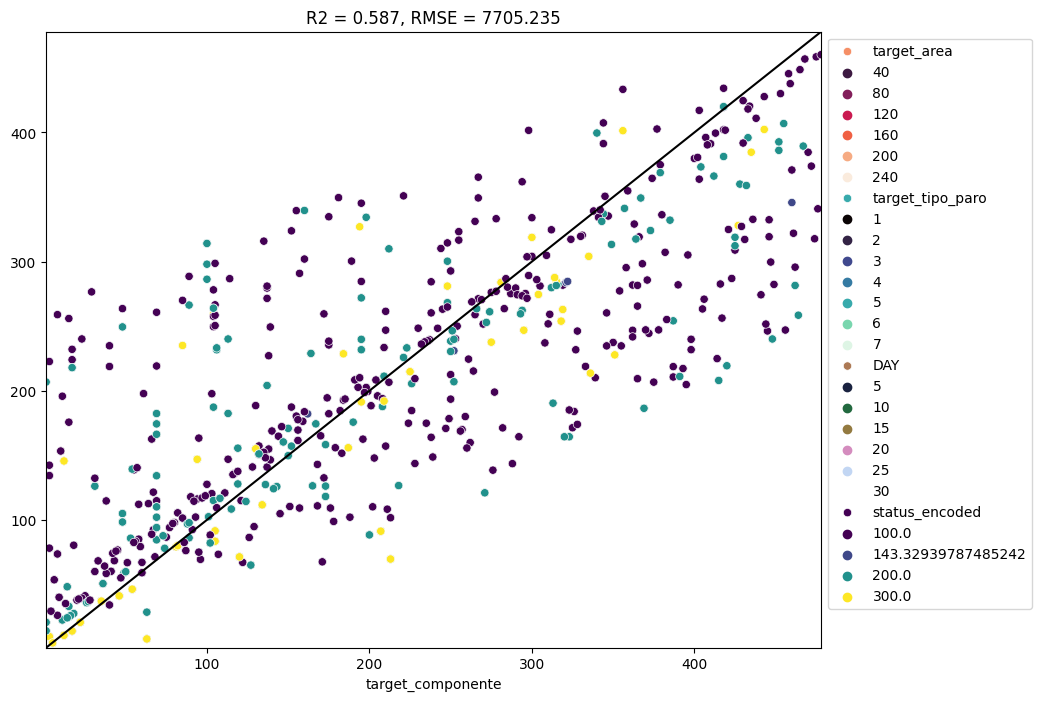

In [ ]:
data_plot = x_train.copy()
data_plot['target_componente'] = y_train
y_estimated = lr.predict(x_train)
r2=r2_score(y_train,y_estimated)
RMSE=mean_squared_error(y_train, y_estimated)


plt.figure(figsize=(10, 8))
sns.scatterplot(data=data_plot, x='target_componente', y=y_estimated, hue='target_area', palette='rocket', label='target_area')
sns.scatterplot(data=data_plot, x='target_componente', y=y_estimated, hue='target_tipo_paro', palette='mako', label='target_tipo_paro')
sns.scatterplot(data=data_plot, x='target_componente', y=y_estimated, hue='DAY', palette='cubehelix', label='DAY')
sns.scatterplot(data=data_plot, x='target_componente', y=y_estimated, hue='status_encoded', palette='viridis', label='status_encoded')


plt.plot([-1.5, y_train.max()], [-1.5, y_train.max()], color='k')
plt.ylim(y_train.min(), y_train.max())
plt.xlim(y_train.min(), y_train.max())
plt.title('R2 = ' + str(np.round(r2, 3)) + ', RMSE = ' + str(np.round(RMSE, 3)))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

7.2 Testeo de la regresion

Text(0.5, 1.0, 'R2 = 0.655, RMSE = 6587.408')

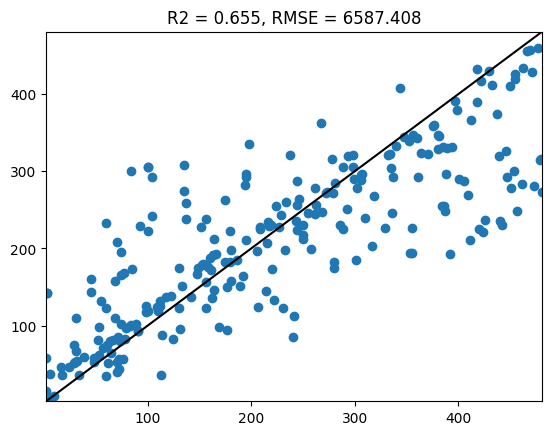

In [ ]:
y_estimated = lr.predict(x_test)
r2=r2_score(y_test,y_estimated)
RMSE=mean_squared_error(y_test, y_estimated)

plt.scatter(y_test, y_estimated)
plt.plot([-1.5,y_test.max()],[-1.5,y_test.max()], color='k')
plt.ylim(y_test.min(),y_test.max())
plt.xlim(y_test.min(),y_test.max())
plt.title('R2 = ' + str(np.round(r2,3))+', RMSE = '+str(np.round(RMSE,3)))


**Resultados del Conjunto de Entrenamiento:**

En el conjunto de entrenamiento, el coeficiente de determinación R2 es de 0.587. Este valor indica que el modelo de regresión lineal explica aproximadamente el 58.7% de la variabilidad observada en los datos de entrenamiento. Un R2 de este tamaño sugiere una relación significativa entre las variables independientes y la variable dependiente(target_componente), pero también indica que hay factores no capturados por el modelo que contribuyen a la variabilidad restante.

El error cuadrático medio (RMSE) en el conjunto de entrenamiento es de 7705.235. El RMSE mide la magnitud promedio de los errores entre las predicciones del modelo y los valores reales. Un valor de RMSE más bajo indica que el modelo tiende a realizar predicciones más precisas en el conjunto de entrenamiento.

**Resultados del Conjunto de Prueba:**

En el conjunto de prueba, el R2 aumenta a 0.655. Este incremento puede deberse a que el modelo es capaz de generalizar bien a datos no vistos, lo cual es un buen indicador de la capacidad del modelo para realizar predicciones en nuevos conjuntos de datos. Un R2 de 0.655 indica que el modelo explica aproximadamente el 65.5% de la variabilidad en los datos de prueba.

El RMSE en el conjunto de prueba es de 6587.408. Aunque este valor es ligeramente inferior al RMSE del conjunto de entrenamiento, sigue siendo importante considerar el contexto específico del problema y cómo el modelo se comportará en diferentes conjuntos de datos futuros.

En resumen, los resultados muestran que el modelo de regresión lineal tiene cierta capacidad predictiva, pero puede haber espacio para mejorar la explicación de la variabilidad en los datos. Es esencial evaluar estos resultados en función de la naturaleza del problema y considerar posibles ajustes o mejoras en el modelo para lograr un rendimiento aún mejor.


*   Los componentes que mas se repiten en falla lo visualizamos respecto a todos los mantenmientos realizados.

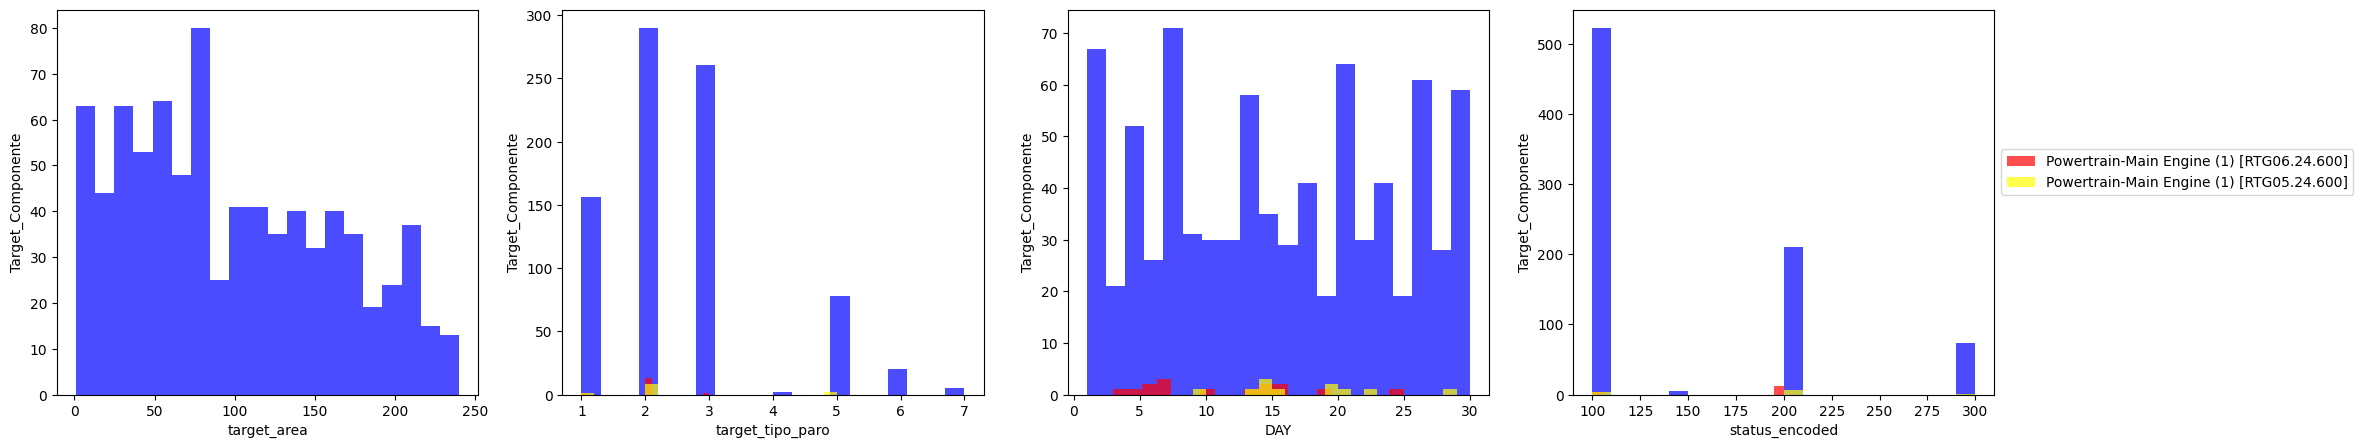

In [ ]:
# Variables predictoras (características)
features =  data_encoded[['target_area', 'target_tipo_paro','DAY','status_encoded']]

# Etiquetas de las clases (predictando)
target_componente_values = data_encoded['target_componente']

# Se Configura el diseño de la figura con 4 subtramas (1 para cada variable más 1 para el predictando)
fig, axes = plt.subplots(1, 4, figsize=(25, 5))
plt.subplots_adjust(wspace=0.2)

# Se traza histogramas para las variables predictoras
for i, feature in enumerate(features):
    values = x[feature]
    # Se crea un filtro booleano para los valores deseados (69 y 195)
    mask_69 = (target_componente_values == 69)
    mask_195 = (target_componente_values == 195)

    # Plotea todos los valores
    axes[i].hist(values, bins=20, color='b', alpha=0.7)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Target_Componente')

    # Se resalta los valores 69 y 195 en un color distinto
    axes[i].hist(values[mask_69], bins=20, color='red', alpha=0.7, label='Powertrain-Main Engine (1) [RTG06.24.600]')
    axes[i].hist(values[mask_195], bins=20, color='yellow', alpha=0.7, label='Powertrain-Main Engine (1) [RTG05.24.600]')

# Mostrar la leyenda para cada subplot
axes[3].axis('on')
axes[3].legend(loc='lower left', bbox_to_anchor=(1,0.5), ncol=1)

plt.show()


*   Se realiza la estandarizacion de los datos.

In [ ]:
# Se crea una instancia de StandardScaler
scaler = StandardScaler()

# Se ajusta el escalador a los datos originales y transforma las variables predictoras
scaled_data = scaler.fit(x.values).transform(x.values)

# Se asigna un nuevo nombre a las variables transformadas (por ejemplo, agregando "_scaled")
column_names = [f"{feature}_scaled" for feature in x.columns]

# Se crea un DataFrame a partir de los datos escalados con los nombres de columnas y los índices originales
scaled_df = pd.DataFrame(scaled_data, columns=column_names, index=x.index)

# Se muestra el DataFrame resultante
print(scaled_df.head())

   target_area_scaled  target_tipo_paro_scaled  DAY_scaled  \
0           -1.506350                -1.214823   -1.625628   
1           -1.506350                -0.431937   -1.625628   
2           -1.490802                -0.431937   -1.625628   
3           -1.475255                -1.214823   -1.625628   
4           -1.459707                -0.431937   -1.625628   

   status_encoded_scaled  
0               0.855473  
1               0.855473  
2               0.855473  
3               2.389467  
4              -0.678521  


In [ ]:
# Se separa los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.3, random_state=42)

# Se muestra las dimensiones de los conjuntos de entrenamiento y prueba
print("Conjunto de Entrenamiento - Predictores:", X_train.shape)
print("Conjunto de Prueba - Predictores:", X_test.shape)
print("Conjunto de Entrenamiento - Etiquetas:", y_train.shape)
print("Conjunto de Prueba - Etiquetas:", y_test.shape)

Conjunto de Entrenamiento - Predictores: (568, 4)
Conjunto de Prueba - Predictores: (244, 4)
Conjunto de Entrenamiento - Etiquetas: (568,)
Conjunto de Prueba - Etiquetas: (244,)


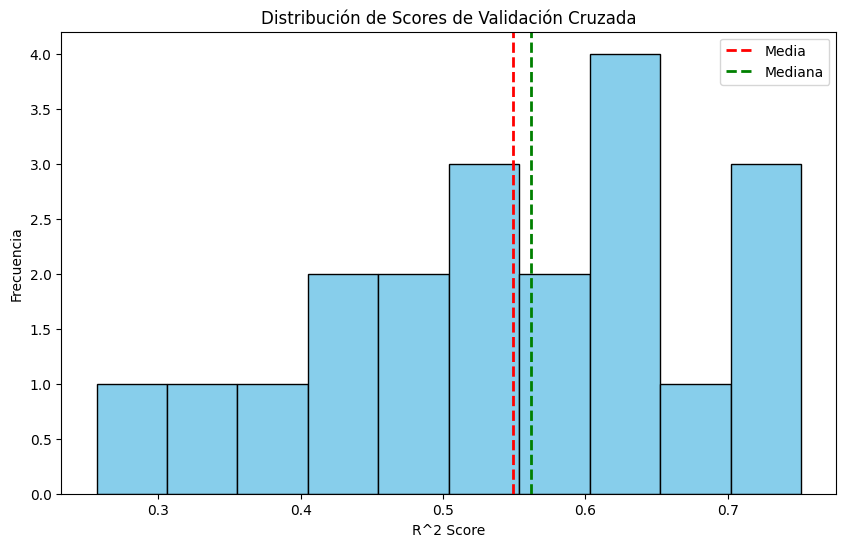

Media de los Scores: 0.5489422192403116
Mediana de los Scores: 0.5619708060074387
Desviación Estándar de los Scores: 0.1346238853330024


In [ ]:
# Se define el modelo de regresión Lasso
lasso_model = Lasso()

# Se realiza la validación cruzada para evaluar el rendimiento del modelo
num_regressors = 20
cross_val_scores = cross_val_score(lasso_model, X_train, y_train, cv=num_regressors, scoring='r2')

# Se grafica la distribución de los scores
plt.figure(figsize=(10, 6))
plt.hist(cross_val_scores, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('R^2 Score')
plt.ylabel('Frecuencia')
plt.title('Distribución de Scores de Validación Cruzada')
plt.axvline(np.mean(cross_val_scores), color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(np.median(cross_val_scores), color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.legend()
plt.show()

# Se muestra las principales medidas
print("Media de los Scores:", np.mean(cross_val_scores))
print("Mediana de los Scores:", np.median(cross_val_scores))
print("Desviación Estándar de los Scores:", np.std(cross_val_scores))

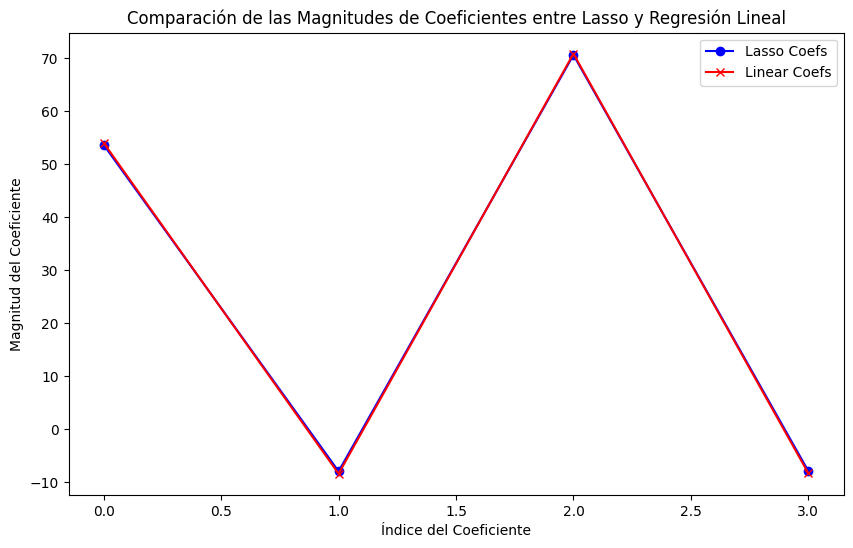

In [ ]:
# Se entrena un modelo de regresión Lasso
lasso_model = Lasso(alpha=0.4)  # Se Puede ajustar el valor de alpha según sea necesario
lasso_model.fit(X_train, y_train)

# Se entrena un modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Se obtiene los coeficientes de ambos modelos
lasso_coefs = lasso_model.coef_
linear_coefs = linear_model.coef_

# Se crea un gráfico para comparar las magnitudes de los coeficientes
plt.figure(figsize=(10, 6))
plt.plot(range(len(lasso_coefs)), lasso_coefs, marker='o', label='Lasso Coefs', color='blue')
plt.plot(range(len(linear_coefs)), linear_coefs, marker='x', label='Linear Coefs', color='red')
plt.xlabel('Índice del Coeficiente')
plt.ylabel('Magnitud del Coeficiente')
plt.legend()
plt.title('Comparación de las Magnitudes de Coeficientes entre Lasso y Regresión Lineal')
plt.show()

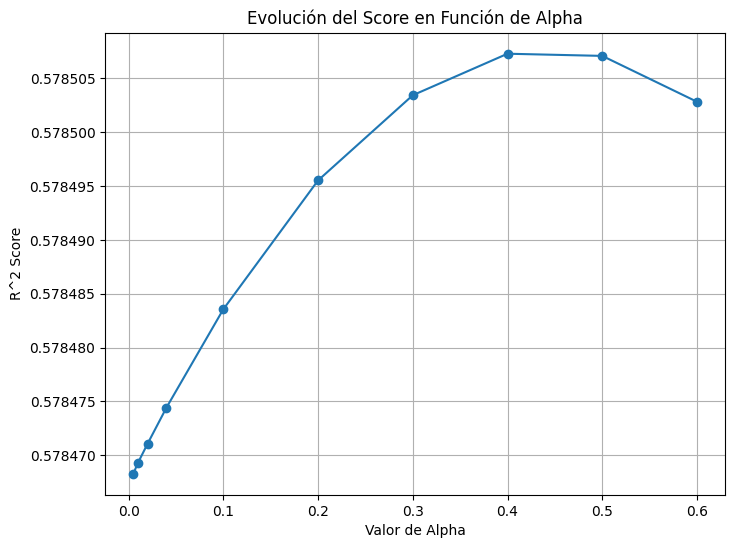

Mejor valor de Alpha: 0.4


In [ ]:
# Se define un diccionario de parámetros con valores para alpha
parameters = {'alpha': [0.005,0.01,0.02, 0.04,0.1,0.2,0.3,0.4,0.5,0.6]}

# Se crea un buscador de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(lasso_model, parameters, cv=5, scoring='r2')

# Se entrena el buscador de hiperparámetros
grid_search.fit(X_train, y_train)

# Se guarda los resultados en un DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Se grafica la evolución del score en función del valor del hiperparámetro
plt.figure(figsize=(8, 6))
plt.plot(results_df['param_alpha'], results_df['mean_test_score'], marker='o', linestyle='-')
plt.xlabel('Valor de Alpha')
plt.ylabel('R^2 Score')
plt.title('Evolución del Score en Función de Alpha')
plt.grid(True)
plt.show()

# Se obtiene el mejor valor de alpha
best_alpha = grid_search.best_params_['alpha']
print("Mejor valor de Alpha:", best_alpha)

Mediante la función GridsearchCV se encuentra el mejor alpha para posteriormente utilizarlo en el modelo de lasso, y asi graficar una dispersión entre valores reales vs estimados.

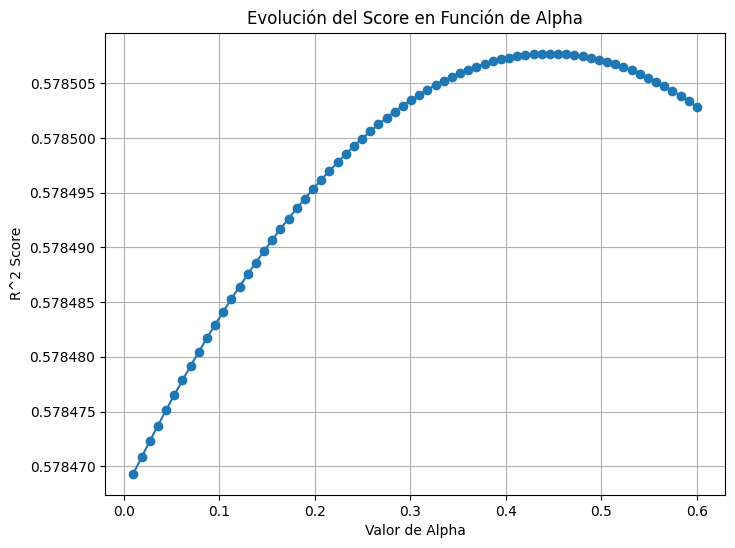

Mejor valor de Alpha: 0.44608695652173913


In [ ]:
# Se define un diccionario de parámetros con valores para alpha utilizando linspace
parameters = {'alpha': np.linspace(0.01, 0.6,70)}

# Se crea un buscador de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(lasso_model, parameters, cv=5, scoring='r2')

# Se entrenar el buscador de hiperparámetros
grid_search.fit(X_train, y_train)

# Se guarda los resultados en un DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Se grafica la evolución del score en función del valor del hiperparámetro
plt.figure(figsize=(8, 6))
plt.plot(results_df['param_alpha'], results_df['mean_test_score'], marker='o', linestyle='-')
plt.xlabel('Valor de Alpha')
plt.ylabel('R^2 Score')
plt.title('Evolución del Score en Función de Alpha')
plt.grid(True)
plt.show()

# Se obtiene el mejor valor de alpha
best_alpha = grid_search.best_params_['alpha']
print("Mejor valor de Alpha:", best_alpha)

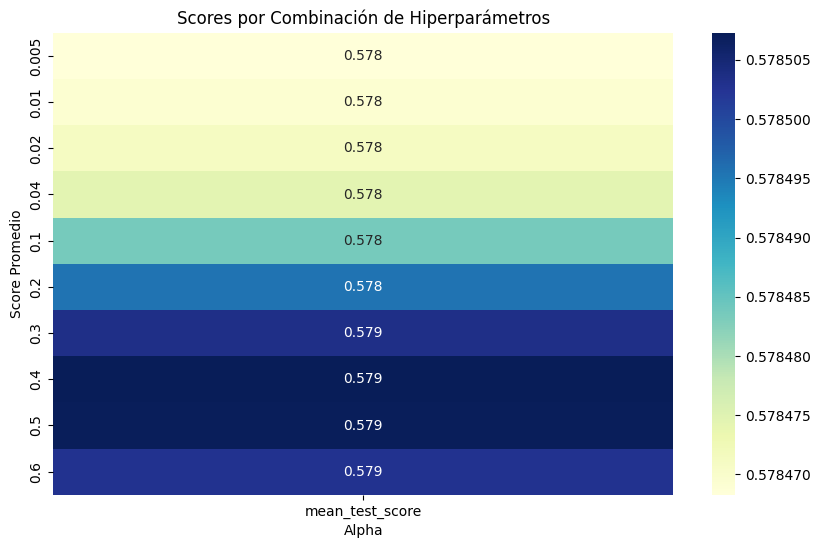

Mejor combinación de hiperparámetros:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
7       0.003957        0.0012         0.002232        0.000126         0.4   

           params  split0_test_score  split1_test_score  split2_test_score  \
7  {'alpha': 0.4}            0.57059           0.601365           0.585476   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
7           0.541084           0.594021         0.578507         0.02133   

   rank_test_score  
7                1  


In [ ]:
# Se obtiene los hiperparámetros y los scores del DataFrame de resultados
hyperparameters = results_df['param_alpha']
scores = results_df['mean_test_score']

# Se crea un mapa de calor
plt.figure(figsize=(10, 6))
heatmap_data = results_df.pivot_table(index='param_alpha', values='mean_test_score', aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.xlabel('Alpha')
plt.ylabel('Score Promedio')
plt.title('Scores por Combinación de Hiperparámetros')
plt.show()

# Se obtiene la mejor combinación de hiperparámetros
best_combination = results_df[results_df['mean_test_score'] == results_df['mean_test_score'].max()]
print("Mejor combinación de hiperparámetros:")
print(best_combination)

In [ ]:
# Se utiliza la mejor combinación de hiperparámetros encontrada
best_alpha = best_combination['param_alpha'].values[0]  # Mejor valor de alpha

# Se crea el modelo Lasso con los mejores hiperparámetros
lasso_model = Lasso(alpha=best_alpha)

# Se entrena el modelo en el conjunto de entrenamiento
lasso_model.fit(X_train, y_train)

# Se realiza predicciones en el conjunto de pruebas
y_pred = lasso_model.predict(X_test)

# Ahora se puede evaluar el rendimiento del modelo en el conjunto de pruebas

Coeficiente de Correlación: 0.8147
Coeficiente de Determinación (R^2): 0.6556


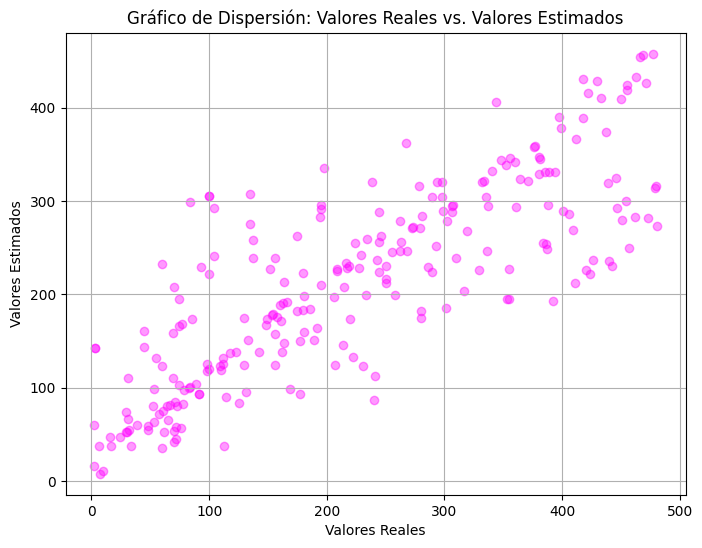

In [ ]:
# Se gráfica la dispersión entre los valores reales y los valores estimados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='magenta', alpha=best_alpha)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Estimados')
plt.title('Gráfico de Dispersión: Valores Reales vs. Valores Estimados')
plt.grid(True)

# Se calcula el coeficiente de correlación (R cuadrado)
correlation_coefficient = np.corrcoef(y_test, y_pred)[0, 1]
r2 = r2_score(y_test, y_pred)

print(f'Coeficiente de Correlación: {correlation_coefficient:.4f}')
print(f'Coeficiente de Determinación (R^2): {r2:.4f}')

plt.show()

**Coeficiente de Correlación:**

El coeficiente de correlación entre los valores reales y los valores estimados es de 0.8147. Este valor, que oscila entre -1 y 1, sugiere una fuerte correlación positiva entre las predicciones del modelo y los valores reales. En otras palabras, cuando los valores reales aumentan, el modelo tiende a hacer predicciones más altas de manera consistente.

**Coeficiente de Determinación (R^2):**

El coeficiente de determinación (R2) es un indicador clave del rendimiento del modelo. En este caso, R2 tiene un valor de 0.6556. Este valor representa la proporción de la variabilidad en los datos de prueba que es explicada por el modelo. Un R2 de 0.6556 indica que el modelo explica aproximadamente el 65.56% de la variabilidad en los datos de prueba.

En conjunto, estos resultados sugieren que el modelo de regresión lineal ha demostrado ser efectivo para prever los valores en el conjunto de prueba. El coeficiente de correlación elevado y el R2 positivo son indicativos de una relación sólida entre las variables predictoras y la variable de respuesta. Sin embargo, siempre es prudente considerar la posibilidad de ajustes o mejoras en el modelo, según las necesidades específicas del problema en cuestión.

In [ ]:
#Creamos el objeteo XGBoost
regressor = xgb.XGBRegressor(
    n_estimators=20,
    reg_lambda=4, # L1 regularization term on weights
    gamma=1, # Minimum loss reduction required to make a further partition on a leaf node of the tree
    max_depth=4
)

#Fiteamos
regressor.fit(x_train, y_train)

#Predecimos
y_pred = regressor.predict(x_test)

#Error
mean_squared_error(y_test, y_pred)

6709.651070891772

# **Clasificación**


*   Se separa los datos en conjuntos de entrenamiento y prueba, y tambien se realiza una validación cruzada estratificada.

In [ ]:
# Define tus datos X e y
x = data_encoded[['target_area', 'target_tipo_paro','DAY','status_encoded']]
y = data_encoded['target_componente']

# Define el número de pliegues para la validación cruzada
num_folds = 20

# Inicializa el validador cruzado estratificado
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Realiza la validación cruzada estratificada
for train_index, test_index in stratified_kfold.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Imprime los tamaños de los conjuntos de entrenamiento y prueba en cada iteración
print(f"Train size = {len(x_train)}, Test size = {len(x_test)}")

Train size = 810, Test size = 42



*   Se prueban algunos modelos distintos de entrenamiento de datos:

A - Modelo de Regresión Logística





In [ ]:
print("Dimensiones de X_train:", x_train.shape)
print("Dimensiones de y_train:", y_train.shape)

Dimensiones de X_train: (810, 4)
Dimensiones de y_train: (810,)


In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(x_test)
print("Precisión del modelo de Regresión Logística:", accuracy_score(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


Precisión del modelo de Regresión Logística: 0.047619047619047616
Matriz de confusión:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]
Reporte de clasificación:
              precision    recall  f1-score   support

           8       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.10      0.50      0.17         2
          31       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         0
          43       0.00      0.00      0.00         1
          48       0.00      0.00      0.00         0
          53       0.00      0.00      0.00         1
          61       0.00      0.00      0.00         1
          69       0.50      1.00      0.67         1
          75       0.00      0.00      0.00         1
          87       0.00      0.00      0.00         1
          96       0.00      0.00      0.00         1
         1

B - Modelo de Árbol de decisión

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)


DecisionTreeClassifier()

In [ ]:
y_pred = decision_tree.predict(x_test)
print("Precisión del modelo de Árbol de decision:", accuracy_score(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Precisión del modelo de Árbol de decision: 0.3333333333333333
Matriz de confusión:
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
Reporte de clasificación:
              precision    recall  f1-score   support

           8       0.00      0.00      0.00         1
          17       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         2
          25       0.00      0.00      0.00         0
          31       1.00      1.00      1.00         1
          40       0.00      0.00      0.00         0
          42       0.00      0.00      0.00         0
          43       0.00      0.00      0.00         1
          53       0.00      0.00      0.00         1
          61       0.00      0.00      0.00         1
          66       0.00      0.00      0.00         0
          69       1.00      1.00      1.00         1
          75       0.00      0.00      0.00         1
          87  

C - Modelo Random Forest

In [ ]:
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)


RandomForestClassifier()

In [ ]:
y_pred = random_forest.predict(x_test)
print("Precisión del modelo de Random Forest:", accuracy_score(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Precisión del modelo de Random Forest: 0.21428571428571427
Matriz de confusión:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
Reporte de clasificación:
              precision    recall  f1-score   support

           8       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       1.00      1.00      1.00         2
          31       0.00      0.00      0.00         1
          33       0.00      0.00      0.00         0
          37       0.00      0.00      0.00         0
          40       0.00      0.00      0.00         0
          43       0.00      0.00      0.00         1
          53       0.00      0.00      0.00         1
          54       0.00      0.00      0.00         0
          61       0.00      0.00      0.00         1
          69       1.00      1.00      1.00         1
          71       0.00      0.00      0.00         0
          75     

D - Modelo Support Vector Machine

In [ ]:
svc = SVC()
svc.fit(x_train, y_train)


SVC()

In [ ]:
y_pred = svc.predict(x_test)
print("Precisión del modelo de Support Vector Machine:", accuracy_score(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Precisión del modelo de Support Vector Machine: 0.07142857142857142
Matriz de confusión:
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Reporte de clasificación:
              precision    recall  f1-score   support

           8       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.08      1.00      0.14         2
          31       0.00      0.00      0.00         1
          43       0.00      0.00      0.00         1
          53       0.00      0.00      0.00         1
          61       0.00      0.00      0.00         1
          69       0.25      1.00      0.40         1
          75       0.00      0.00      0.00         1
          87       0.00      0.00      0.00         1
          96       0.00      0.00      0.00         1
         104       0.00      0.00      0.00         1
         107       0.00      0.00      0.00         1
        

8. Se decide realizar el entrenamiento utilizando el modelo de clasificación de árbol ya que es el modelo con mayor precisión, aunque con un 33%.

*   Se utiliza GridSearchCV para optimizar los hiperparámetros del árbol de
decisión, buscando las combinaciones que maximizan el rendimiento en la validación cruzada.

In [ ]:
num_trees = 15

# Se define los parámetros que se desea ajustar
param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

# Se crea un objeto GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=num_trees)

# Se ajusta el modelo
grid_search.fit(x, y)

# Se muestra los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)


Mejores parámetros: {'max_depth': 30, 'min_samples_split': 2}


*   Se incluye la visualización de la distribución de los puntajes obtenidos en la validación cruzada para comprender mejor la variabilidad del rendimiento del modelo.
Se calcula y muestra medidas estadísticas como la media, mediana y desviación estándar de los puntajes.

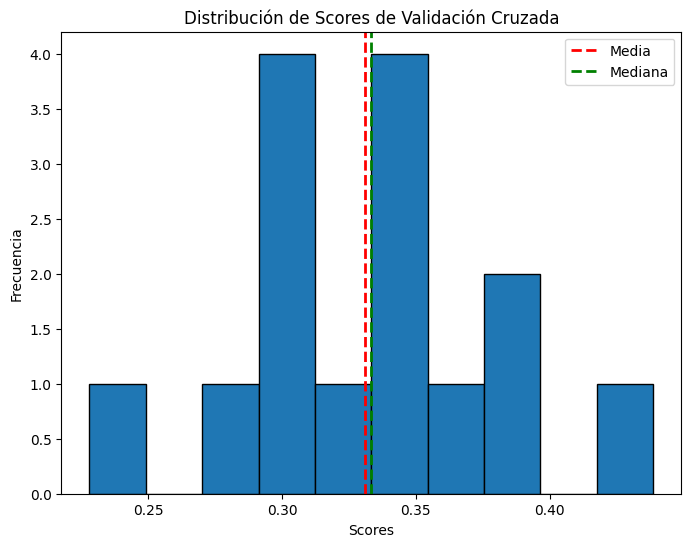

Media de los scores: 0.3309106098579783
Mediana de los scores: 0.3333333333333333
Desviación estándar de los scores: 0.049221762737330206


In [ ]:
# Se define el modelo de clasificación
model = DecisionTreeClassifier(max_depth=30, min_samples_split=2)

# Se entrena la validación cruzada de varios árboles
num_trees = 15
scores = cross_val_score(model, x, y, cv=num_trees)

# Se grafica la distribución de scores
plt.figure(figsize=(8, 6))
plt.hist(scores, bins=10, edgecolor='black')
plt.axvline(np.mean(scores), color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(np.median(scores), color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.xlabel('Scores')
plt.ylabel('Frecuencia')
plt.legend()
plt.title('Distribución de Scores de Validación Cruzada')
plt.show()

# Se muestra las medidas estadísticas
print(f"Media de los scores: {np.mean(scores)}")
print(f"Mediana de los scores: {np.median(scores)}")
print(f"Desviación estándar de los scores: {np.std(scores)}")

*   Se introduce la evaluación de una métrica adicional como el área bajo la curva ROC (ROC AUC) para tener una comprensión más completa del rendimiento, especialmente en problemas multiclase.

In [ ]:
model = DecisionTreeClassifier()
model.fit(x, y)

# Se realiza predicciones en los datos de entrenamiento o prueba
y_pred_proba = model.predict_proba(x)  # Probabilidades de cada clase

# Se calcula el ROC AUC para un problema multiclase
roc_auc = roc_auc_score(y, y_pred_proba, multi_class='ovr', labels=model.classes_)

print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.9999493387239947


La métrica ROC AUC nos infiere la posibilidad de overfitting al observar un alto valor en los datos de entrenamiento.
Podría ser una buena sugerencia el aumentar la cantidad de datos para abordar posibles problemas de overfitting.

In [ ]:
# Se entrena un solo árbol
model = DecisionTreeClassifier()
model.fit(x, y)

# Se genera datos del árbol para su visualización
dot_data = tree.export_graphviz(model, filled=True, rounded=True, out_file=None)

# Visualización del árbol
graph = Source(dot_data)
graph.render('mi_arbol', format='png')  # Se guarda el árbol en formato PNG con el nombre 'mi_arbol'
graph.view()  # Se muestra el árbol en una ventana emergente

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.444172 to fit


'mi_arbol.pdf'

*   Este código configura y entrena un clasificador XGBoost para la clasificación binaria. El resultado es un modelo XGBoost listo para realizar predicciones en nuevos datos.



In [ ]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10,seed=42,max_depth=6, learning_rate=0.01)

le = LabelEncoder()
y_train_encoded= le.fit_transform(y_train)

clf_xgb.fit(x_train,y_train_encoded) #Entrenamos el modelo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_train_pred = clf_xgb.predict(x_train) #Prediccion en Train
y_test_pred = clf_xgb.predict(x_test) #Prediccion en Test

#Calculo el accuracy en Train
#train_accuracy = accuracy_score(y_train, y_train_pred)

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

#print('% de aciertos sobre el set de entrenamiento:', train_accuracy)
print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de evaluación: 0.0


Podemos definir que el % de aciertos es realmente nulo mediante este modelo.

*   Se establece una cuadrícula de diferentes combinaciones de hiperparámetros.




In [ ]:
params_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

*   Se prueban distintos combinaciones de busqueda :
     

1.   GridSearchCV






In [ ]:
# tiempo de ejecucuon 424 seg
grid_cv = GridSearchCV(model, params_grid, scoring="accuracy", n_jobs=-1, cv=3)
grid_cv.fit(x_train, y_train)

print("Mejores Parametros", grid_cv.best_params_)
print("Mejor CV score", grid_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, grid_cv.predict(x_test)), 5)}')

Mejores Parametros {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Mejor CV score 0.32839506172839505
Accuracy del modelo = 0.28571


2.   RandomizedSearchCV

In [ ]:
# tiempo de ejecucuon 7 seg
grid_cv = RandomizedSearchCV(model, params_grid, scoring="accuracy", n_jobs=-1, cv=3)
grid_cv.fit(x_train, y_train)

print("Mejores parametros", grid_cv.best_params_)
print("Mejor score de CV", grid_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, grid_cv.predict(x_test)), 5)}')

Mejores parametros {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 7, 'criterion': 'entropy'}
Mejor score de CV 0.3185185185185185
Accuracy del modelo = 0.28571


3.   HalvingSearchCV

In [ ]:
# tiempo de ejecucuon 125 seg
halving_cv = HalvingGridSearchCV(model, params_grid, scoring="accuracy", factor=3, min_resources=100, max_resources=len(x_train), random_state=0)
halving_cv.fit(x_train, y_train)

print("Mejores parametros", halving_cv.best_params_)
print("Mejor Score CV", halving_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, halving_cv.predict(x_test)), 5)}')

Mejores parametros {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Mejor Score CV 0.20999999999999996
Accuracy del modelo = 0.30952


4.   BayesSearchCV

Se establece una cuadrícula de búsqueda para hiperparámetros específicos del modelo XGBoost.

In [ ]:
params_grid = {
        #'min_child_weight': Integer(1,10),
        #'gamma': Real(0.5, 5, prior='log-uniform'),
        #'subsample': Real(0.6, 1, prior='log-uniform'),
        #'colsample_bytree': Real(0.6, 1, prior='log-uniform'),
        'max_depth': Integer(5,7),
        'criterion':Categorical(['entropy','gini'])
        }

opt = BayesSearchCV(model,params_grid,n_iter=32,random_state=0)
opt.fit(x_train, y_train)


BayesSearchCV(estimator=DecisionTreeClassifier(), n_iter=32, random_state=0,
              search_spaces={'criterion': Categorical(categories=('entropy', 'gini'), prior=None),
                             'max_depth': Integer(low=5, high=7, prior='uniform', transform='normalize')})

En resumen, estos códigos buscan de manera eficiente los mejores hiperparámetros para un modelo de clasificación (árbol de decisión o XGBoost) mediante diferentes enfoques de búsqueda, y luego evalúan el rendimiento del modelo en un conjunto de prueba. Estos métodos ayudan a ajustar y optimizar los modelos para lograr un mejor rendimiento predictivo.

In [ ]:
opt._optim_results[0]['x_iters']

[['gini', 6],
 ['entropy', 7],
 ['gini', 5],
 ['entropy', 7],
 ['entropy', 5],
 ['gini', 7],
 ['gini', 7],
 ['gini', 6],
 ['entropy', 7],
 ['entropy', 6],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 7],
 ['entropy', 6],
 ['entropy', 7],
 ['entropy', 7]]

 Este código proporciona las combinaciones de hiperparámetros probadas durante la búsqueda.

*   Se define un modelo inicial de XGBoost con una tasa de aprendizaje baja



In [ ]:
model= xgb.XGBClassifier(learning_rate=0.001)
# Lista de hiperparametros
params_1 = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5}
params_2 = {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 7}
params_3 = {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10}

*   Se define un modelo de regresión de bosque aleatorio y se realiza la validación cruzada utilizando la métrica R².



In [ ]:
model = RandomForestRegressor(random_state=42, n_estimators=10,max_depth=4)
scores = cross_val_score(model, x, y, cv=7, verbose=1,scoring='r2')

In [ ]:
print("%0.2f de r2 promedio con una desviacion estandar de %0.2f" % (scores.mean(), scores.std()))

-0.27 de r2 promedio con una desviacion estandar de 1.04


El promedio de R² negativo sugiere que el modelo no se ajusta bien a los datos.
La desviación estándar alta indica una variabilidad significativa en los puntajes de validación cruzada, lo que podría ser un signo de falta de consistencia en el rendimiento del modelo.

 El resultado actual sugiere que este modelo puede no estar capturando adecuadamente la variabilidad en los datos.

*   Se crea un modelo de bosque aleatorio



In [ ]:
# Se separa en x y y
x, y = data_encoded.iloc[:, :-1], data_encoded.iloc[:, -1]
print(x.shape, y.shape)

(852, 14) (852,)


*   Se utiliza la técnica de validación cruzada estratificada para dividir el conjunto de datos en 5 pliegues.

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(x, y)

5

In [ ]:
train, test = list(skf.split(x, y))[0]
train

array([  0,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,  15,  16,
        17,  18,  19,  21,  22,  23,  24,  25,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  37,  38,  39,  40,  41,  42,  43,  45,  46,
        47,  48,  49,  50,  52,  53,  54,  55,  57,  58,  59,  60,  61,
        63,  66,  68,  69,  70,  71,  72,  74,  75,  76,  77,  78,  79,
        80,  81,  83,  84,  85,  87,  88,  89,  90,  91,  92,  93,  94,
        96,  97,  99, 100, 101, 102, 104, 106, 107, 108, 109, 111, 112,
       114, 117, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 131,
       132, 136, 137, 139, 140, 143, 144, 145, 146, 147, 149, 150, 154,
       155, 156, 159, 160, 161, 162, 163, 166, 168, 169, 170, 171, 173,
       174, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 188, 189,
       191, 192, 193, 194, 195, 196, 197, 198, 201, 202, 203, 204, 205,
       206, 207, 208, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 231, 232, 233, 23

In [ ]:
test

array([  1,   2,   4,  14,  20,  26,  36,  44,  51,  56,  62,  64,  65,
        67,  73,  82,  86,  95,  98, 103, 105, 110, 113, 115, 116, 118,
       124, 130, 133, 134, 135, 138, 141, 142, 148, 151, 152, 153, 157,
       158, 164, 165, 167, 172, 175, 182, 187, 190, 199, 200, 209, 211,
       229, 230, 238, 248, 250, 257, 262, 267, 271, 273, 276, 285, 291,
       296, 297, 310, 325, 327, 328, 331, 333, 341, 346, 349, 355, 361,
       364, 365, 366, 367, 368, 372, 374, 379, 382, 396, 402, 403, 404,
       407, 423, 434, 437, 439, 441, 451, 455, 458, 471, 473, 477, 481,
       484, 494, 498, 503, 512, 517, 520, 523, 524, 525, 539, 542, 545,
       547, 549, 558, 561, 566, 571, 577, 601, 611, 617, 625, 627, 635,
       637, 638, 639, 640, 641, 649, 654, 656, 671, 674, 676, 680, 692,
       698, 703, 710, 727, 729, 730, 733, 736, 741, 747, 748, 749, 762,
       764, 765, 775, 782, 785, 787, 802, 810, 812, 817, 827, 830, 842,
       845, 851])

In [ ]:
# Modelo vacio
model = RandomForestClassifier(random_state=1,n_estimators=30, criterion="gini",max_depth=4)
# Lista para guardar accuracy
list_ac=[]
for i in range(0,skf.get_n_splits(x, y)):
  # Calculo de indices
  train, test = list(skf.split(x, y))[i]
  # Separar train y test
  x_train_n, y_train_n, x_test_n, y_test_n= x.iloc[train], y.iloc[train], x.iloc[test],y.iloc[test]
  # Ajustar el modelo
  model.fit(x_train_n, y_train_n)
  # Predicciones
  pred= model.predict(x_test_n)
  # Calculo del error
  accuracy= accuracy_score(y_true=y_test_n, y_pred= pred)
  print('Iteracion: ',i+1, ' Accuracy:', accuracy)
  list_ac.append(accuracy)
# Promedio de accuracy
print('Accuracy promedio:', np.mean(list_ac))

Iteracion:  1  Accuracy: 0.6666666666666666
Iteracion:  2  Accuracy: 0.672514619883041
Iteracion:  3  Accuracy: 0.7470588235294118
Iteracion:  4  Accuracy: 0.711764705882353
Iteracion:  5  Accuracy: 0.7058823529411765
Accuracy promedio: 0.7007774337805298


Este código evalúa la precisión de un modelo de bosque aleatorio a través de la validación cruzada estratificada en cinco pliegues. La precisión promedio obtenida es del 70%, lo que indica cómo se espera que el modelo se desempeñe en datos nuevos y no vistos. Este enfoque de validación cruzada brinda una evaluación más robusta del rendimiento del modelo.

*   Se realiza una validación cruzada Leave-One-Out en un modelo de RandomForestClassifier



In [ ]:
cv = LeaveOneOut()

Se define un modelo de bosque aleatorio

In [ ]:
model2 = RandomForestClassifier(random_state=1,n_estimators=30, criterion="gini",max_depth=4)

In [ ]:
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   15.8s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   35.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:  1.1min


In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.704 (0.456)


El modelo de bosque aleatorio, evaluado mediante la validación cruzada Leave-One-Out, tiene una precisión promedio del 70.4%, con una variabilidad considerable (desviación estándar de 0.456). Este enfoque de validación cruzada es útil para evaluar el rendimiento del modelo en conjuntos de datos pequeños, pero la alta variabilidad sugiere que el modelo puede no generalizar de manera uniforme a todos los puntos de datos.

# BIAS y Varianza



1.   Generación de Datos y Ajuste de Polinomios:
*  Se genera una función sinusoidal con ruido gaussiano.
*  Se ajustan polinomios de diferentes grados a los datos generados.
*  Se visualiza la función original y los polinomios ajustados.



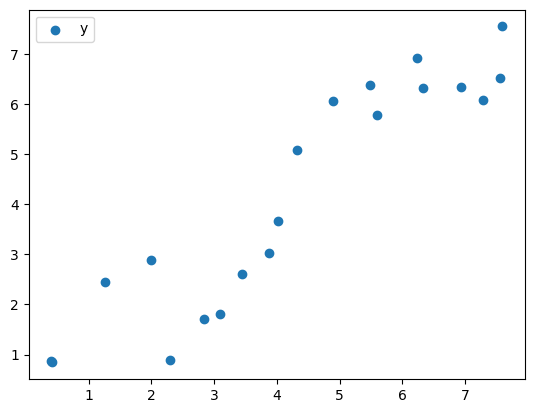

In [ ]:
random.seed(0)
x_range = np.arange(0,10,0.1)
std = 0.3**(1/2)
x_fit = np.random.uniform(0, 10, 20)
def func(x):
    return np.sin(1.5*x) + x

def addNoisetoFunc(f, shape, std):
    return f + np.random.randn(*shape) * std

def plotFunc(f):
    #plt.plot(x_range, f(x_range), label='f(x)')
    y = addNoisetoFunc(func(x_fit), x_fit.shape, std)
    plt.scatter(x_fit, y, label='y')

plotFunc(func)
plt.legend()
plt.show()

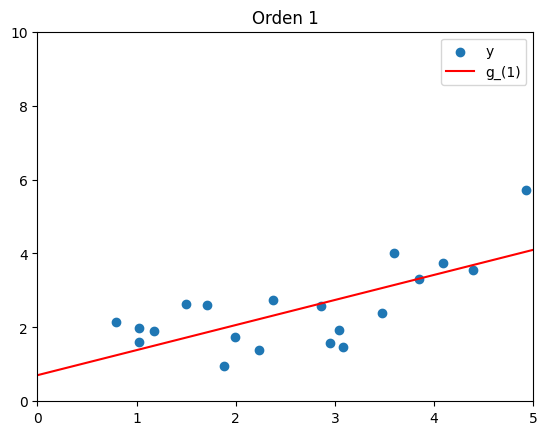

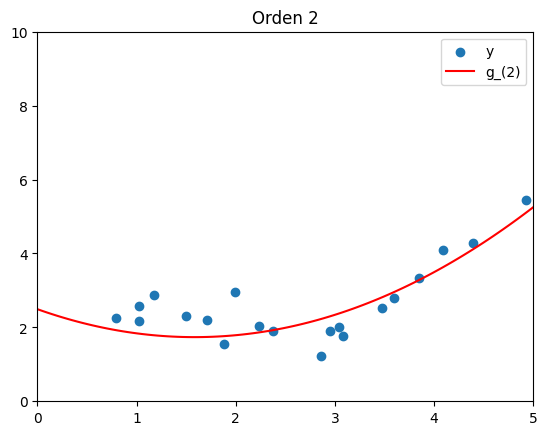

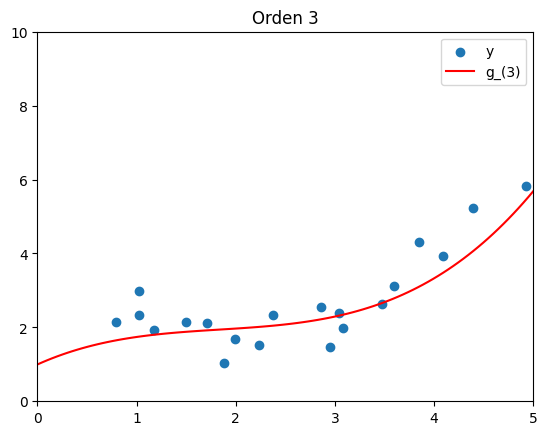

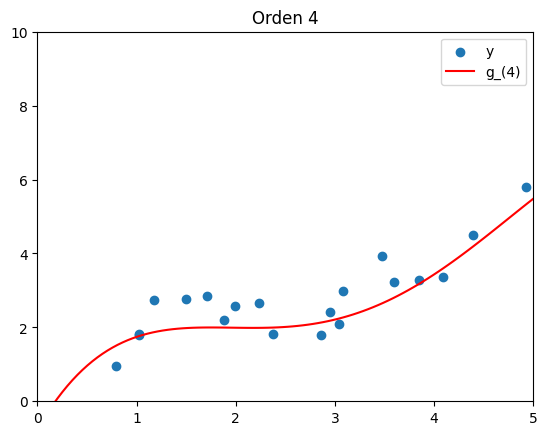

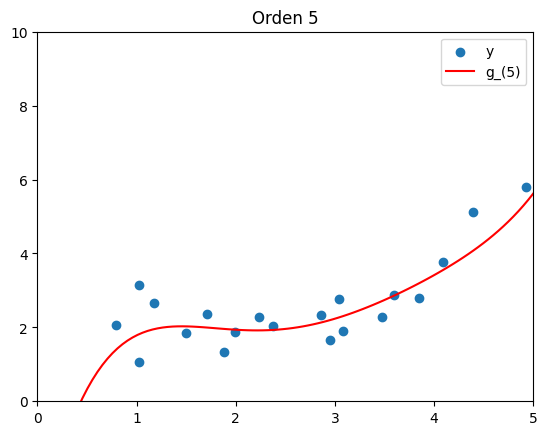

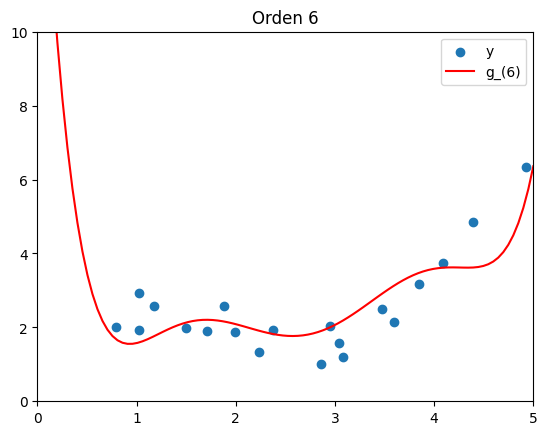

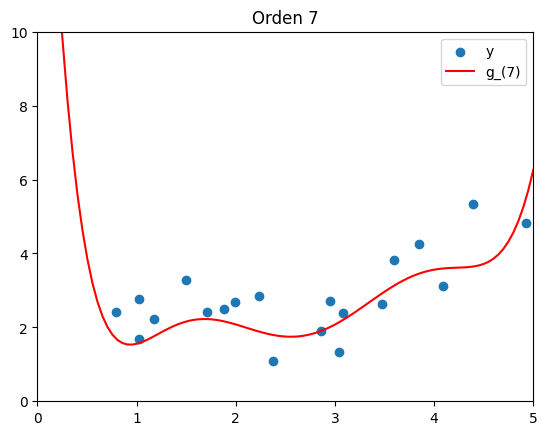

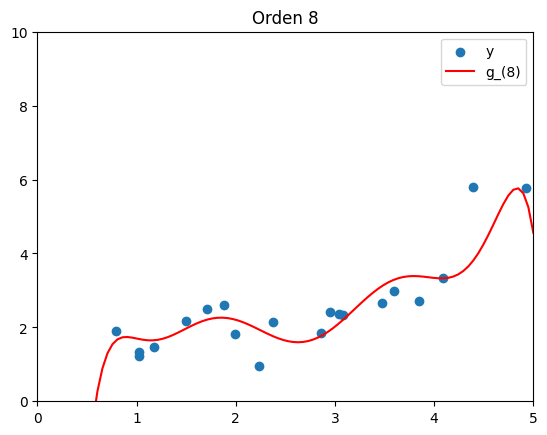

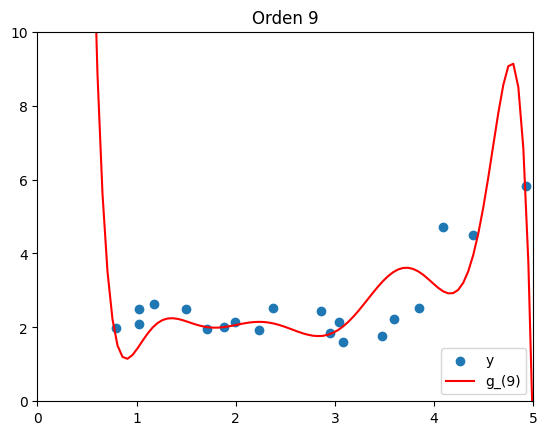

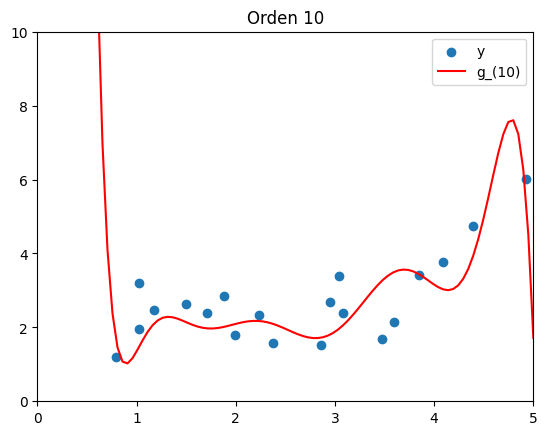

In [ ]:
polynomial_degrees = [1,2,3,4,5,6,7,8,9,10]
theta = {}
fit = {}
x_grid = np.linspace(0, 5, 100)
x_fit = np.random.uniform(0, 5, 20)
std = 0.3**(1/2)
y = addNoisetoFunc(func(x_fit), x_fit.shape, std)
for i, degree in enumerate(polynomial_degrees):
    plt.figure()
    plotFunc(func)
    theta[degree] = np.polyfit(x_fit, y, degree)
    fit[degree] = np.polyval(theta[degree], x_grid)
    plt.plot(x_grid, fit[degree], label="g_(" + str(degree) + ")", color='red')
    plt.legend()
    plt.xlim([0, 5])
    plt.ylim([0, 10])
    plt.title('Orden '+str(polynomial_degrees[i]) )

2.   Cálculo de Sesgo y Varianza:
*  Se divide el conjunto de datos en conjuntos de entrenamiento y prueba.
*  Se ajustan polinomios de varios grados y se calculan el sesgo y la varianza.

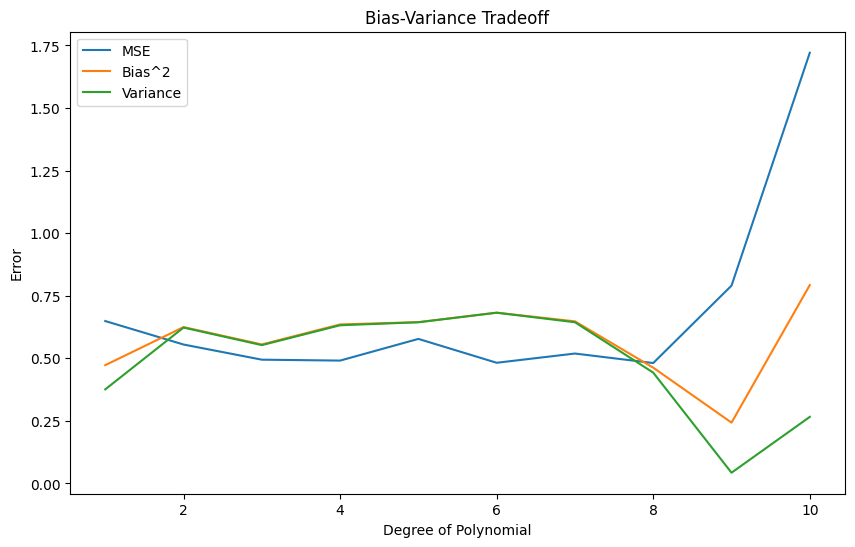

In [ ]:
# Split de datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_fit, y, test_size=0.2, random_state=42)

# Ajuste de polinomios y cálculo de sesgo-varianza
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mse, bias, var = [], [], []

for degree in degrees:
    # Se ajusta polinomio
    coeffs = np.polyfit(x_train, y_train, degree)
    y_pred = np.polyval(coeffs, x_test)

    # Se calcula sesgo y varianza
    bias_degree = np.mean((np.polyval(coeffs, x_test) - y_test.mean())**2)
    var_degree = np.var(np.polyval(coeffs, x_test))
    mse_degree = mean_squared_error(y_test, y_pred)

    mse.append(mse_degree)
    bias.append(bias_degree)
    var.append(var_degree)

# Se grafica resultados
plt.figure(figsize=(10, 6))
plt.plot(degrees, mse, label='MSE')
plt.plot(degrees, bias, label='Bias^2')
plt.plot(degrees, var, label='Variance')
plt.legend()
plt.xlabel('Degree of Polynomial')
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff')
plt.show()


3.  Análisis de Sesgo, Varianza y MSE para Múltiples Datasets:



*   Se simulan múltiples datasets y se ajustan polinomios a diferentes grados.
*   Se calculan y grafican el sesgo al cuadrado, la varianza y el error cuadrático medio para cada grado.

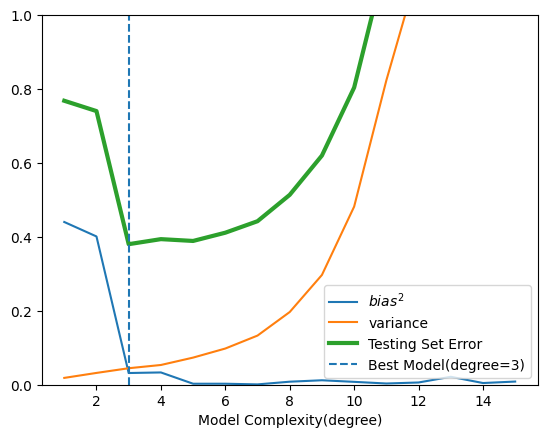

In [ ]:
#Hyper parameters
np.random.seed(0)
std = 0.3**(1/2) #gaussian noise std
dsize = 50 #size of each dataset
n_dataset = 100 #number of dataset
n_trainset = int(np.ceil(dsize * 0.8))
polynomial_degrees = range(1, 16) #model complexities
#Fixed x values
x = np.linspace(0, 5, dsize)
x = np.random.permutation(x)
x_train = x[:n_trainset]
x_test = x[n_trainset:]
#Variables
theta_hat = defaultdict(list)
pred_train = defaultdict(list)
pred_test = defaultdict(list)
train_errors = defaultdict(list)
test_errors = defaultdict(list)
mse_values = []
def error(pred, actual):
    return (pred - actual) ** 2

# Loop over datasets
def train_over_polynomial_degrees():
    for dataset in range(n_dataset):
        # Simulate training/testing targets
        y_train = addNoisetoFunc(func(x_train), x_train.shape, std)
        y_test = addNoisetoFunc(func(x_test), x_test.shape, std)
# Loop over model complexities
        for degree in polynomial_degrees:
            # Train model
            tmp_theta_hat = np.polyfit(x_train, y_train, degree)
# Make predictions on train set
            tmp_pred_train = np.polyval(tmp_theta_hat, x_train)
            pred_train[degree].append(tmp_pred_train)
# Test predictions
            tmp_pred_test = np.polyval(tmp_theta_hat, x_test)
            pred_test[degree].append(tmp_pred_test)
# Mean Squared Error for train and test sets
            train_errors[degree].append(np.mean(error(tmp_pred_train, y_train)))
            test_errors[degree].append(np.mean(error(tmp_pred_test, y_test)))
def calculate_estimator_bias_squared(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]
    return np.mean((average_model_prediction - func(x_test)) ** 2)
def calculate_estimator_variance(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]
    return np.mean((pred_test - average_model_prediction) ** 2)
#without regularization
train_over_polynomial_degrees()
complexity_train_error = []
complexity_test_error = []
bias_squared = []
variance = []
for degree in range(1, 16):
    complexity_train_error.append(np.mean(train_errors[degree]))
    complexity_test_error.append(np.mean(test_errors[degree]))
    bias_squared.append(calculate_estimator_bias_squared(pred_test[degree]))
    variance.append(calculate_estimator_variance(pred_test[degree]))
best_model_degree = polynomial_degrees[np.argmin(complexity_test_error)]
# Plot values
plt.plot(polynomial_degrees, bias_squared, label='$bias^2$')
plt.plot(polynomial_degrees, variance, label='variance')
plt.plot(polynomial_degrees, complexity_test_error, label='Testing Set Error', linewidth=3)
plt.axvline(best_model_degree, linestyle='--', label=f'Best Model(degree={best_model_degree})')
plt.xlabel('Model Complexity(degree)')
plt.ylim([0, 1])
plt.legend()

4.  Ajuste de Polinomio de Tercer Grado y Métricas de Rendimiento:
*   Se ajusta un polinomio de tercer grado al conjunto de entrenamiento y se evalúan las métricas de rendimiento en el conjunto de prueba.

In [ ]:
# Se ajusta polinomio de tercer grado
coeffs = np.polyfit(x_train, y_train, 3)

In [ ]:
# Predicciones en el conjunto de prueba
y_pred = np.polyval(coeffs, x_test)

In [ ]:
# Se calculan métricas de rendimiento
mse = mean_squared_error(y_test, y_pred)
bias_squared = np.mean((np.polyval(coeffs, x_test) - y_test.mean())**2)
variance = np.var(np.polyval(coeffs, x_test))

print(f"MSE: {mse}")
print(f"Bias^2: {bias_squared}")
print(f"Variance: {variance}")

MSE: 0.4945941323395682
Bias^2: 0.55543067087503
Variance: 0.5527529093479375


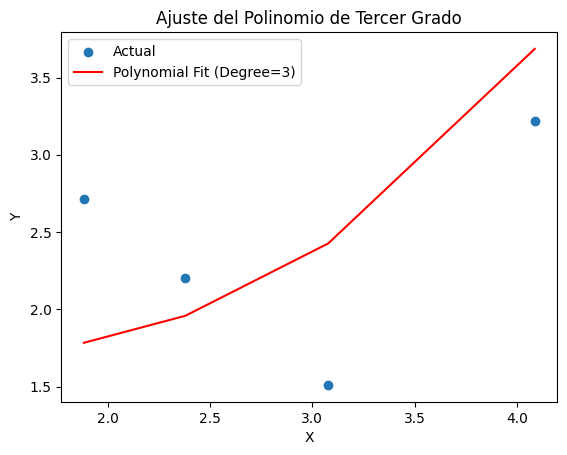

In [ ]:
# Se visualiza ajuste del polinomio
plt.scatter(x_test, y_test, label='Actual')
plt.plot(x_test, y_pred, color='red', label='Polynomial Fit (Degree=3)')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ajuste del Polinomio de Tercer Grado')
plt.show()

El código realiza análisis de sesgo y varianza para diferentes grados de polinomios, considerando la generación de múltiples datasets y evaluando métricas de rendimiento. Luego, ajusta un polinomio de tercer grado al conjunto de entrenamiento y evalúa su rendimiento en el conjunto de prueba.



---



# ***Conclusiones:***

Este proyecto se ha enfocado en potenciar la eficacia del mantenimiento mecánico de grúas, abordando preguntas cruciales mediante técnicas de Machine Learning. Aquí están las principales conclusiones:

**Fallas Más Frecuentes:**

Se identificaron las fallas más recurrentes en el historial de mantenimiento, proporcionando una base esencial para la planificación de estrategias preventivas.

-La familia de equipos de **RTG** acapara el **40% de las horas hombres** implementadas en el mantenmiento.

**Eficiencia en el Uso de Recursos Humanos:**

Se exploró la distribución de las horas hombre en relación con la naturaleza de la falla y el equipo afectado, ofreciendo una comprensión crucial sobre el esfuerzo requerido para abordar diferentes tipos de fallas.

-El **gancho de Grúa**, es una falla repetitiva de las que también deberia hacerse foco, teniendo mejores mantenimientos y a su vez más de back up.

**Predicción de Fallas Futuras:**

Se reconoció la necesidad de aprovechar técnicas predictivas, como el Machine Learning, para anticipar posibles fallas y adoptar enfoques preventivos en el mantenimiento.
Aunque los modelos actuales no alcanzaron altos niveles de certeza, se recomienda la obtención de más datos para mejorar la capacidad predictiva. De todos los algoritmos aplicados la regresión lineal en principio parece ser el más adecuado, sin embargo mediante una ampliación de los datos, habría que realizarse un nuevo análisis.

**Temporalidad de las Fallas:**

La exploración de la temporalidad de las fallas proporciona información valiosa para programar actividades de mantenimiento de manera más eficiente.
Se sugiere un enfoque continuo en la recopilación de datos temporales para mejorar la precisión de los análisis y visualizar las fallas a traves del tiempo.

Para finalizar, la investigación ha sentado las bases para mejorar la gestión del mantenimiento mecánico de las grúas en la terminal portuaria. Se destaca la necesidad de más datos para fortalecer la certeza de los modelos y se sugiere una revisión periódica de las estrategias a medida que se obtiene nueva información. Este enfoque iterativo permitirá una adaptación continua a las
necesidades cambiantes y conducirá a soluciones más efectivas en el futuro.